In [11]:
from pylab import plt
import pandas as pd
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import datetime as dt
import scipy as sc
from pylab import mpl
import scipy.integrate as sci
import scipy.stats as scs
import pandas_datareader as web
import statsmodels.api as sm
import enum
import scipy.optimize as spo
from numpy.fft import *
from yahoo_fin import options
from dawp import *
from mystic.solvers import fmin, fmin_powell, diffev, diffev2, sparsity,lattice
import math
import sys
import yfinance as yf

sys.path.append('../')
sys.path.append('C:/Users/kiedy/dx')

import autograd.numpy as agnp
from autograd import grad

np.set_printoptions(suppress=True, formatter={'all': lambda x: '%5.4f' % x})

In [12]:
options1=pd.DataFrame([43.10, 35.60, 22.90, 20.20, 13.30],
                     columns=['price'])
options1['strike']=(1090,1100,1120,1125,1140)
options1['maturity']=dt.datetime(2002,5,17)
options1['T_2']=0.088


options2=pd.DataFrame([84.50, 64.30, 39.50, 33.50, 30.70, 28.00,  25.60, 23.20,19.10,15.30,12.10,10.90],
                     columns=['price'])
options2['strike']=(1050,1075,1110,1120,1125,1130,1135,1140,1150,1160,1170,1175)
options2['maturity']=dt.datetime(2002,6,21)
options2['T_2']=0.184


options3=pd.DataFrame([161.60, 144.80, 120.10, 100.70, 82.50,65.50,51.00,45.50,38.10,27.70,19.60,13.20],
                     columns=['price'])
options3['strike']=(975,995,1025,1050,1075,1100,1125,1135,1150,1175,1200,1225)
options3['maturity']=dt.datetime(2002,9,20)
options3['T_2']=0.436



options4=pd.DataFrame([173.30,157.00,133.10,114.80,97.60,81.20,66.90,58.90,53.90,42.50,33.00,24.90,18.30,13.20],
                     columns=['price'])
options4['strike']=(975,995,1025,1050,1075,1100,1125,1140,1150,1175,1200,1225,1250,1275)
options4['maturity']=dt.datetime(2002,12,20)
options4['T_2']=0.692


options5=pd.DataFrame([146.50,96.20,81.70,68.30,56.60,46.10,36.90,29.30,22.50,17.20,12.80],
                     columns=['price'])
options5['strike']=(1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325)
options5['maturity']=dt.datetime(2003,3,21)
options5['T_2']=0.936


options6=pd.DataFrame([182.10,143.00,111.30,97.00,83.30,60.90,49.80,41.20,27.10,17.10,10.10],
                     columns=['price'])
options6['strike']=(995,1050,1100,1125,1150,1200,1225,1250,1300,1350,1400)
options6['maturity']=dt.datetime(2003,6,20)
options6['T_2']=1.192

options7=pd.DataFrame([171.40,140.40,112.80,99.80,66.90,49.50,35.70,25.20,17.00,12.20],
                     columns=['price'])
options7['strike']=(1050,1100,1150,1175,1250,1300,1350,1400,1450,1500)
options7['maturity']=dt.datetime(2003,12,19)
options7['T_2']=1.708

frames=[options1, options2, options3, options4, options5, options6, options7]

options=pd.concat(frames, ignore_index=True)
options['pricing_date'] = dt.datetime(2002, 4, 18)
options['T']=(options['maturity']-options['pricing_date']).dt.days/365.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


r=0.019
q=0.012
S0=1124.47
i = np.complex(0.0, 1.0)

# Metoda COS

In [13]:
def cf(u, T, r, C, G, M, Y):
    ''' Funkcja charakterystyczna w modelu CGMY '''
    b = r - q - C*math.gamma(-Y)*((M-1)**Y - M**Y + (G+1)**Y - G**Y)
    value = np.exp((1j * u * b + C*math.gamma(-Y)*((M-1j*u)**Y - M**Y + (G+1j*u)**Y - G**Y)) * T)
    return value

In [14]:
def G_(u, *args):
    ''' Funkcja generująca kumulanty'''
    return np.log(cf(-1j*u,T,r, C, G, M, Y))

T=1
C=1
G=2
M=3
Y=1.4

In [15]:
N=2**12
L=10
h=1e-3
    
def CallPutOptionPriceCOSMthd(cf,S0,r,T,K, C, G, M, Y,N,L,CALL):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - Interest rate (constant)
    # T    - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
        
    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
        
    x0 = np.log(S0 / K)
#     x0 = 0
    
    # kumulanty
    w=C*math.gamma(-Y)*((M-1)**Y - M**Y + (G+1)**Y - G**Y)
    c1=T*(r-q-w)+C*T*math.gamma(1-Y)*(M**(Y-1)-G**(Y-1))
    c2=C*T*math.gamma(2-Y)*(M**(Y-2)+G**(Y-2)) 
    c4=C*T*math.gamma(4-Y)*(M**(Y-4)+G**(Y-4))
    
    # kumulanty z automatycznego różniczkowania
#     c1=grad_g(0.)
#     c2=grad_g2(0.)
#     c4=grad_g4(0.)

    # kumulanty z metody różnic skończonych
    c1=(G_(h)-G_(-h))/(2*h)
    c2=(G_(h)-2*G_(0)+G_(-h))/(h**2)
    c4=(G_(3*h)-2*G_(2*h)+4*G_(0)-G_(h)-G_(-h)-2*G_(-2*h)+G_(-3*h))/(4*h**4)

    a=c1+x0-L*np.sqrt(c2+np.sqrt(c4))
    b=c1+x0+L*np.sqrt(c2+np.sqrt(c4))
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(a,b,k)   
    mat = np.exp(1j * np.outer((x0 - a) , u))
    temp = cf(u, T,r, C, G, M, Y) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * T) * K * np.real(mat.dot(temp))
    if CALL == True:
        return  value + np.exp(-q*T)*S0 - K*np.exp(-r*T)
    else:
        return value

# Determine coefficients for put prices 

def CallPutCoefficients(a,b,k):
    
    c = a
    d = 0.0
    coef = Chi_Psi(a,b,c,d,k)
    Chi_k = coef["chi"]
    Psi_k = coef["psi"]
    if a<b and b<0.0:
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k) 
    elif a>0 and a<b:
        H_k = np.zeros([len(k),1])
    else:
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [16]:
m=0
def CGMY_error_function(p0):
    
    global m
    C, G, M, Y=p0
    se = []
    if Y==0 or C<=0 or G<=0 or Y==1:
        return 100
    for row, option in options.iterrows():
        model_value = CallPutOptionPriceCOSMthd(cf,S0,r,option['T_2'],(option['strike'],),C, G, M, Y,N,L, True)[0][0]
        se.append((model_value - option['price']) ** 2)
    RMSE = (sum(se) / len(se))**0.5
    if m % 1 == 0:
        print('%4d |' % m, np.array(p0), '| %7.3f' % RMSE)
        
    m += 1
    return RMSE

CGMY_error_function((0.0211,0.01,9.2949,1.3622))

   0 | [0.0211 0.0100 9.2949 1.3622] |   2.683


2.683346407547854

In [10]:
def CGMY_calibration_full():
    i=0
    global opt
    p0 = spo.brute(CGMY_error_function, ((0.001,1, 0.09),(0.001,2, 0.1), (1.1,20,2),(0.001,2,0.2)), finish=None)
    opt = spo.fmin(CGMY_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=15000, maxfun=15000)
    return opt

%time CGMY_calibration_full()

8753 | [0.0010 0.0010 1.1000 0.0010] |  61.467
8754 | [0.0010 0.0010 1.1000 0.2010] |  24.450
8755 | [0.0010 0.0010 1.1000 0.4010] |  18.023
8756 | [0.0010 0.0010 1.1000 0.6010] |  29.050
8757 | [0.0010 0.0010 1.1000 0.8010] |  36.491
8758 | [0.0010 0.0010 1.1000 1.0010] |  39.907
8759 | [0.0010 0.0010 1.1000 1.2010] |  40.705
8760 | [0.0010 0.0010 1.1000 1.4010] |  39.861
8761 | [0.0010 0.0010 1.1000 1.6010] |  37.082
8762 | [0.0010 0.0010 1.1000 1.8010] |  28.956
8763 | [0.0010 0.0010 3.1000 0.0010] |  60.940
8764 | [0.0010 0.0010 3.1000 0.2010] |  24.207
8765 | [0.0010 0.0010 3.1000 0.4010] |  18.596
8766 | [0.0010 0.0010 3.1000 0.6010] |  29.730
8767 | [0.0010 0.0010 3.1000 0.8010] |  37.165
8768 | [0.0010 0.0010 3.1000 1.0010] |  40.575
8769 | [0.0010 0.0010 3.1000 1.2010] |  41.400
8770 | [0.0010 0.0010 3.1000 1.4010] |  40.627
8771 | [0.0010 0.0010 3.1000 1.6010] |  37.955
8772 | [0.0010 0.0010 3.1000 1.8010] |  29.919
8773 | [0.0010 0.0010 5.1000 0.0010] |  60.916
8774 | [0.001

8928 | [0.0010 0.1010 15.1000 1.0010] |  43.536
8929 | [0.0010 0.1010 15.1000 1.2010] |  42.983
8930 | [0.0010 0.1010 15.1000 1.4010] |  41.802
8931 | [0.0010 0.1010 15.1000 1.6010] |  39.180
8932 | [0.0010 0.1010 15.1000 1.8010] |  31.447
8933 | [0.0010 0.1010 17.1000 0.0010] |  43.951
8934 | [0.0010 0.1010 17.1000 0.2010] |  44.015
8935 | [0.0010 0.1010 17.1000 0.4010] |  43.995
8936 | [0.0010 0.1010 17.1000 0.6010] |  43.940
8937 | [0.0010 0.1010 17.1000 0.8010] |  43.813
8938 | [0.0010 0.1010 17.1000 1.0010] |  43.555
8939 | [0.0010 0.1010 17.1000 1.2010] |  43.014
8940 | [0.0010 0.1010 17.1000 1.4010] |  41.849
8941 | [0.0010 0.1010 17.1000 1.6010] |  39.253
8942 | [0.0010 0.1010 17.1000 1.8010] |  31.552
8943 | [0.0010 0.1010 19.1000 0.0010] |  43.952
8944 | [0.0010 0.1010 19.1000 0.2010] |  44.018
8945 | [0.0010 0.1010 19.1000 0.4010] |  43.999
8946 | [0.0010 0.1010 19.1000 0.6010] |  43.947
8947 | [0.0010 0.1010 19.1000 0.8010] |  43.823
8948 | [0.0010 0.1010 19.1000 1.0010] | 

9102 | [0.0010 0.3010 9.1000 1.8010] |  31.136
9103 | [0.0010 0.3010 11.1000 0.0010] |  44.174
9104 | [0.0010 0.3010 11.1000 0.2010] |  44.167
9105 | [0.0010 0.3010 11.1000 0.4010] |  44.131
9106 | [0.0010 0.3010 11.1000 0.6010] |  44.045
9107 | [0.0010 0.3010 11.1000 0.8010] |  43.889
9108 | [0.0010 0.3010 11.1000 1.0010] |  43.598
9109 | [0.0010 0.3010 11.1000 1.2010] |  43.014
9110 | [0.0010 0.3010 11.1000 1.4010] |  41.793
9111 | [0.0010 0.3010 11.1000 1.6010] |  39.113
9112 | [0.0010 0.3010 11.1000 1.8010] |  31.314
9113 | [0.0010 0.3010 13.1000 0.0010] |  44.179
9114 | [0.0010 0.3010 13.1000 0.2010] |  44.174
9115 | [0.0010 0.3010 13.1000 0.4010] |  44.140
9116 | [0.0010 0.3010 13.1000 0.6010] |  44.058
9117 | [0.0010 0.3010 13.1000 0.8010] |  43.910
9118 | [0.0010 0.3010 13.1000 1.0010] |  43.630
9119 | [0.0010 0.3010 13.1000 1.2010] |  43.061
9120 | [0.0010 0.3010 13.1000 1.4010] |  41.863
9121 | [0.0010 0.3010 13.1000 1.6010] |  39.218
9122 | [0.0010 0.3010 13.1000 1.8010] |  

9278 | [0.0010 0.5010 5.1000 1.0010] |  43.479
9279 | [0.0010 0.5010 5.1000 1.2010] |  42.820
9280 | [0.0010 0.5010 5.1000 1.4010] |  41.496
9281 | [0.0010 0.5010 5.1000 1.6010] |  38.668
9282 | [0.0010 0.5010 5.1000 1.8010] |  30.713
9283 | [0.0010 0.5010 7.1000 0.0010] |  44.286
9284 | [0.0010 0.5010 7.1000 0.2010] |  44.251
9285 | [0.0010 0.5010 7.1000 0.4010] |  44.185
9286 | [0.0010 0.5010 7.1000 0.6010] |  44.078
9287 | [0.0010 0.5010 7.1000 0.8010] |  43.897
9288 | [0.0010 0.5010 7.1000 1.0010] |  43.574
9289 | [0.0010 0.5010 7.1000 1.2010] |  42.949
9290 | [0.0010 0.5010 7.1000 1.4010] |  41.672
9291 | [0.0010 0.5010 7.1000 1.6010] |  38.909
9292 | [0.0010 0.5010 7.1000 1.8010] |  31.022
9293 | [0.0010 0.5010 9.1000 0.0010] |  44.299
9294 | [0.0010 0.5010 9.1000 0.2010] |  44.267
9295 | [0.0010 0.5010 9.1000 0.4010] |  44.208
9296 | [0.0010 0.5010 9.1000 0.6010] |  44.109
9297 | [0.0010 0.5010 9.1000 0.8010] |  43.939
9298 | [0.0010 0.5010 9.1000 1.0010] |  43.635
9299 | [0.001

9451 | [0.0010 0.6010 19.1000 1.6010] |  39.587
9452 | [0.0010 0.6010 19.1000 1.8010] |  31.945
9453 | [0.0010 0.7010 1.1000 0.0010] |  43.256
9454 | [0.0010 0.7010 1.1000 0.2010] |  43.355
9455 | [0.0010 0.7010 1.1000 0.4010] |  43.364
9456 | [0.0010 0.7010 1.1000 0.6010] |  43.279
9457 | [0.0010 0.7010 1.1000 0.8010] |  43.075
9458 | [0.0010 0.7010 1.1000 1.0010] |  42.685
9459 | [0.0010 0.7010 1.1000 1.2010] |  41.942
9460 | [0.0010 0.7010 1.1000 1.4010] |  40.496
9461 | [0.0010 0.7010 1.1000 1.6010] |  37.490
9462 | [0.0010 0.7010 1.1000 1.8010] |  29.376
9463 | [0.0010 0.7010 3.1000 0.0010] |  44.257
9464 | [0.0010 0.7010 3.1000 0.2010] |  44.199
9465 | [0.0010 0.7010 3.1000 0.4010] |  44.106
9466 | [0.0010 0.7010 3.1000 0.6010] |  43.964
9467 | [0.0010 0.7010 3.1000 0.8010] |  43.738
9468 | [0.0010 0.7010 3.1000 1.0010] |  43.357
9469 | [0.0010 0.7010 3.1000 1.2010] |  42.654
9470 | [0.0010 0.7010 3.1000 1.4010] |  41.273
9471 | [0.0010 0.7010 3.1000 1.6010] |  38.369
9472 | [0.0

9625 | [0.0010 0.8010 15.1000 0.4010] |  44.321
9626 | [0.0010 0.8010 15.1000 0.6010] |  44.232
9627 | [0.0010 0.8010 15.1000 0.8010] |  44.084
9628 | [0.0010 0.8010 15.1000 1.0010] |  43.816
9629 | [0.0010 0.8010 15.1000 1.2010] |  43.275
9630 | [0.0010 0.8010 15.1000 1.4010] |  42.119
9631 | [0.0010 0.8010 15.1000 1.6010] |  39.531
9632 | [0.0010 0.8010 15.1000 1.8010] |  31.840
9633 | [0.0010 0.8010 17.1000 0.0010] |  44.412
9634 | [0.0010 0.8010 17.1000 0.2010] |  44.379
9635 | [0.0010 0.8010 17.1000 0.4010] |  44.326
9636 | [0.0010 0.8010 17.1000 0.6010] |  44.240
9637 | [0.0010 0.8010 17.1000 0.8010] |  44.096
9638 | [0.0010 0.8010 17.1000 1.0010] |  43.836
9639 | [0.0010 0.8010 17.1000 1.2010] |  43.305
9640 | [0.0010 0.8010 17.1000 1.4010] |  42.166
9641 | [0.0010 0.8010 17.1000 1.6010] |  39.604
9642 | [0.0010 0.8010 17.1000 1.8010] |  31.946
9643 | [0.0010 0.8010 19.1000 0.0010] |  44.413
9644 | [0.0010 0.8010 19.1000 0.2010] |  44.381
9645 | [0.0010 0.8010 19.1000 0.4010] | 

9799 | [0.0010 1.0010 9.1000 1.2010] |  43.178
9800 | [0.0010 1.0010 9.1000 1.4010] |  41.960
9801 | [0.0010 1.0010 9.1000 1.6010] |  39.277
9802 | [0.0010 1.0010 9.1000 1.8010] |  31.476
9803 | [0.0010 1.0010 11.1000 0.0010] |  44.441
9804 | [0.0010 1.0010 11.1000 0.2010] |  44.403
9805 | [0.0010 1.0010 11.1000 0.4010] |  44.343
9806 | [0.0010 1.0010 11.1000 0.6010] |  44.247
9807 | [0.0010 1.0010 11.1000 0.8010] |  44.087
9808 | [0.0010 1.0010 11.1000 1.0010] |  43.804
9809 | [0.0010 1.0010 11.1000 1.2010] |  43.240
9810 | [0.0010 1.0010 11.1000 1.4010] |  42.050
9811 | [0.0010 1.0010 11.1000 1.6010] |  39.409
9812 | [0.0010 1.0010 11.1000 1.8010] |  31.655
9813 | [0.0010 1.0010 13.1000 0.0010] |  44.446
9814 | [0.0010 1.0010 13.1000 0.2010] |  44.410
9815 | [0.0010 1.0010 13.1000 0.4010] |  44.352
9816 | [0.0010 1.0010 13.1000 0.6010] |  44.260
9817 | [0.0010 1.0010 13.1000 0.8010] |  44.108
9818 | [0.0010 1.0010 13.1000 1.0010] |  43.836
9819 | [0.0010 1.0010 13.1000 1.2010] |  43.

9974 | [0.0010 1.2010 5.1000 0.2010] |  44.374
9975 | [0.0010 1.2010 5.1000 0.4010] |  44.296
9976 | [0.0010 1.2010 5.1000 0.6010] |  44.174
9977 | [0.0010 1.2010 5.1000 0.8010] |  43.979
9978 | [0.0010 1.2010 5.1000 1.0010] |  43.644
9979 | [0.0010 1.2010 5.1000 1.2010] |  43.005
9980 | [0.0010 1.2010 5.1000 1.4010] |  41.713
9981 | [0.0010 1.2010 5.1000 1.6010] |  38.924
9982 | [0.0010 1.2010 5.1000 1.8010] |  31.015
9983 | [0.0010 1.2010 7.1000 0.0010] |  44.451
9984 | [0.0010 1.2010 7.1000 0.2010] |  44.406
9985 | [0.0010 1.2010 7.1000 0.4010] |  44.336
9986 | [0.0010 1.2010 7.1000 0.6010] |  44.227
9987 | [0.0010 1.2010 7.1000 0.8010] |  44.049
9988 | [0.0010 1.2010 7.1000 1.0010] |  43.739
9989 | [0.0010 1.2010 7.1000 1.2010] |  43.135
9990 | [0.0010 1.2010 7.1000 1.4010] |  41.890
9991 | [0.0010 1.2010 7.1000 1.6010] |  39.167
9992 | [0.0010 1.2010 7.1000 1.8010] |  31.324
9993 | [0.0010 1.2010 9.1000 0.0010] |  44.463
9994 | [0.0010 1.2010 9.1000 0.2010] |  44.422
9995 | [0.001

10144 | [0.0010 1.3010 19.1000 0.2010] |  44.459
10145 | [0.0010 1.3010 19.1000 0.4010] |  44.408
10146 | [0.0010 1.3010 19.1000 0.6010] |  44.326
10147 | [0.0010 1.3010 19.1000 0.8010] |  44.191
10148 | [0.0010 1.3010 19.1000 1.0010] |  43.948
10149 | [0.0010 1.3010 19.1000 1.2010] |  43.444
10150 | [0.0010 1.3010 19.1000 1.4010] |  42.343
10151 | [0.0010 1.3010 19.1000 1.6010] |  39.833
10152 | [0.0010 1.3010 19.1000 1.8010] |  32.235
10153 | [0.0010 1.4010 1.1000 0.0010] |  43.374
10154 | [0.0010 1.4010 1.1000 0.2010] |  43.469
10155 | [0.0010 1.4010 1.1000 0.4010] |  43.478
10156 | [0.0010 1.4010 1.1000 0.6010] |  43.396
10157 | [0.0010 1.4010 1.1000 0.8010] |  43.199
10158 | [0.0010 1.4010 1.1000 1.0010] |  42.820
10159 | [0.0010 1.4010 1.1000 1.2010] |  42.096
10160 | [0.0010 1.4010 1.1000 1.4010] |  40.681
10161 | [0.0010 1.4010 1.1000 1.6010] |  37.714
10162 | [0.0010 1.4010 1.1000 1.8010] |  29.645
10163 | [0.0010 1.4010 3.1000 0.0010] |  44.373
10164 | [0.0010 1.4010 3.1000 0

10314 | [0.0010 1.5010 13.1000 0.2010] |  44.470
10315 | [0.0010 1.5010 13.1000 0.4010] |  44.414
10316 | [0.0010 1.5010 13.1000 0.6010] |  44.326
10317 | [0.0010 1.5010 13.1000 0.8010] |  44.180
10318 | [0.0010 1.5010 13.1000 1.0010] |  43.918
10319 | [0.0010 1.5010 13.1000 1.2010] |  43.386
10320 | [0.0010 1.5010 13.1000 1.4010] |  42.242
10321 | [0.0010 1.5010 13.1000 1.6010] |  39.664
10322 | [0.0010 1.5010 13.1000 1.8010] |  31.981
10323 | [0.0010 1.5010 15.1000 0.0010] |  44.509
10324 | [0.0010 1.5010 15.1000 0.2010] |  44.474
10325 | [0.0010 1.5010 15.1000 0.4010] |  44.421
10326 | [0.0010 1.5010 15.1000 0.6010] |  44.336
10327 | [0.0010 1.5010 15.1000 0.8010] |  44.195
10328 | [0.0010 1.5010 15.1000 1.0010] |  43.942
10329 | [0.0010 1.5010 15.1000 1.2010] |  43.423
10330 | [0.0010 1.5010 15.1000 1.4010] |  42.300
10331 | [0.0010 1.5010 15.1000 1.6010] |  39.751
10332 | [0.0010 1.5010 15.1000 1.8010] |  32.104
10333 | [0.0010 1.5010 17.1000 0.0010] |  44.511
10334 | [0.0010 1.50

10484 | [0.0010 1.7010 7.1000 0.2010] |  44.455
10485 | [0.0010 1.7010 7.1000 0.4010] |  44.388
10486 | [0.0010 1.7010 7.1000 0.6010] |  44.283
10487 | [0.0010 1.7010 7.1000 0.8010] |  44.111
10488 | [0.0010 1.7010 7.1000 1.0010] |  43.810
10489 | [0.0010 1.7010 7.1000 1.2010] |  43.222
10490 | [0.0010 1.7010 7.1000 1.4010] |  41.999
10491 | [0.0010 1.7010 7.1000 1.6010] |  39.302
10492 | [0.0010 1.7010 7.1000 1.8010] |  31.489
10493 | [0.0010 1.7010 9.1000 0.0010] |  44.511
10494 | [0.0010 1.7010 9.1000 0.2010] |  44.471
10495 | [0.0010 1.7010 9.1000 0.4010] |  44.409
10496 | [0.0010 1.7010 9.1000 0.6010] |  44.313
10497 | [0.0010 1.7010 9.1000 0.8010] |  44.153
10498 | [0.0010 1.7010 9.1000 1.0010] |  43.870
10499 | [0.0010 1.7010 9.1000 1.2010] |  43.308
10500 | [0.0010 1.7010 9.1000 1.4010] |  42.121
10501 | [0.0010 1.7010 9.1000 1.6010] |  39.476
10502 | [0.0010 1.7010 9.1000 1.8010] |  31.718
10503 | [0.0010 1.7010 11.1000 0.0010] |  44.518
10504 | [0.0010 1.7010 11.1000 0.2010] 

10654 | [0.0010 1.9010 1.1000 0.2010] |  43.509
10655 | [0.0010 1.9010 1.1000 0.4010] |  43.520
10656 | [0.0010 1.9010 1.1000 0.6010] |  43.444
10657 | [0.0010 1.9010 1.1000 0.8010] |  43.253
10658 | [0.0010 1.9010 1.1000 1.0010] |  42.884
10659 | [0.0010 1.9010 1.1000 1.2010] |  42.172
10660 | [0.0010 1.9010 1.1000 1.4010] |  40.777
10661 | [0.0010 1.9010 1.1000 1.6010] |  37.836
10662 | [0.0010 1.9010 1.1000 1.8010] |  29.795
10663 | [0.0010 1.9010 3.1000 0.0010] |  44.411
10664 | [0.0010 1.9010 3.1000 0.2010] |  44.351
10665 | [0.0010 1.9010 3.1000 0.4010] |  44.262
10666 | [0.0010 1.9010 3.1000 0.6010] |  44.128
10667 | [0.0010 1.9010 3.1000 0.8010] |  43.915
10668 | [0.0010 1.9010 3.1000 1.0010] |  43.556
10669 | [0.0010 1.9010 3.1000 1.2010] |  42.888
10670 | [0.0010 1.9010 3.1000 1.4010] |  41.559
10671 | [0.0010 1.9010 3.1000 1.6010] |  38.720
10672 | [0.0010 1.9010 3.1000 1.8010] |  30.767
10673 | [0.0010 1.9010 5.1000 0.0010] |  44.486
10674 | [0.0010 1.9010 5.1000 0.2010] | 

10825 | [0.0910 0.0010 15.1000 0.4010] | 190.165
10826 | [0.0910 0.0010 15.1000 0.6010] | 122.766
10827 | [0.0910 0.0010 15.1000 0.8010] |  83.492
10828 | [0.0910 0.0010 15.1000 1.0010] |  67.682
10829 | [0.0910 0.0010 15.1000 1.2010] |  72.330
10830 | [0.0910 0.0010 15.1000 1.4010] |  93.942
10831 | [0.0910 0.0010 15.1000 1.6010] | 138.503
10832 | [0.0910 0.0010 15.1000 1.8010] | 246.189
10833 | [0.0910 0.0010 17.1000 0.0010] | 446.936
10834 | [0.0910 0.0010 17.1000 0.2010] | 293.817
10835 | [0.0910 0.0010 17.1000 0.4010] | 190.123
10836 | [0.0910 0.0010 17.1000 0.6010] | 122.670
10837 | [0.0910 0.0010 17.1000 0.8010] |  83.287
10838 | [0.0910 0.0010 17.1000 1.0010] |  67.284
10839 | [0.0910 0.0010 17.1000 1.2010] |  71.679
10840 | [0.0910 0.0010 17.1000 1.4010] |  93.005
10841 | [0.0910 0.0010 17.1000 1.6010] | 137.265
10842 | [0.0910 0.0010 17.1000 1.8010] | 244.841
10843 | [0.0910 0.0010 19.1000 0.0010] | 446.932
10844 | [0.0910 0.0010 19.1000 0.2010] | 293.805
10845 | [0.0910 0.00

11163 | [0.0910 0.4010 3.1000 0.0010] |  15.948
11164 | [0.0910 0.4010 3.1000 0.2010] |  15.360
11165 | [0.0910 0.4010 3.1000 0.4010] |  17.334
11166 | [0.0910 0.4010 3.1000 0.6010] |  22.779
11167 | [0.0910 0.4010 3.1000 0.8010] |  32.211
11168 | [0.0910 0.4010 3.1000 1.0010] |  46.227
11169 | [0.0910 0.4010 3.1000 1.2010] |  66.361
11170 | [0.0910 0.4010 3.1000 1.4010] |  96.494
11171 | [0.0910 0.4010 3.1000 1.6010] | 147.063
11172 | [0.0910 0.4010 3.1000 1.8010] | 257.380
11173 | [0.0910 0.4010 5.1000 0.0010] |  15.911
11174 | [0.0910 0.4010 5.1000 0.2010] |  14.200
11175 | [0.0910 0.4010 5.1000 0.4010] |  14.191
11176 | [0.0910 0.4010 5.1000 0.6010] |  17.569
11177 | [0.0910 0.4010 5.1000 0.8010] |  25.493
11178 | [0.0910 0.4010 5.1000 1.0010] |  38.440
11179 | [0.0910 0.4010 5.1000 1.2010] |  57.772
11180 | [0.0910 0.4010 5.1000 1.4010] |  87.393
11181 | [0.0910 0.4010 5.1000 1.6010] | 137.999
11182 | [0.0910 0.4010 5.1000 1.8010] | 249.766
11183 | [0.0910 0.4010 7.1000 0.0010] | 

11334 | [0.0910 0.5010 17.1000 0.2010] |  13.803
11335 | [0.0910 0.5010 17.1000 0.4010] |  11.824
11336 | [0.0910 0.5010 17.1000 0.6010] |  11.158
11337 | [0.0910 0.5010 17.1000 0.8010] |  15.362
11338 | [0.0910 0.5010 17.1000 1.0010] |  25.827
11339 | [0.0910 0.5010 17.1000 1.2010] |  42.993
11340 | [0.0910 0.5010 17.1000 1.4010] |  70.546
11341 | [0.0910 0.5010 17.1000 1.6010] | 119.720
11342 | [0.0910 0.5010 17.1000 1.8010] | 232.857
11343 | [0.0910 0.5010 19.1000 0.0010] |  15.583
11344 | [0.0910 0.5010 19.1000 0.2010] |  13.921
11345 | [0.0910 0.5010 19.1000 0.4010] |  11.952
11346 | [0.0910 0.5010 19.1000 0.6010] |  11.185
11347 | [0.0910 0.5010 19.1000 0.8010] |  15.160
11348 | [0.0910 0.5010 19.1000 1.0010] |  25.411
11349 | [0.0910 0.5010 19.1000 1.2010] |  42.361
11350 | [0.0910 0.5010 19.1000 1.4010] |  69.668
11351 | [0.0910 0.5010 19.1000 1.6010] | 118.589
11352 | [0.0910 0.5010 19.1000 1.8010] | 231.639
11353 | [0.0910 0.6010 1.1000 0.0010] | 109.371
11354 | [0.0910 0.601

11506 | [0.0910 0.7010 11.1000 0.6010] |   7.501
11507 | [0.0910 0.7010 11.1000 0.8010] |  10.277
11508 | [0.0910 0.7010 11.1000 1.0010] |  21.995
11509 | [0.0910 0.7010 11.1000 1.2010] |  40.642
11510 | [0.0910 0.7010 11.1000 1.4010] |  69.741
11511 | [0.0910 0.7010 11.1000 1.6010] | 120.516
11512 | [0.0910 0.7010 11.1000 1.8010] | 234.916
11513 | [0.0910 0.7010 13.1000 0.0010] |  18.105
11514 | [0.0910 0.7010 13.1000 0.2010] |  15.601
11515 | [0.0910 0.7010 13.1000 0.4010] |  11.885
11516 | [0.0910 0.7010 13.1000 0.6010] |   7.886
11517 | [0.0910 0.7010 13.1000 0.8010] |   9.804
11518 | [0.0910 0.7010 13.1000 1.0010] |  21.016
11519 | [0.0910 0.7010 13.1000 1.2010] |  39.303
11520 | [0.0910 0.7010 13.1000 1.4010] |  68.045
11521 | [0.0910 0.7010 13.1000 1.6010] | 118.512
11522 | [0.0910 0.7010 13.1000 1.8010] | 232.925
11523 | [0.0910 0.7010 15.1000 0.0010] |  18.319
11524 | [0.0910 0.7010 15.1000 0.2010] |  15.878
11525 | [0.0910 0.7010 15.1000 0.4010] |  12.241
11526 | [0.0910 0.70

11677 | [0.0910 0.9010 5.1000 0.8010] |  11.034
11678 | [0.0910 0.9010 5.1000 1.0010] |  25.173
11679 | [0.0910 0.9010 5.1000 1.2010] |  45.670
11680 | [0.0910 0.9010 5.1000 1.4010] |  76.476
11681 | [0.0910 0.9010 5.1000 1.6010] | 128.590
11682 | [0.0910 0.9010 5.1000 1.8010] | 242.869
11683 | [0.0910 0.9010 7.1000 0.0010] |  20.440
11684 | [0.0910 0.9010 7.1000 0.2010] |  17.011
11685 | [0.0910 0.9010 7.1000 0.4010] |  12.142
11686 | [0.0910 0.9010 7.1000 0.6010] |   6.144
11687 | [0.0910 0.9010 7.1000 0.8010] |   7.999
11688 | [0.0910 0.9010 7.1000 1.0010] |  21.182
11689 | [0.0910 0.9010 7.1000 1.2010] |  41.075
11690 | [0.0910 0.9010 7.1000 1.4010] |  71.392
11691 | [0.0910 0.9010 7.1000 1.6010] | 123.291
11692 | [0.0910 0.9010 7.1000 1.8010] | 238.210
11693 | [0.0910 0.9010 9.1000 0.0010] |  21.317
11694 | [0.0910 0.9010 9.1000 0.2010] |  18.090
11695 | [0.0910 0.9010 9.1000 0.4010] |  13.462
11696 | [0.0910 0.9010 9.1000 0.6010] |   7.452
11697 | [0.0910 0.9010 9.1000 0.8010] | 

11848 | [0.0910 1.0010 19.1000 1.0010] |  12.674
11849 | [0.0910 1.0010 19.1000 1.2010] |  30.521
11850 | [0.0910 1.0010 19.1000 1.4010] |  58.934
11851 | [0.0910 1.0010 19.1000 1.6010] | 109.350
11852 | [0.0910 1.0010 19.1000 1.8010] | 224.957
11853 | [0.0910 1.1010 1.1000 0.0010] | 107.085
11854 | [0.0910 1.1010 1.1000 0.2010] |  87.502
11855 | [0.0910 1.1010 1.1000 0.4010] |  75.701
11856 | [0.0910 1.1010 1.1000 0.6010] |  70.272
11857 | [0.0910 1.1010 1.1000 0.8010] |  70.871
11858 | [0.0910 1.1010 1.1000 1.0010] |  77.996
11859 | [0.0910 1.1010 1.1000 1.2010] |  92.966
11860 | [0.0910 1.1010 1.1000 1.4010] | 119.043
11861 | [0.0910 1.1010 1.1000 1.6010] | 165.776
11862 | [0.0910 1.1010 1.1000 1.8010] | 270.927
11863 | [0.0910 1.1010 3.1000 0.0010] |  17.239
11864 | [0.0910 1.1010 3.1000 0.2010] |  13.195
11865 | [0.0910 1.1010 3.1000 0.4010] |   8.490
11866 | [0.0910 1.1010 3.1000 0.6010] |   7.620
11867 | [0.0910 1.1010 3.1000 0.8010] |  16.332
11868 | [0.0910 1.1010 3.1000 1.001

12020 | [0.0910 1.2010 13.1000 1.4010] |  59.328
12021 | [0.0910 1.2010 13.1000 1.6010] | 110.864
12022 | [0.0910 1.2010 13.1000 1.8010] | 227.309
12023 | [0.0910 1.2010 15.1000 0.0010] |  26.834
12024 | [0.0910 1.2010 15.1000 0.2010] |  23.820
12025 | [0.0910 1.2010 15.1000 0.4010] |  19.414
12026 | [0.0910 1.2010 15.1000 0.6010] |  13.203
12027 | [0.0910 1.2010 15.1000 0.8010] |   5.238
12028 | [0.0910 1.2010 15.1000 1.0010] |  10.411
12029 | [0.0910 1.2010 15.1000 1.2010] |  28.812
12030 | [0.0910 1.2010 15.1000 1.4010] |  57.917
12031 | [0.0910 1.2010 15.1000 1.6010] | 109.180
12032 | [0.0910 1.2010 15.1000 1.8010] | 225.617
12033 | [0.0910 1.2010 17.1000 0.0010] |  26.983
12034 | [0.0910 1.2010 17.1000 0.2010] |  24.027
12035 | [0.0910 1.2010 17.1000 0.4010] |  19.703
12036 | [0.0910 1.2010 17.1000 0.6010] |  13.598
12037 | [0.0910 1.2010 17.1000 0.8010] |   5.658
12038 | [0.0910 1.2010 17.1000 1.0010] |   9.816
12039 | [0.0910 1.2010 17.1000 1.2010] |  27.933
12040 | [0.0910 1.20

12189 | [0.0910 1.4010 7.1000 1.2010] |  33.661
12190 | [0.0910 1.4010 7.1000 1.4010] |  64.321
12191 | [0.0910 1.4010 7.1000 1.6010] | 116.952
12192 | [0.0910 1.4010 7.1000 1.8010] | 233.456
12193 | [0.0910 1.4010 9.1000 0.0010] |  27.960
12194 | [0.0910 1.4010 9.1000 0.2010] |  24.657
12195 | [0.0910 1.4010 9.1000 0.4010] |  19.878
12196 | [0.0910 1.4010 9.1000 0.6010] |  13.135
12197 | [0.0910 1.4010 9.1000 0.8010] |   4.386
12198 | [0.0910 1.4010 9.1000 1.0010] |  11.187
12199 | [0.0910 1.4010 9.1000 1.2010] |  30.687
12200 | [0.0910 1.4010 9.1000 1.4010] |  60.921
12201 | [0.0910 1.4010 9.1000 1.6010] | 113.288
12202 | [0.0910 1.4010 9.1000 1.8010] | 230.125
12203 | [0.0910 1.4010 11.1000 0.0010] |  28.473
12204 | [0.0910 1.4010 11.1000 0.2010] |  25.317
12205 | [0.0910 1.4010 11.1000 0.4010] |  20.725
12206 | [0.0910 1.4010 11.1000 0.6010] |  14.208
12207 | [0.0910 1.4010 11.1000 0.8010] |   5.462
12208 | [0.0910 1.4010 11.1000 1.0010] |   9.602
12209 | [0.0910 1.4010 11.1000 1.2

12359 | [0.0910 1.6010 1.1000 1.2010] |  88.805
12360 | [0.0910 1.6010 1.1000 1.4010] | 114.515
12361 | [0.0910 1.6010 1.1000 1.6010] | 161.279
12362 | [0.0910 1.6010 1.1000 1.8010] | 267.223
12363 | [0.0910 1.6010 3.1000 0.0010] |  22.328
12364 | [0.0910 1.6010 3.1000 0.2010] |  18.064
12365 | [0.0910 1.6010 3.1000 0.4010] |  12.661
12366 | [0.0910 1.6010 3.1000 0.6010] |   7.667
12367 | [0.0910 1.6010 3.1000 0.8010] |  11.942
12368 | [0.0910 1.6010 3.1000 1.0010] |  25.701
12369 | [0.0910 1.6010 3.1000 1.2010] |  46.450
12370 | [0.0910 1.6010 3.1000 1.4010] |  77.699
12371 | [0.0910 1.6010 3.1000 1.6010] | 130.256
12372 | [0.0910 1.6010 3.1000 1.8010] | 244.659
12373 | [0.0910 1.6010 5.1000 0.0010] |  27.125
12374 | [0.0910 1.6010 5.1000 0.2010] |  23.175
12375 | [0.0910 1.6010 5.1000 0.4010] |  17.793
12376 | [0.0910 1.6010 5.1000 0.6010] |  10.516
12377 | [0.0910 1.6010 5.1000 0.8010] |   4.127
12378 | [0.0910 1.6010 5.1000 1.0010] |  15.966
12379 | [0.0910 1.6010 5.1000 1.2010] | 

12530 | [0.0910 1.7010 15.1000 1.4010] |  51.849
12531 | [0.0910 1.7010 15.1000 1.6010] | 103.682
12532 | [0.0910 1.7010 15.1000 1.8010] | 221.499
12533 | [0.0910 1.7010 17.1000 0.0010] |  31.620
12534 | [0.0910 1.7010 17.1000 0.2010] |  28.821
12535 | [0.0910 1.7010 17.1000 0.4010] |  24.700
12536 | [0.0910 1.7010 17.1000 0.6010] |  18.745
12537 | [0.0910 1.7010 17.1000 0.8010] |  10.272
12538 | [0.0910 1.7010 17.1000 1.0010] |   4.230
12539 | [0.0910 1.7010 17.1000 1.2010] |  21.654
12540 | [0.0910 1.7010 17.1000 1.4010] |  50.654
12541 | [0.0910 1.7010 17.1000 1.6010] | 102.239
12542 | [0.0910 1.7010 17.1000 1.8010] | 220.032
12543 | [0.0910 1.7010 19.1000 0.0010] |  31.728
12544 | [0.0910 1.7010 19.1000 0.2010] |  28.979
12545 | [0.0910 1.7010 19.1000 0.4010] |  24.922
12546 | [0.0910 1.7010 19.1000 0.6010] |  19.058
12547 | [0.0910 1.7010 19.1000 0.8010] |  10.694
12548 | [0.0910 1.7010 19.1000 1.0010] |   3.894
12549 | [0.0910 1.7010 19.1000 1.2010] |  20.898
12550 | [0.0910 1.70

12702 | [0.0910 1.9010 9.1000 1.8010] | 226.504
12703 | [0.0910 1.9010 11.1000 0.0010] |  32.291
12704 | [0.0910 1.9010 11.1000 0.2010] |  29.243
12705 | [0.0910 1.9010 11.1000 0.4010] |  24.904
12706 | [0.0910 1.9010 11.1000 0.6010] |  18.640
12707 | [0.0910 1.9010 11.1000 0.8010] |   9.780
12708 | [0.0910 1.9010 11.1000 1.0010] |   4.969
12709 | [0.0910 1.9010 11.1000 1.2010] |  23.366
12710 | [0.0910 1.9010 11.1000 1.4010] |  53.261
12711 | [0.0910 1.9010 11.1000 1.6010] | 105.772
12712 | [0.0910 1.9010 11.1000 1.8010] | 223.925
12713 | [0.0910 1.9010 13.1000 0.0010] |  32.585
12714 | [0.0910 1.9010 13.1000 0.2010] |  29.672
12715 | [0.0910 1.9010 13.1000 0.4010] |  25.476
12716 | [0.0910 1.9010 13.1000 0.6010] |  19.393
12717 | [0.0910 1.9010 13.1000 0.8010] |  10.723
12718 | [0.0910 1.9010 13.1000 1.0010] |   4.050
12719 | [0.0910 1.9010 13.1000 1.2010] |  21.815
12720 | [0.0910 1.9010 13.1000 1.4010] |  51.375
12721 | [0.0910 1.9010 13.1000 1.6010] | 103.618
12722 | [0.0910 1.901

12871 | [0.1810 0.1010 3.1000 1.6010] | 251.479
12872 | [0.1810 0.1010 3.1000 1.8010] | 390.154
12873 | [0.1810 0.1010 5.1000 0.0010] | 183.481
12874 | [0.1810 0.1010 5.1000 0.2010] | 149.206
12875 | [0.1810 0.1010 5.1000 0.4010] | 127.949
12876 | [0.1810 0.1010 5.1000 0.6010] | 117.343
12877 | [0.1810 0.1010 5.1000 0.8010] | 116.088
12878 | [0.1810 0.1010 5.1000 1.0010] | 124.047
12879 | [0.1810 0.1010 5.1000 1.2010] | 142.697
12880 | [0.1810 0.1010 5.1000 1.4010] | 176.759
12881 | [0.1810 0.1010 5.1000 1.6010] | 239.676
12882 | [0.1810 0.1010 5.1000 1.8010] | 380.630
12883 | [0.1810 0.1010 7.1000 0.0010] | 183.036
12884 | [0.1810 0.1010 7.1000 0.2010] | 148.464
12885 | [0.1810 0.1010 7.1000 0.4010] | 126.737
12886 | [0.1810 0.1010 7.1000 0.6010] | 115.423
12887 | [0.1810 0.1010 7.1000 0.8010] | 113.221
12888 | [0.1810 0.1010 7.1000 1.0010] | 120.072
12889 | [0.1810 0.1010 7.1000 1.2010] | 137.600
12890 | [0.1810 0.1010 7.1000 1.4010] | 170.706
12891 | [0.1810 0.1010 7.1000 1.6010] | 

13042 | [0.1810 0.2010 17.1000 1.8010] | 357.924
13043 | [0.1810 0.2010 19.1000 0.0010] | 118.918
13044 | [0.1810 0.2010 19.1000 0.2010] | 102.067
13045 | [0.1810 0.2010 19.1000 0.4010] |  92.283
13046 | [0.1810 0.2010 19.1000 0.6010] |  88.608
13047 | [0.1810 0.2010 19.1000 0.8010] |  90.837
13048 | [0.1810 0.2010 19.1000 1.0010] |  99.717
13049 | [0.1810 0.2010 19.1000 1.2010] | 117.549
13050 | [0.1810 0.2010 19.1000 1.4010] | 149.949
13051 | [0.1810 0.2010 19.1000 1.6010] | 211.811
13052 | [0.1810 0.2010 19.1000 1.8010] | 356.391
13053 | [0.1810 0.3010 1.1000 0.0010] | 224.714
13054 | [0.1810 0.3010 1.1000 0.2010] | 193.037
13055 | [0.1810 0.3010 1.1000 0.4010] | 173.980
13056 | [0.1810 0.3010 1.1000 0.6010] | 165.199
13057 | [0.1810 0.3010 1.1000 0.8010] | 165.256
13058 | [0.1810 0.3010 1.1000 1.0010] | 173.751
13059 | [0.1810 0.3010 1.1000 1.2010] | 191.889
13060 | [0.1810 0.3010 1.1000 1.4010] | 223.957
13061 | [0.1810 0.3010 1.1000 1.6010] | 282.217
13062 | [0.1810 0.3010 1.1000

13212 | [0.1810 0.4010 11.1000 1.8010] | 358.428
13213 | [0.1810 0.4010 13.1000 0.0010] |  61.303
13214 | [0.1810 0.4010 13.1000 0.2010] |  57.713
13215 | [0.1810 0.4010 13.1000 0.4010] |  57.719
13216 | [0.1810 0.4010 13.1000 0.6010] |  61.486
13217 | [0.1810 0.4010 13.1000 0.8010] |  69.620
13218 | [0.1810 0.4010 13.1000 1.0010] |  83.422
13219 | [0.1810 0.4010 13.1000 1.2010] | 105.584
13220 | [0.1810 0.4010 13.1000 1.4010] | 142.020
13221 | [0.1810 0.4010 13.1000 1.6010] | 207.796
13222 | [0.1810 0.4010 13.1000 1.8010] | 355.906
13223 | [0.1810 0.4010 15.1000 0.0010] |  61.236
13224 | [0.1810 0.4010 15.1000 0.2010] |  57.589
13225 | [0.1810 0.4010 15.1000 0.4010] |  57.498
13226 | [0.1810 0.4010 15.1000 0.6010] |  61.112
13227 | [0.1810 0.4010 15.1000 0.8010] |  69.023
13228 | [0.1810 0.4010 15.1000 1.0010] |  82.521
13229 | [0.1810 0.4010 15.1000 1.2010] | 104.300
13230 | [0.1810 0.4010 15.1000 1.4010] | 140.297
13231 | [0.1810 0.4010 15.1000 1.6010] | 205.675
13232 | [0.1810 0.40

13381 | [0.1810 0.6010 5.1000 1.6010] | 218.697
13382 | [0.1810 0.6010 5.1000 1.8010] | 367.197
13383 | [0.1810 0.6010 7.1000 0.0010] |  34.626
13384 | [0.1810 0.6010 7.1000 0.2010] |  35.958
13385 | [0.1810 0.6010 7.1000 0.4010] |  40.241
13386 | [0.1810 0.6010 7.1000 0.6010] |  47.985
13387 | [0.1810 0.6010 7.1000 0.8010] |  59.905
13388 | [0.1810 0.6010 7.1000 1.0010] |  77.340
13389 | [0.1810 0.6010 7.1000 1.2010] | 103.015
13390 | [0.1810 0.6010 7.1000 1.4010] | 142.836
13391 | [0.1810 0.6010 7.1000 1.6010] | 211.642
13392 | [0.1810 0.6010 7.1000 1.8010] | 361.272
13393 | [0.1810 0.6010 9.1000 0.0010] |  34.267
13394 | [0.1810 0.6010 9.1000 0.2010] |  35.293
13395 | [0.1810 0.6010 9.1000 0.4010] |  39.142
13396 | [0.1810 0.6010 9.1000 0.6010] |  46.345
13397 | [0.1810 0.6010 9.1000 0.8010] |  57.640
13398 | [0.1810 0.6010 9.1000 1.0010] |  74.390
13399 | [0.1810 0.6010 9.1000 1.2010] |  99.356
13400 | [0.1810 0.6010 9.1000 1.4010] | 138.521
13401 | [0.1810 0.6010 9.1000 1.6010] | 

13550 | [0.1810 0.7010 19.1000 1.4010] | 124.998
13551 | [0.1810 0.7010 19.1000 1.6010] | 192.221
13552 | [0.1810 0.7010 19.1000 1.8010] | 343.856
13553 | [0.1810 0.8010 1.1000 0.0010] | 212.393
13554 | [0.1810 0.8010 1.1000 0.2010] | 179.339
13555 | [0.1810 0.8010 1.1000 0.4010] | 158.827
13556 | [0.1810 0.8010 1.1000 0.6010] | 148.819
13557 | [0.1810 0.8010 1.1000 0.8010] | 148.195
13558 | [0.1810 0.8010 1.1000 1.0010] | 156.716
13559 | [0.1810 0.8010 1.1000 1.2010] | 175.531
13560 | [0.1810 0.8010 1.1000 1.4010] | 208.874
13561 | [0.1810 0.8010 1.1000 1.6010] | 269.218
13562 | [0.1810 0.8010 1.1000 1.8010] | 402.883
13563 | [0.1810 0.8010 3.1000 0.0010] |  26.017
13564 | [0.1810 0.8010 3.1000 0.2010] |  31.358
13565 | [0.1810 0.8010 3.1000 0.4010] |  39.539
13566 | [0.1810 0.8010 3.1000 0.6010] |  50.966
13567 | [0.1810 0.8010 3.1000 0.8010] |  66.270
13568 | [0.1810 0.8010 3.1000 1.0010] |  86.720
13569 | [0.1810 0.8010 3.1000 1.2010] | 114.975
13570 | [0.1810 0.8010 3.1000 1.4010]

13722 | [0.1810 0.9010 13.1000 1.8010] | 346.020
13723 | [0.1810 0.9010 15.1000 0.0010] |  15.452
13724 | [0.1810 0.9010 15.1000 0.2010] |  16.536
13725 | [0.1810 0.9010 15.1000 0.4010] |  20.506
13726 | [0.1810 0.9010 15.1000 0.6010] |  28.253
13727 | [0.1810 0.9010 15.1000 0.8010] |  40.124
13728 | [0.1810 0.9010 15.1000 1.0010] |  57.186
13729 | [0.1810 0.9010 15.1000 1.2010] |  82.198
13730 | [0.1810 0.9010 15.1000 1.4010] | 121.381
13731 | [0.1810 0.9010 15.1000 1.6010] | 190.426
13732 | [0.1810 0.9010 15.1000 1.8010] | 343.851
13733 | [0.1810 0.9010 17.1000 0.0010] |  15.526
13734 | [0.1810 0.9010 17.1000 0.2010] |  16.528
13735 | [0.1810 0.9010 17.1000 0.4010] |  20.335
13736 | [0.1810 0.9010 17.1000 0.6010] |  27.896
13737 | [0.1810 0.9010 17.1000 0.8010] |  39.553
13738 | [0.1810 0.9010 17.1000 1.0010] |  56.353
13739 | [0.1810 0.9010 17.1000 1.2010] |  81.042
13740 | [0.1810 0.9010 17.1000 1.4010] | 119.853
13741 | [0.1810 0.9010 17.1000 1.6010] | 188.555
13742 | [0.1810 0.90

13891 | [0.1810 1.1010 7.1000 1.6010] | 199.701
13892 | [0.1810 1.1010 7.1000 1.8010] | 353.276
13893 | [0.1810 1.1010 9.1000 0.0010] |  11.190
13894 | [0.1810 1.1010 9.1000 0.2010] |  10.528
13895 | [0.1810 1.1010 9.1000 0.4010] |  14.368
13896 | [0.1810 1.1010 9.1000 0.6010] |  23.296
13897 | [0.1810 1.1010 9.1000 0.8010] |  36.754
13898 | [0.1810 1.1010 9.1000 1.0010] |  55.575
13899 | [0.1810 1.1010 9.1000 1.2010] |  82.508
13900 | [0.1810 1.1010 9.1000 1.4010] | 123.751
13901 | [0.1810 1.1010 9.1000 1.6010] | 194.766
13902 | [0.1810 1.1010 9.1000 1.8010] | 349.000
13903 | [0.1810 1.1010 11.1000 0.0010] |  11.764
13904 | [0.1810 1.1010 11.1000 0.2010] |  10.730
13905 | [0.1810 1.1010 11.1000 0.4010] |  13.804
13906 | [0.1810 1.1010 11.1000 0.6010] |  22.112
13907 | [0.1810 1.1010 11.1000 0.8010] |  35.069
13908 | [0.1810 1.1010 11.1000 1.0010] |  53.381
13909 | [0.1810 1.1010 11.1000 1.2010] |  79.775
13910 | [0.1810 1.1010 11.1000 1.4010] | 120.489
13911 | [0.1810 1.1010 11.1000 1

14060 | [0.1810 1.3010 1.1000 1.4010] | 200.223
14061 | [0.1810 1.3010 1.1000 1.6010] | 261.274
14062 | [0.1810 1.3010 1.1000 1.8010] | 397.003
14063 | [0.1810 1.3010 3.1000 0.0010] |  11.452
14064 | [0.1810 1.3010 3.1000 0.2010] |  16.332
14065 | [0.1810 1.3010 3.1000 0.4010] |  24.818
14066 | [0.1810 1.3010 3.1000 0.6010] |  36.821
14067 | [0.1810 1.3010 3.1000 0.8010] |  52.786
14068 | [0.1810 1.3010 3.1000 1.0010] |  73.955
14069 | [0.1810 1.3010 3.1000 1.2010] | 103.026
14070 | [0.1810 1.3010 3.1000 1.4010] | 145.860
14071 | [0.1810 1.3010 3.1000 1.6010] | 217.027
14072 | [0.1810 1.3010 3.1000 1.8010] | 367.232
14073 | [0.1810 1.3010 5.1000 0.0010] |   8.524
14074 | [0.1810 1.3010 5.1000 0.2010] |   7.322
14075 | [0.1810 1.3010 5.1000 0.4010] |  13.267
14076 | [0.1810 1.3010 5.1000 0.6010] |  24.316
14077 | [0.1810 1.3010 5.1000 0.8010] |  39.586
14078 | [0.1810 1.3010 5.1000 1.0010] |  60.145
14079 | [0.1810 1.3010 5.1000 1.2010] |  88.779
14080 | [0.1810 1.3010 5.1000 1.4010] | 

14230 | [0.1810 1.4010 15.1000 1.4010] | 109.583
14231 | [0.1810 1.4010 15.1000 1.6010] | 180.520
14232 | [0.1810 1.4010 15.1000 1.8010] | 337.177
14233 | [0.1810 1.4010 17.1000 0.0010] |  15.537
14234 | [0.1810 1.4010 17.1000 0.2010] |  11.146
14235 | [0.1810 1.4010 17.1000 0.4010] |   7.772
14236 | [0.1810 1.4010 17.1000 0.6010] |  12.323
14237 | [0.1810 1.4010 17.1000 0.8010] |  24.371
14238 | [0.1810 1.4010 17.1000 1.0010] |  42.086
14239 | [0.1810 1.4010 17.1000 1.2010] |  67.832
14240 | [0.1810 1.4010 17.1000 1.4010] | 107.961
14241 | [0.1810 1.4010 17.1000 1.6010] | 178.572
14242 | [0.1810 1.4010 17.1000 1.8010] | 335.283
14243 | [0.1810 1.4010 19.1000 0.0010] |  15.719
14244 | [0.1810 1.4010 19.1000 0.2010] |  11.389
14245 | [0.1810 1.4010 19.1000 0.4010] |   7.914
14246 | [0.1810 1.4010 19.1000 0.6010] |  12.062
14247 | [0.1810 1.4010 19.1000 0.8010] |  23.862
14248 | [0.1810 1.4010 19.1000 1.0010] |  41.343
14249 | [0.1810 1.4010 19.1000 1.2010] |  66.808
14250 | [0.1810 1.40

14402 | [0.1810 1.6010 9.1000 1.8010] | 343.275
14403 | [0.1810 1.6010 11.1000 0.0010] |  17.144
14404 | [0.1810 1.6010 11.1000 0.2010] |  11.875
14405 | [0.1810 1.6010 11.1000 0.4010] |   6.262
14406 | [0.1810 1.6010 11.1000 0.6010] |   9.881
14407 | [0.1810 1.6010 11.1000 0.8010] |  22.957
14408 | [0.1810 1.6010 11.1000 1.0010] |  41.814
14409 | [0.1810 1.6010 11.1000 1.2010] |  68.889
14410 | [0.1810 1.6010 11.1000 1.4010] | 110.542
14411 | [0.1810 1.6010 11.1000 1.6010] | 182.672
14412 | [0.1810 1.6010 11.1000 1.8010] | 339.942
14413 | [0.1810 1.6010 13.1000 0.0010] |  17.704
14414 | [0.1810 1.6010 13.1000 0.2010] |  12.580
14415 | [0.1810 1.6010 13.1000 0.4010] |   6.874
14416 | [0.1810 1.6010 13.1000 0.6010] |   9.147
14417 | [0.1810 1.6010 13.1000 0.8010] |  21.673
14418 | [0.1810 1.6010 13.1000 1.0010] |  40.119
14419 | [0.1810 1.6010 13.1000 1.2010] |  66.755
14420 | [0.1810 1.6010 13.1000 1.4010] | 107.957
14421 | [0.1810 1.6010 13.1000 1.6010] | 179.750
14422 | [0.1810 1.601

14573 | [0.1810 1.8010 5.1000 0.0010] |  14.093
14574 | [0.1810 1.8010 5.1000 0.2010] |   8.123
14575 | [0.1810 1.8010 5.1000 0.4010] |   5.612
14576 | [0.1810 1.8010 5.1000 0.6010] |  15.339
14577 | [0.1810 1.8010 5.1000 0.8010] |  30.563
14578 | [0.1810 1.8010 5.1000 1.0010] |  51.264
14579 | [0.1810 1.8010 5.1000 1.2010] |  80.197
14580 | [0.1810 1.8010 5.1000 1.4010] | 123.540
14581 | [0.1810 1.8010 5.1000 1.6010] | 196.585
14582 | [0.1810 1.8010 5.1000 1.8010] | 352.016
14583 | [0.1810 1.8010 7.1000 0.0010] |  17.230
14584 | [0.1810 1.8010 7.1000 0.2010] |  11.282
14585 | [0.1810 1.8010 7.1000 0.4010] |   4.730
14586 | [0.1810 1.8010 7.1000 0.6010] |  10.202
14587 | [0.1810 1.8010 7.1000 0.8010] |  24.609
14588 | [0.1810 1.8010 7.1000 1.0010] |  44.619
14589 | [0.1810 1.8010 7.1000 1.2010] |  72.915
14590 | [0.1810 1.8010 7.1000 1.4010] | 115.800
14591 | [0.1810 1.8010 7.1000 1.6010] | 188.881
14592 | [0.1810 1.8010 7.1000 1.8010] | 345.777
14593 | [0.1810 1.8010 9.1000 0.0010] | 

14743 | [0.1810 1.9010 19.1000 0.0010] |  22.277
14744 | [0.1810 1.9010 19.1000 0.2010] |  17.309
14745 | [0.1810 1.9010 19.1000 0.4010] |  10.717
14746 | [0.1810 1.9010 19.1000 0.6010] |   4.895
14747 | [0.1810 1.9010 19.1000 0.8010] |  14.251
14748 | [0.1810 1.9010 19.1000 1.0010] |  31.835
14749 | [0.1810 1.9010 19.1000 1.2010] |  57.646
14750 | [0.1810 1.9010 19.1000 1.4010] |  98.084
14751 | [0.1810 1.9010 19.1000 1.6010] | 169.564
14752 | [0.1810 1.9010 19.1000 1.8010] | 328.582
14753 | [0.2710 0.0010 1.1000 0.0010] | 725.558
14754 | [0.2710 0.0010 1.1000 0.2010] | 553.316
14755 | [0.2710 0.0010 1.1000 0.4010] | 423.756
14756 | [0.2710 0.0010 1.1000 0.6010] | 340.315
14757 | [0.2710 0.0010 1.1000 0.8010] | 295.634
14758 | [0.2710 0.0010 1.1000 1.0010] | 281.088
14759 | [0.2710 0.0010 1.1000 1.2010] | 288.761
14760 | [0.2710 0.0010 1.1000 1.4010] | 316.818
14761 | [0.2710 0.0010 1.1000 1.6010] | 376.148
14762 | [0.2710 0.0010 1.1000 1.8010] | 513.091
14763 | [0.2710 0.0010 3.1000 

14914 | [0.2710 0.1010 13.1000 0.2010] | 221.274
14915 | [0.2710 0.1010 13.1000 0.4010] | 190.419
14916 | [0.2710 0.1010 13.1000 0.6010] | 171.961
14917 | [0.2710 0.1010 13.1000 0.8010] | 164.402
14918 | [0.2710 0.1010 13.1000 1.0010] | 167.645
14919 | [0.2710 0.1010 13.1000 1.2010] | 183.680
14920 | [0.2710 0.1010 13.1000 1.4010] | 218.494
14921 | [0.2710 0.1010 13.1000 1.6010] | 288.498
14922 | [0.2710 0.1010 13.1000 1.8010] | 450.284
14923 | [0.2710 0.1010 15.1000 0.0010] | 266.979
14924 | [0.2710 0.1010 15.1000 0.2010] | 221.190
14925 | [0.2710 0.1010 15.1000 0.4010] | 190.260
14926 | [0.2710 0.1010 15.1000 0.6010] | 171.669
14927 | [0.2710 0.1010 15.1000 0.8010] | 163.890
14928 | [0.2710 0.1010 15.1000 1.0010] | 166.801
14929 | [0.2710 0.1010 15.1000 1.2010] | 182.383
14930 | [0.2710 0.1010 15.1000 1.4010] | 216.655
14931 | [0.2710 0.1010 15.1000 1.6010] | 286.165
14932 | [0.2710 0.1010 15.1000 1.8010] | 448.015
14933 | [0.2710 0.1010 17.1000 0.0010] | 266.951
14934 | [0.2710 0.10

15086 | [0.2710 0.3010 7.1000 0.6010] | 121.062
15087 | [0.2710 0.3010 7.1000 0.8010] | 127.615
15088 | [0.2710 0.3010 7.1000 1.0010] | 142.081
15089 | [0.2710 0.3010 7.1000 1.2010] | 167.396
15090 | [0.2710 0.3010 7.1000 1.4010] | 210.132
15091 | [0.2710 0.3010 7.1000 1.6010] | 286.850
15092 | [0.2710 0.3010 7.1000 1.8010] | 453.095
15093 | [0.2710 0.3010 9.1000 0.0010] | 139.684
15094 | [0.2710 0.3010 9.1000 0.2010] | 126.719
15095 | [0.2710 0.3010 9.1000 0.4010] | 120.088
15096 | [0.2710 0.3010 9.1000 0.6010] | 119.517
15097 | [0.2710 0.3010 9.1000 0.8010] | 125.387
15098 | [0.2710 0.3010 9.1000 1.0010] | 139.029
15099 | [0.2710 0.3010 9.1000 1.2010] | 163.446
15100 | [0.2710 0.3010 9.1000 1.4010] | 205.339
15101 | [0.2710 0.3010 9.1000 1.6010] | 281.557
15102 | [0.2710 0.3010 9.1000 1.8010] | 448.558
15103 | [0.2710 0.3010 11.1000 0.0010] | 139.468
15104 | [0.2710 0.3010 11.1000 0.2010] | 126.364
15105 | [0.2710 0.3010 11.1000 0.4010] | 119.514
15106 | [0.2710 0.3010 11.1000 0.6010

15257 | [0.2710 0.5010 1.1000 0.8010] | 217.877
15258 | [0.2710 0.5010 1.1000 1.0010] | 226.084
15259 | [0.2710 0.5010 1.1000 1.2010] | 246.102
15260 | [0.2710 0.5010 1.1000 1.4010] | 282.843
15261 | [0.2710 0.5010 1.1000 1.6010] | 350.225
15262 | [0.2710 0.5010 1.1000 1.8010] | 497.125
15263 | [0.2710 0.5010 3.1000 0.0010] |  93.505
15264 | [0.2710 0.5010 3.1000 0.2010] |  93.656
15265 | [0.2710 0.5010 3.1000 0.4010] |  98.298
15266 | [0.2710 0.5010 3.1000 0.6010] | 107.577
15267 | [0.2710 0.5010 3.1000 0.8010] | 122.100
15268 | [0.2710 0.5010 3.1000 1.0010] | 143.288
15269 | [0.2710 0.5010 3.1000 1.2010] | 174.140
15270 | [0.2710 0.5010 3.1000 1.4010] | 221.155
15271 | [0.2710 0.5010 3.1000 1.6010] | 300.330
15272 | [0.2710 0.5010 3.1000 1.8010] | 464.986
15273 | [0.2710 0.5010 5.1000 0.0010] |  88.318
15274 | [0.2710 0.5010 5.1000 0.2010] |  86.810
15275 | [0.2710 0.5010 5.1000 0.4010] |  89.573
15276 | [0.2710 0.5010 5.1000 0.6010] |  96.929
15277 | [0.2710 0.5010 5.1000 0.8010] | 

15427 | [0.2710 0.6010 15.1000 0.8010] |  90.024
15428 | [0.2710 0.6010 15.1000 1.0010] | 107.568
15429 | [0.2710 0.6010 15.1000 1.2010] | 134.797
15430 | [0.2710 0.6010 15.1000 1.4010] | 178.993
15431 | [0.2710 0.6010 15.1000 1.6010] | 258.103
15432 | [0.2710 0.6010 15.1000 1.8010] | 431.525
15433 | [0.2710 0.6010 17.1000 0.0010] |  68.647
15434 | [0.2710 0.6010 17.1000 0.2010] |  68.598
15435 | [0.2710 0.6010 17.1000 0.4010] |  71.696
15436 | [0.2710 0.6010 17.1000 0.6010] |  78.344
15437 | [0.2710 0.6010 17.1000 0.8010] |  89.426
15438 | [0.2710 0.6010 17.1000 1.0010] | 106.674
15439 | [0.2710 0.6010 17.1000 1.2010] | 133.520
15440 | [0.2710 0.6010 17.1000 1.4010] | 177.266
15441 | [0.2710 0.6010 17.1000 1.6010] | 255.970
15442 | [0.2710 0.6010 17.1000 1.8010] | 429.480
15443 | [0.2710 0.6010 19.1000 0.0010] |  68.590
15444 | [0.2710 0.6010 19.1000 0.2010] |  68.496
15445 | [0.2710 0.6010 19.1000 0.4010] |  71.521
15446 | [0.2710 0.6010 19.1000 0.6010] |  78.054
15447 | [0.2710 0.60

15599 | [0.2710 0.8010 9.1000 1.2010] | 131.261
15600 | [0.2710 0.8010 9.1000 1.4010] | 178.808
15601 | [0.2710 0.8010 9.1000 1.6010] | 261.092
15602 | [0.2710 0.8010 9.1000 1.8010] | 436.171
15603 | [0.2710 0.8010 11.1000 0.0010] |  45.013
15604 | [0.2710 0.8010 11.1000 0.2010] |  48.482
15605 | [0.2710 0.8010 11.1000 0.4010] |  54.719
15606 | [0.2710 0.8010 11.1000 0.6010] |  64.297
15607 | [0.2710 0.8010 11.1000 0.8010] |  78.221
15608 | [0.2710 0.8010 11.1000 1.0010] |  98.334
15609 | [0.2710 0.8010 11.1000 1.2010] | 128.164
15610 | [0.2710 0.8010 11.1000 1.4010] | 175.062
15611 | [0.2710 0.8010 11.1000 1.6010] | 256.926
15612 | [0.2710 0.8010 11.1000 1.8010] | 432.554
15613 | [0.2710 0.8010 13.1000 0.0010] |  44.801
15614 | [0.2710 0.8010 13.1000 0.2010] |  48.122
15615 | [0.2710 0.8010 13.1000 0.4010] |  54.147
15616 | [0.2710 0.8010 13.1000 0.6010] |  63.437
15617 | [0.2710 0.8010 13.1000 0.8010] |  76.986
15618 | [0.2710 0.8010 13.1000 1.0010] |  96.634
15619 | [0.2710 0.8010 1

15770 | [0.2710 1.0010 3.1000 1.4010] | 202.685
15771 | [0.2710 1.0010 3.1000 1.6010] | 285.490
15772 | [0.2710 1.0010 3.1000 1.8010] | 455.599
15773 | [0.2710 1.0010 5.1000 0.0010] |  32.573
15774 | [0.2710 1.0010 5.1000 0.2010] |  39.091
15775 | [0.2710 1.0010 5.1000 0.4010] |  48.625
15776 | [0.2710 1.0010 5.1000 0.6010] |  61.633
15777 | [0.2710 1.0010 5.1000 0.8010] |  79.038
15778 | [0.2710 1.0010 5.1000 1.0010] | 102.635
15779 | [0.2710 1.0010 5.1000 1.2010] | 135.875
15780 | [0.2710 1.0010 5.1000 1.4010] | 185.894
15781 | [0.2710 1.0010 5.1000 1.6010] | 269.889
15782 | [0.2710 1.0010 5.1000 1.8010] | 444.219
15783 | [0.2710 1.0010 7.1000 0.0010] |  30.474
15784 | [0.2710 1.0010 7.1000 0.2010] |  36.066
15785 | [0.2710 1.0010 7.1000 0.4010] |  44.610
15786 | [0.2710 1.0010 7.1000 0.6010] |  56.590
15787 | [0.2710 1.0010 7.1000 0.8010] |  72.958
15788 | [0.2710 1.0010 7.1000 1.0010] |  95.545
15789 | [0.2710 1.0010 7.1000 1.2010] | 127.874
15790 | [0.2710 1.0010 7.1000 1.4010] | 

15940 | [0.2710 1.1010 17.1000 1.4010] | 157.622
15941 | [0.2710 1.1010 17.1000 1.6010] | 240.345
15942 | [0.2710 1.1010 17.1000 1.8010] | 419.836
15943 | [0.2710 1.1010 19.1000 0.0010] |  23.245
15944 | [0.2710 1.1010 19.1000 0.2010] |  27.639
15945 | [0.2710 1.1010 19.1000 0.4010] |  34.858
15946 | [0.2710 1.1010 19.1000 0.6010] |  45.261
15947 | [0.2710 1.1010 19.1000 0.8010] |  59.663
15948 | [0.2710 1.1010 19.1000 1.0010] |  79.854
15949 | [0.2710 1.1010 19.1000 1.2010] | 109.440
15950 | [0.2710 1.1010 19.1000 1.4010] | 156.060
15951 | [0.2710 1.1010 19.1000 1.6010] | 238.424
15952 | [0.2710 1.1010 19.1000 1.8010] | 417.997
15953 | [0.2710 1.2010 1.1000 0.0010] | 290.780
15954 | [0.2710 1.2010 1.1000 0.2010] | 247.420
15955 | [0.2710 1.2010 1.1000 0.4010] | 218.911
15956 | [0.2710 1.2010 1.1000 0.6010] | 203.226
15957 | [0.2710 1.2010 1.1000 0.8010] | 199.159
15958 | [0.2710 1.2010 1.1000 1.0010] | 206.475
15959 | [0.2710 1.2010 1.1000 1.2010] | 226.564
15960 | [0.2710 1.2010 1.10

16111 | [0.2710 1.3010 11.1000 1.6010] | 244.091
16112 | [0.2710 1.3010 11.1000 1.8010] | 424.493
16113 | [0.2710 1.3010 13.1000 0.0010] |  15.189
16114 | [0.2710 1.3010 13.1000 0.2010] |  19.379
16115 | [0.2710 1.3010 13.1000 0.4010] |  27.193
16116 | [0.2710 1.3010 13.1000 0.6010] |  38.659
16117 | [0.2710 1.3010 13.1000 0.8010] |  54.372
16118 | [0.2710 1.3010 13.1000 1.0010] |  76.095
16119 | [0.2710 1.3010 13.1000 1.2010] | 107.474
16120 | [0.2710 1.3010 13.1000 1.4010] | 156.165
16121 | [0.2710 1.3010 13.1000 1.6010] | 240.694
16122 | [0.2710 1.3010 13.1000 1.8010] | 421.500
16123 | [0.2710 1.3010 15.1000 0.0010] |  15.205
16124 | [0.2710 1.3010 15.1000 0.2010] |  19.156
16125 | [0.2710 1.3010 15.1000 0.4010] |  26.719
16126 | [0.2710 1.3010 15.1000 0.6010] |  37.919
16127 | [0.2710 1.3010 15.1000 0.8010] |  53.319
16128 | [0.2710 1.3010 15.1000 1.0010] |  74.659
16129 | [0.2710 1.3010 15.1000 1.2010] | 105.588
16130 | [0.2710 1.3010 15.1000 1.4010] | 153.793
16131 | [0.2710 1.30

16283 | [0.2710 1.5010 7.1000 0.0010] |  10.116
16284 | [0.2710 1.5010 7.1000 0.2010] |  15.118
16285 | [0.2710 1.5010 7.1000 0.4010] |  24.597
16286 | [0.2710 1.5010 7.1000 0.6010] |  37.926
16287 | [0.2710 1.5010 7.1000 0.8010] |  55.651
16288 | [0.2710 1.5010 7.1000 1.0010] |  79.552
16289 | [0.2710 1.5010 7.1000 1.2010] | 113.254
16290 | [0.2710 1.5010 7.1000 1.4010] | 164.261
16291 | [0.2710 1.5010 7.1000 1.6010] | 250.549
16292 | [0.2710 1.5010 7.1000 1.8010] | 430.580
16293 | [0.2710 1.5010 9.1000 0.0010] |  10.235
16294 | [0.2710 1.5010 9.1000 0.2010] |  13.819
16295 | [0.2710 1.5010 9.1000 0.4010] |  22.333
16296 | [0.2710 1.5010 9.1000 0.6010] |  34.922
16297 | [0.2710 1.5010 9.1000 0.8010] |  51.931
16298 | [0.2710 1.5010 9.1000 1.0010] |  75.094
16299 | [0.2710 1.5010 9.1000 1.2010] | 108.066
16300 | [0.2710 1.5010 9.1000 1.4010] | 158.453
16301 | [0.2710 1.5010 9.1000 1.6010] | 244.528
16302 | [0.2710 1.5010 9.1000 1.8010] | 425.683
16303 | [0.2710 1.5010 11.1000 0.0010] |

16454 | [0.2710 1.7010 1.1000 0.2010] | 244.458
16455 | [0.2710 1.7010 1.1000 0.4010] | 215.105
16456 | [0.2710 1.7010 1.1000 0.6010] | 198.390
16457 | [0.2710 1.7010 1.1000 0.8010] | 193.219
16458 | [0.2710 1.7010 1.1000 1.0010] | 199.573
16459 | [0.2710 1.7010 1.1000 1.2010] | 219.041
16460 | [0.2710 1.7010 1.1000 1.4010] | 256.725
16461 | [0.2710 1.7010 1.1000 1.6010] | 327.129
16462 | [0.2710 1.7010 1.1000 1.8010] | 481.187
16463 | [0.2710 1.7010 3.1000 0.0010] |  21.497
16464 | [0.2710 1.7010 3.1000 0.2010] |  29.828
16465 | [0.2710 1.7010 3.1000 0.4010] |  41.282
16466 | [0.2710 1.7010 3.1000 0.6010] |  56.251
16467 | [0.2710 1.7010 3.1000 0.8010] |  75.584
16468 | [0.2710 1.7010 3.1000 1.0010] | 101.006
16469 | [0.2710 1.7010 3.1000 1.2010] | 135.937
16470 | [0.2710 1.7010 3.1000 1.4010] | 187.472
16471 | [0.2710 1.7010 3.1000 1.6010] | 272.628
16472 | [0.2710 1.7010 3.1000 1.8010] | 447.089
16473 | [0.2710 1.7010 5.1000 0.0010] |   7.808
16474 | [0.2710 1.7010 5.1000 0.2010] | 

16624 | [0.2710 1.8010 15.1000 0.2010] |   8.052
16625 | [0.2710 1.8010 15.1000 0.4010] |  12.155
16626 | [0.2710 1.8010 15.1000 0.6010] |  23.269
16627 | [0.2710 1.8010 15.1000 0.8010] |  39.228
16628 | [0.2710 1.8010 15.1000 1.0010] |  61.281
16629 | [0.2710 1.8010 15.1000 1.2010] |  93.093
16630 | [0.2710 1.8010 15.1000 1.4010] | 142.521
16631 | [0.2710 1.8010 15.1000 1.6010] | 228.570
16632 | [0.2710 1.8010 15.1000 1.8010] | 412.979
16633 | [0.2710 1.8010 17.1000 0.0010] |  11.615
16634 | [0.2710 1.8010 17.1000 0.2010] |   8.258
16635 | [0.2710 1.8010 17.1000 0.4010] |  11.854
16636 | [0.2710 1.8010 17.1000 0.6010] |  22.652
16637 | [0.2710 1.8010 17.1000 0.8010] |  38.335
16638 | [0.2710 1.8010 17.1000 1.0010] |  60.064
16639 | [0.2710 1.8010 17.1000 1.2010] |  91.490
16640 | [0.2710 1.8010 17.1000 1.4010] | 140.491
16641 | [0.2710 1.8010 17.1000 1.6010] | 226.193
16642 | [0.2710 1.8010 17.1000 1.8010] | 410.802
16643 | [0.2710 1.8010 19.1000 0.0010] |  11.860
16644 | [0.2710 1.80

16794 | [0.3610 0.0010 9.1000 0.2010] | 594.252
16795 | [0.3610 0.0010 9.1000 0.4010] | 441.616
16796 | [0.3610 0.0010 9.1000 0.6010] | 337.080
16797 | [0.3610 0.0010 9.1000 0.8010] | 277.399
16798 | [0.3610 0.0010 9.1000 1.0010] | 254.271
16799 | [0.3610 0.0010 9.1000 1.2010] | 258.433
16800 | [0.3610 0.0010 9.1000 1.4010] | 288.901
16801 | [0.3610 0.0010 9.1000 1.6010] | 360.422
16802 | [0.3610 0.0010 9.1000 1.8010] | 528.014
16803 | [0.3610 0.0010 11.1000 0.0010] | 777.441
16804 | [0.3610 0.0010 11.1000 0.2010] | 594.164
16805 | [0.3610 0.0010 11.1000 0.4010] | 441.375
16806 | [0.3610 0.0010 11.1000 0.6010] | 336.547
16807 | [0.3610 0.0010 11.1000 0.8010] | 276.397
16808 | [0.3610 0.0010 11.1000 1.0010] | 252.653
16809 | [0.3610 0.0010 11.1000 1.2010] | 256.054
16810 | [0.3610 0.0010 11.1000 1.4010] | 285.639
16811 | [0.3610 0.0010 11.1000 1.6010] | 356.492
16812 | [0.3610 0.0010 11.1000 1.8010] | 524.529
16813 | [0.3610 0.0010 13.1000 0.0010] | 777.428
16814 | [0.3610 0.0010 13.100

16965 | [0.3610 0.2010 3.1000 0.4010] | 203.106
16966 | [0.3610 0.2010 3.1000 0.6010] | 197.037
16967 | [0.3610 0.2010 3.1000 0.8010] | 200.786
16968 | [0.3610 0.2010 3.1000 1.0010] | 214.976
16969 | [0.3610 0.2010 3.1000 1.2010] | 242.025
16970 | [0.3610 0.2010 3.1000 1.4010] | 288.238
16971 | [0.3610 0.2010 3.1000 1.6010] | 369.938
16972 | [0.3610 0.2010 3.1000 1.8010] | 540.043
16973 | [0.3610 0.2010 5.1000 0.0010] | 242.681
16974 | [0.3610 0.2010 5.1000 0.2010] | 214.240
16975 | [0.3610 0.2010 5.1000 0.4010] | 196.325
16976 | [0.3610 0.2010 5.1000 0.6010] | 188.117
16977 | [0.3610 0.2010 5.1000 0.8010] | 189.527
16978 | [0.3610 0.2010 5.1000 1.0010] | 201.502
16979 | [0.3610 0.2010 5.1000 1.2010] | 226.798
16980 | [0.3610 0.2010 5.1000 1.4010] | 272.090
16981 | [0.3610 0.2010 5.1000 1.6010] | 354.435
16982 | [0.3610 0.2010 5.1000 1.8010] | 528.833
16983 | [0.3610 0.2010 7.1000 0.0010] | 241.707
16984 | [0.3610 0.2010 7.1000 0.2010] | 212.781
16985 | [0.3610 0.2010 7.1000 0.4010] | 

17134 | [0.3610 0.3010 17.1000 0.2010] | 168.864
17135 | [0.3610 0.3010 17.1000 0.4010] | 158.689
17136 | [0.3610 0.3010 17.1000 0.6010] | 155.240
17137 | [0.3610 0.3010 17.1000 0.8010] | 158.850
17138 | [0.3610 0.3010 17.1000 1.0010] | 170.940
17139 | [0.3610 0.3010 17.1000 1.2010] | 194.907
17140 | [0.3610 0.3010 17.1000 1.4010] | 238.421
17141 | [0.3610 0.3010 17.1000 1.6010] | 320.593
17142 | [0.3610 0.3010 17.1000 1.8010] | 502.388
17143 | [0.3610 0.3010 19.1000 0.0010] | 186.088
17144 | [0.3610 0.3010 19.1000 0.2010] | 168.784
17145 | [0.3610 0.3010 19.1000 0.4010] | 158.546
17146 | [0.3610 0.3010 19.1000 0.6010] | 154.992
17147 | [0.3610 0.3010 19.1000 0.8010] | 158.432
17148 | [0.3610 0.3010 19.1000 1.0010] | 170.266
17149 | [0.3610 0.3010 19.1000 1.2010] | 193.873
17150 | [0.3610 0.3010 19.1000 1.4010] | 236.937
17151 | [0.3610 0.3010 19.1000 1.6010] | 318.681
17152 | [0.3610 0.3010 19.1000 1.8010] | 500.553
17153 | [0.3610 0.4010 1.1000 0.0010] | 375.431
17154 | [0.3610 0.401

17305 | [0.3610 0.5010 11.1000 0.4010] | 117.389
17306 | [0.3610 0.5010 11.1000 0.6010] | 122.200
17307 | [0.3610 0.5010 11.1000 0.8010] | 132.808
17308 | [0.3610 0.5010 11.1000 1.0010] | 151.113
17309 | [0.3610 0.5010 11.1000 1.2010] | 180.879
17310 | [0.3610 0.5010 11.1000 1.4010] | 230.021
17311 | [0.3610 0.5010 11.1000 1.6010] | 317.624
17312 | [0.3610 0.5010 11.1000 1.8010] | 503.604
17313 | [0.3610 0.5010 13.1000 0.0010] | 121.877
17314 | [0.3610 0.5010 13.1000 0.2010] | 117.125
17315 | [0.3610 0.5010 13.1000 0.4010] | 116.867
17316 | [0.3610 0.5010 13.1000 0.6010] | 121.399
17317 | [0.3610 0.5010 13.1000 0.8010] | 131.617
17318 | [0.3610 0.5010 13.1000 1.0010] | 149.412
17319 | [0.3610 0.5010 13.1000 1.2010] | 178.561
17320 | [0.3610 0.5010 13.1000 1.4010] | 227.045
17321 | [0.3610 0.5010 13.1000 1.6010] | 314.165
17322 | [0.3610 0.5010 13.1000 1.8010] | 500.586
17323 | [0.3610 0.5010 15.1000 0.0010] | 121.747
17324 | [0.3610 0.5010 15.1000 0.2010] | 116.909
17325 | [0.3610 0.50

17474 | [0.3610 0.7010 5.1000 0.2010] |  90.678
17475 | [0.3610 0.7010 5.1000 0.4010] |  97.289
17476 | [0.3610 0.7010 5.1000 0.6010] | 108.314
17477 | [0.3610 0.7010 5.1000 0.8010] | 124.823
17478 | [0.3610 0.7010 5.1000 1.0010] | 148.770
17479 | [0.3610 0.7010 5.1000 1.2010] | 183.883
17480 | [0.3610 0.7010 5.1000 1.4010] | 237.864
17481 | [0.3610 0.7010 5.1000 1.6010] | 329.013
17482 | [0.3610 0.7010 5.1000 1.8010] | 514.428
17483 | [0.3610 0.7010 7.1000 0.0010] |  85.803
17484 | [0.3610 0.7010 7.1000 0.2010] |  87.796
17485 | [0.3610 0.7010 7.1000 0.4010] |  93.435
17486 | [0.3610 0.7010 7.1000 0.6010] | 103.334
17487 | [0.3610 0.7010 7.1000 0.8010] | 118.625
17488 | [0.3610 0.7010 7.1000 1.0010] | 141.347
17489 | [0.3610 0.7010 7.1000 1.2010] | 175.343
17490 | [0.3610 0.7010 7.1000 1.4010] | 228.521
17491 | [0.3610 0.7010 7.1000 1.6010] | 319.674
17492 | [0.3610 0.7010 7.1000 1.8010] | 507.371
17493 | [0.3610 0.7010 9.1000 0.0010] |  84.939
17494 | [0.3610 0.7010 9.1000 0.2010] | 

17646 | [0.3610 0.8010 19.1000 0.6010] |  88.069
17647 | [0.3610 0.8010 19.1000 0.8010] | 101.924
17648 | [0.3610 0.8010 19.1000 1.0010] | 122.499
17649 | [0.3610 0.8010 19.1000 1.2010] | 153.814
17650 | [0.3610 0.8010 19.1000 1.4010] | 204.260
17651 | [0.3610 0.8010 19.1000 1.6010] | 294.071
17652 | [0.3610 0.8010 19.1000 1.8010] | 486.604
17653 | [0.3610 0.9010 1.1000 0.0010] | 360.326
17654 | [0.3610 0.9010 1.1000 0.2010] | 310.890
17655 | [0.3610 0.9010 1.1000 0.4010] | 277.777
17656 | [0.3610 0.9010 1.1000 0.6010] | 259.167
17657 | [0.3610 0.9010 1.1000 0.8010] | 253.681
17658 | [0.3610 0.9010 1.1000 1.0010] | 260.846
17659 | [0.3610 0.9010 1.1000 1.2010] | 282.067
17660 | [0.3610 0.9010 1.1000 1.4010] | 322.677
17661 | [0.3610 0.9010 1.1000 1.6010] | 397.698
17662 | [0.3610 0.9010 1.1000 1.8010] | 557.315
17663 | [0.3610 0.9010 3.1000 0.0010] |  73.910
17664 | [0.3610 0.9010 3.1000 0.2010] |  82.004
17665 | [0.3610 0.9010 3.1000 0.4010] |  93.334
17666 | [0.3610 0.9010 3.1000 0.6

17816 | [0.3610 1.0010 13.1000 0.6010] |  75.197
17817 | [0.3610 1.0010 13.1000 0.8010] |  91.400
17818 | [0.3610 1.0010 13.1000 1.0010] | 114.458
17819 | [0.3610 1.0010 13.1000 1.2010] | 148.494
17820 | [0.3610 1.0010 13.1000 1.4010] | 201.951
17821 | [0.3610 1.0010 13.1000 1.6010] | 294.875
17822 | [0.3610 1.0010 13.1000 1.8010] | 489.435
17823 | [0.3610 1.0010 15.1000 0.0010] |  49.906
17824 | [0.3610 1.0010 15.1000 0.2010] |  55.189
17825 | [0.3610 1.0010 15.1000 0.4010] |  63.139
17826 | [0.3610 1.0010 15.1000 0.6010] |  74.440
17827 | [0.3610 1.0010 15.1000 0.8010] |  90.312
17828 | [0.3610 1.0010 15.1000 1.0010] | 112.946
17829 | [0.3610 1.0010 15.1000 1.2010] | 146.471
17830 | [0.3610 1.0010 15.1000 1.4010] | 199.375
17831 | [0.3610 1.0010 15.1000 1.6010] | 291.883
17832 | [0.3610 1.0010 15.1000 1.8010] | 486.818
17833 | [0.3610 1.0010 17.1000 0.0010] |  49.771
17834 | [0.3610 1.0010 17.1000 0.2010] |  54.963
17835 | [0.3610 1.0010 17.1000 0.4010] |  62.779
17836 | [0.3610 1.00

17985 | [0.3610 1.2010 7.1000 0.4010] |  55.881
17986 | [0.3610 1.2010 7.1000 0.6010] |  70.114
17987 | [0.3610 1.2010 7.1000 0.8010] |  89.172
17988 | [0.3610 1.2010 7.1000 1.0010] | 115.259
17989 | [0.3610 1.2010 7.1000 1.2010] | 152.461
17990 | [0.3610 1.2010 7.1000 1.4010] | 209.045
17991 | [0.3610 1.2010 7.1000 1.6010] | 304.398
17992 | [0.3610 1.2010 7.1000 1.8010] | 498.330
17993 | [0.3610 1.2010 9.1000 0.0010] |  36.336
17994 | [0.3610 1.2010 9.1000 0.2010] |  43.485
17995 | [0.3610 1.2010 9.1000 0.4010] |  53.473
17996 | [0.3610 1.2010 9.1000 0.6010] |  66.972
17997 | [0.3610 1.2010 9.1000 0.8010] |  85.222
17998 | [0.3610 1.2010 9.1000 1.0010] | 110.450
17999 | [0.3610 1.2010 9.1000 1.2010] | 146.800
18000 | [0.3610 1.2010 9.1000 1.4010] | 202.672
18001 | [0.3610 1.2010 9.1000 1.6010] | 297.822
18002 | [0.3610 1.2010 9.1000 1.8010] | 493.192
18003 | [0.3610 1.2010 11.1000 0.0010] |  35.748
18004 | [0.3610 1.2010 11.1000 0.2010] |  42.558
18005 | [0.3610 1.2010 11.1000 0.4010]

18155 | [0.3610 1.4010 1.1000 0.4010] | 270.669
18156 | [0.3610 1.4010 1.1000 0.6010] | 250.582
18157 | [0.3610 1.4010 1.1000 0.8010] | 243.716
18158 | [0.3610 1.4010 1.1000 1.0010] | 249.901
18159 | [0.3610 1.4010 1.1000 1.2010] | 270.732
18160 | [0.3610 1.4010 1.1000 1.4010] | 311.668
18161 | [0.3610 1.4010 1.1000 1.6010] | 388.025
18162 | [0.3610 1.4010 1.1000 1.8010] | 550.921
18163 | [0.3610 1.4010 3.1000 0.0010] |  45.673
18164 | [0.3610 1.4010 3.1000 0.2010] |  56.296
18165 | [0.3610 1.4010 3.1000 0.4010] |  69.826
18166 | [0.3610 1.4010 3.1000 0.6010] |  86.875
18167 | [0.3610 1.4010 3.1000 0.8010] | 108.562
18168 | [0.3610 1.4010 3.1000 1.0010] | 136.974
18169 | [0.3610 1.4010 3.1000 1.2010] | 176.010
18170 | [0.3610 1.4010 3.1000 1.4010] | 233.499
18171 | [0.3610 1.4010 3.1000 1.6010] | 327.699
18172 | [0.3610 1.4010 3.1000 1.8010] | 515.160
18173 | [0.3610 1.4010 5.1000 0.0010] |  30.367
18174 | [0.3610 1.4010 5.1000 0.2010] |  39.795
18175 | [0.3610 1.4010 5.1000 0.4010] | 

18325 | [0.3610 1.5010 15.1000 0.4010] |  36.802
18326 | [0.3610 1.5010 15.1000 0.6010] |  50.064
18327 | [0.3610 1.5010 15.1000 0.8010] |  67.839
18328 | [0.3610 1.5010 15.1000 1.0010] |  92.354
18329 | [0.3610 1.5010 15.1000 1.2010] | 127.882
18330 | [0.3610 1.5010 15.1000 1.4010] | 183.179
18331 | [0.3610 1.5010 15.1000 1.6010] | 278.957
18332 | [0.3610 1.5010 15.1000 1.8010] | 479.094
18333 | [0.3610 1.5010 17.1000 0.0010] |  20.205
18334 | [0.3610 1.5010 17.1000 0.2010] |  26.712
18335 | [0.3610 1.5010 17.1000 0.4010] |  36.354
18336 | [0.3610 1.5010 17.1000 0.6010] |  49.395
18337 | [0.3610 1.5010 17.1000 0.8010] |  66.886
18338 | [0.3610 1.5010 17.1000 1.0010] |  91.040
18339 | [0.3610 1.5010 17.1000 1.2010] | 126.129
18340 | [0.3610 1.5010 17.1000 1.4010] | 180.944
18341 | [0.3610 1.5010 17.1000 1.6010] | 276.347
18342 | [0.3610 1.5010 17.1000 1.8010] | 476.794
18343 | [0.3610 1.5010 19.1000 0.0010] |  20.133
18344 | [0.3610 1.5010 19.1000 0.2010] |  26.520
18345 | [0.3610 1.50

18497 | [0.3610 1.7010 9.1000 0.8010] |  67.278
18498 | [0.3610 1.7010 9.1000 1.0010] |  93.804
18499 | [0.3610 1.7010 9.1000 1.2010] | 131.583
18500 | [0.3610 1.7010 9.1000 1.4010] | 189.242
18501 | [0.3610 1.7010 9.1000 1.6010] | 286.948
18502 | [0.3610 1.7010 9.1000 1.8010] | 486.575
18503 | [0.3610 1.7010 11.1000 0.0010] |  14.094
18504 | [0.3610 1.7010 11.1000 0.2010] |  20.801
18505 | [0.3610 1.7010 11.1000 0.4010] |  31.325
18506 | [0.3610 1.7010 11.1000 0.6010] |  45.571
18507 | [0.3610 1.7010 11.1000 0.8010] |  64.511
18508 | [0.3610 1.7010 11.1000 1.0010] |  90.378
18509 | [0.3610 1.7010 11.1000 1.2010] | 127.466
18510 | [0.3610 1.7010 11.1000 1.4010] | 184.496
18511 | [0.3610 1.7010 11.1000 1.6010] | 281.923
18512 | [0.3610 1.7010 11.1000 1.8010] | 482.544
18513 | [0.3610 1.7010 13.1000 0.0010] |  13.940
18514 | [0.3610 1.7010 13.1000 0.2010] |  20.183
18515 | [0.3610 1.7010 13.1000 0.4010] |  30.318
18516 | [0.3610 1.7010 13.1000 0.6010] |  44.163
18517 | [0.3610 1.7010 13.

18667 | [0.3610 1.9010 3.1000 0.8010] |  96.530
18668 | [0.3610 1.9010 3.1000 1.0010] | 125.327
18669 | [0.3610 1.9010 3.1000 1.2010] | 164.947
18670 | [0.3610 1.9010 3.1000 1.4010] | 223.368
18671 | [0.3610 1.9010 3.1000 1.6010] | 319.173
18672 | [0.3610 1.9010 3.1000 1.8010] | 509.732
18673 | [0.3610 1.9010 5.1000 0.0010] |  14.414
18674 | [0.3610 1.9010 5.1000 0.2010] |  24.083
18675 | [0.3610 1.9010 5.1000 0.4010] |  37.098
18676 | [0.3610 1.9010 5.1000 0.6010] |  53.797
18677 | [0.3610 1.9010 5.1000 0.8010] |  75.286
18678 | [0.3610 1.9010 5.1000 1.0010] | 103.774
18679 | [0.3610 1.9010 5.1000 1.2010] | 143.420
18680 | [0.3610 1.9010 5.1000 1.4010] | 202.575
18681 | [0.3610 1.9010 5.1000 1.6010] | 300.647
18682 | [0.3610 1.9010 5.1000 1.8010] | 497.191
18683 | [0.3610 1.9010 7.1000 0.0010] |  10.466
18684 | [0.3610 1.9010 7.1000 0.2010] |  18.397
18685 | [0.3610 1.9010 7.1000 0.4010] |  30.330
18686 | [0.3610 1.9010 7.1000 0.6010] |  46.060
18687 | [0.3610 1.9010 7.1000 0.8010] | 

18838 | [0.4510 0.0010 17.1000 1.0010] | 293.453
18839 | [0.4510 0.0010 17.1000 1.2010] | 293.510
18840 | [0.4510 0.0010 17.1000 1.4010] | 321.736
18841 | [0.4510 0.0010 17.1000 1.6010] | 394.708
18842 | [0.4510 0.0010 17.1000 1.8010] | 570.246
18843 | [0.4510 0.0010 19.1000 0.0010] | 825.049
18844 | [0.4510 0.0010 19.1000 0.2010] | 652.076
18845 | [0.4510 0.0010 19.1000 0.4010] | 496.992
18846 | [0.4510 0.0010 19.1000 0.6010] | 386.453
18847 | [0.4510 0.0010 19.1000 0.8010] | 321.095
18848 | [0.4510 0.0010 19.1000 1.0010] | 292.932
18849 | [0.4510 0.0010 19.1000 1.2010] | 292.633
18850 | [0.4510 0.0010 19.1000 1.4010] | 320.367
18851 | [0.4510 0.0010 19.1000 1.6010] | 392.852
18852 | [0.4510 0.0010 19.1000 1.8010] | 568.464
18853 | [0.4510 0.1010 1.1000 0.0010] | 495.258
18854 | [0.4510 0.1010 1.1000 0.2010] | 440.273
18855 | [0.4510 0.1010 1.1000 0.4010] | 400.306
18856 | [0.4510 0.1010 1.1000 0.6010] | 374.272
18857 | [0.4510 0.1010 1.1000 0.8010] | 361.213
18858 | [0.4510 0.1010 1.

19008 | [0.4510 0.2010 11.1000 1.0010] | 225.417
19009 | [0.4510 0.2010 11.1000 1.2010] | 248.370
19010 | [0.4510 0.2010 11.1000 1.4010] | 293.527
19011 | [0.4510 0.2010 11.1000 1.6010] | 380.068
19012 | [0.4510 0.2010 11.1000 1.8010] | 566.346
19013 | [0.4510 0.2010 13.1000 0.0010] | 288.386
19014 | [0.4510 0.2010 13.1000 0.2010] | 254.689
19015 | [0.4510 0.2010 13.1000 0.4010] | 231.835
19016 | [0.4510 0.2010 13.1000 0.6010] | 218.950
19017 | [0.4510 0.2010 13.1000 0.8010] | 215.925
19018 | [0.4510 0.2010 13.1000 1.0010] | 223.899
19019 | [0.4510 0.2010 13.1000 1.2010] | 246.181
19020 | [0.4510 0.2010 13.1000 1.4010] | 290.597
19021 | [0.4510 0.2010 13.1000 1.6010] | 376.586
19022 | [0.4510 0.2010 13.1000 1.8010] | 563.363
19023 | [0.4510 0.2010 15.1000 0.0010] | 288.306
19024 | [0.4510 0.2010 15.1000 0.2010] | 254.545
19025 | [0.4510 0.2010 15.1000 0.4010] | 231.583
19026 | [0.4510 0.2010 15.1000 0.6010] | 218.521
19027 | [0.4510 0.2010 15.1000 0.8010] | 215.219
19028 | [0.4510 0.20

19177 | [0.4510 0.4010 5.1000 0.8010] | 186.063
19178 | [0.4510 0.4010 5.1000 1.0010] | 205.991
19179 | [0.4510 0.4010 5.1000 1.2010] | 239.020
19180 | [0.4510 0.4010 5.1000 1.4010] | 292.943
19181 | [0.4510 0.4010 5.1000 1.6010] | 386.303
19182 | [0.4510 0.4010 5.1000 1.8010] | 574.609
19183 | [0.4510 0.4010 7.1000 0.0010] | 186.023
19184 | [0.4510 0.4010 7.1000 0.2010] | 174.543
19185 | [0.4510 0.4010 7.1000 0.4010] | 169.545
19186 | [0.4510 0.4010 7.1000 0.6010] | 171.198
19187 | [0.4510 0.4010 7.1000 0.8010] | 180.338
19188 | [0.4510 0.4010 7.1000 1.0010] | 198.839
19189 | [0.4510 0.4010 7.1000 1.2010] | 230.517
19190 | [0.4510 0.4010 7.1000 1.4010] | 283.433
19191 | [0.4510 0.4010 7.1000 1.6010] | 376.730
19192 | [0.4510 0.4010 7.1000 1.8010] | 567.579
19193 | [0.4510 0.4010 9.1000 0.0010] | 185.331
19194 | [0.4510 0.4010 9.1000 0.2010] | 173.516
19195 | [0.4510 0.4010 9.1000 0.4010] | 168.042
19196 | [0.4510 0.4010 9.1000 0.6010] | 169.045
19197 | [0.4510 0.4010 9.1000 0.8010] | 

19347 | [0.4510 0.5010 19.1000 0.8010] | 157.556
19348 | [0.4510 0.5010 19.1000 1.0010] | 175.180
19349 | [0.4510 0.5010 19.1000 1.2010] | 205.027
19350 | [0.4510 0.5010 19.1000 1.4010] | 255.828
19351 | [0.4510 0.5010 19.1000 1.6010] | 348.524
19352 | [0.4510 0.5010 19.1000 1.8010] | 545.900
19353 | [0.4510 0.6010 1.1000 0.0010] | 423.630
19354 | [0.4510 0.6010 1.1000 0.2010] | 370.742
19355 | [0.4510 0.6010 1.1000 0.4010] | 334.862
19356 | [0.4510 0.6010 1.1000 0.6010] | 314.381
19357 | [0.4510 0.6010 1.1000 0.8010] | 307.742
19358 | [0.4510 0.6010 1.1000 1.0010] | 314.338
19359 | [0.4510 0.6010 1.1000 1.2010] | 335.692
19360 | [0.4510 0.6010 1.1000 1.4010] | 377.408
19361 | [0.4510 0.6010 1.1000 1.6010] | 454.724
19362 | [0.4510 0.6010 1.1000 1.8010] | 615.968
19363 | [0.4510 0.6010 3.1000 0.0010] | 141.672
19364 | [0.4510 0.6010 3.1000 0.2010] | 142.619
19365 | [0.4510 0.6010 3.1000 0.4010] | 148.610
19366 | [0.4510 0.6010 3.1000 0.6010] | 160.002
19367 | [0.4510 0.6010 3.1000 0.80

19517 | [0.4510 0.7010 13.1000 0.8010] | 137.194
19518 | [0.4510 0.7010 13.1000 1.0010] | 159.257
19519 | [0.4510 0.7010 13.1000 1.2010] | 193.573
19520 | [0.4510 0.7010 13.1000 1.4010] | 249.028
19521 | [0.4510 0.7010 13.1000 1.6010] | 346.442
19522 | [0.4510 0.7010 13.1000 1.8010] | 547.369
19523 | [0.4510 0.7010 15.1000 0.0010] | 109.945
19524 | [0.4510 0.7010 15.1000 0.2010] | 110.142
19525 | [0.4510 0.7010 15.1000 0.4010] | 114.075
19526 | [0.4510 0.7010 15.1000 0.6010] | 122.342
19527 | [0.4510 0.7010 15.1000 0.8010] | 136.147
19528 | [0.4510 0.7010 15.1000 1.0010] | 157.759
19529 | [0.4510 0.7010 15.1000 1.2010] | 191.517
19530 | [0.4510 0.7010 15.1000 1.4010] | 246.363
19531 | [0.4510 0.7010 15.1000 1.6010] | 343.330
19532 | [0.4510 0.7010 15.1000 1.8010] | 544.726
19533 | [0.4510 0.7010 17.1000 0.0010] | 109.819
19534 | [0.4510 0.7010 17.1000 0.2010] | 109.937
19535 | [0.4510 0.7010 17.1000 0.4010] | 113.747
19536 | [0.4510 0.7010 17.1000 0.6010] | 121.828
19537 | [0.4510 0.70

19686 | [0.4510 0.9010 7.1000 0.6010] | 109.876
19687 | [0.4510 0.9010 7.1000 0.8010] | 128.362
19688 | [0.4510 0.9010 7.1000 1.0010] | 154.832
19689 | [0.4510 0.9010 7.1000 1.2010] | 193.620
19690 | [0.4510 0.9010 7.1000 1.4010] | 253.439
19691 | [0.4510 0.9010 7.1000 1.6010] | 354.386
19692 | [0.4510 0.9010 7.1000 1.8010] | 555.388
19693 | [0.4510 0.9010 9.1000 0.0010] |  82.125
19694 | [0.4510 0.9010 9.1000 0.2010] |  86.754
19695 | [0.4510 0.9010 9.1000 0.4010] |  94.718
19696 | [0.4510 0.9010 9.1000 0.6010] | 106.814
19697 | [0.4510 0.9010 9.1000 0.8010] | 124.418
19698 | [0.4510 0.9010 9.1000 1.0010] | 149.924
19699 | [0.4510 0.9010 9.1000 1.2010] | 187.744
19700 | [0.4510 0.9010 9.1000 1.4010] | 246.757
19701 | [0.4510 0.9010 9.1000 1.6010] | 347.496
19702 | [0.4510 0.9010 9.1000 1.8010] | 550.191
19703 | [0.4510 0.9010 11.1000 0.0010] |  81.517
19704 | [0.4510 0.9010 11.1000 0.2010] |  85.860
19705 | [0.4510 0.9010 11.1000 0.4010] |  93.436
19706 | [0.4510 0.9010 11.1000 0.6010

19855 | [0.4510 1.1010 1.1000 0.4010] | 320.941
19856 | [0.4510 1.1010 1.1000 0.6010] | 298.542
19857 | [0.4510 1.1010 1.1000 0.8010] | 290.517
19858 | [0.4510 1.1010 1.1000 1.0010] | 296.569
19859 | [0.4510 1.1010 1.1000 1.2010] | 318.291
19860 | [0.4510 1.1010 1.1000 1.4010] | 361.352
19861 | [0.4510 1.1010 1.1000 1.6010] | 441.358
19862 | [0.4510 1.1010 1.1000 1.8010] | 607.816
19863 | [0.4510 1.1010 3.1000 0.0010] |  80.057
19864 | [0.4510 1.1010 3.1000 0.2010] |  90.469
19865 | [0.4510 1.1010 3.1000 0.4010] | 104.050
19866 | [0.4510 1.1010 3.1000 0.6010] | 121.505
19867 | [0.4510 1.1010 3.1000 0.8010] | 144.114
19868 | [0.4510 1.1010 3.1000 1.0010] | 174.155
19869 | [0.4510 1.1010 3.1000 1.2010] | 215.798
19870 | [0.4510 1.1010 3.1000 1.4010] | 277.300
19871 | [0.4510 1.1010 3.1000 1.6010] | 377.493
19872 | [0.4510 1.1010 3.1000 1.8010] | 571.707
19873 | [0.4510 1.1010 5.1000 0.0010] |  66.365
19874 | [0.4510 1.1010 5.1000 0.2010] |  74.901
19875 | [0.4510 1.1010 5.1000 0.4010] | 

20028 | [0.4510 1.2010 15.1000 1.0010] | 126.056
20029 | [0.4510 1.2010 15.1000 1.2010] | 163.847
20030 | [0.4510 1.2010 15.1000 1.4010] | 223.083
20031 | [0.4510 1.2010 15.1000 1.6010] | 325.501
20032 | [0.4510 1.2010 15.1000 1.8010] | 534.818
20033 | [0.4510 1.2010 17.1000 0.0010] |  51.888
20034 | [0.4510 1.2010 17.1000 0.2010] |  58.797
20035 | [0.4510 1.2010 17.1000 0.4010] |  68.380
20036 | [0.4510 1.2010 17.1000 0.6010] |  81.442
20037 | [0.4510 1.2010 17.1000 0.8010] |  99.388
20038 | [0.4510 1.2010 17.1000 1.0010] | 124.704
20039 | [0.4510 1.2010 17.1000 1.2010] | 162.014
20040 | [0.4510 1.2010 17.1000 1.4010] | 220.721
20041 | [0.4510 1.2010 17.1000 1.6010] | 322.745
20042 | [0.4510 1.2010 17.1000 1.8010] | 532.472
20043 | [0.4510 1.2010 19.1000 0.0010] |  51.760
20044 | [0.4510 1.2010 19.1000 0.2010] |  58.587
20045 | [0.4510 1.2010 19.1000 0.4010] |  68.049
20046 | [0.4510 1.2010 19.1000 0.6010] |  80.939
20047 | [0.4510 1.2010 19.1000 0.8010] |  98.643
20048 | [0.4510 1.20

20367 | [0.4510 1.6010 3.1000 0.8010] | 125.668
20368 | [0.4510 1.6010 3.1000 1.0010] | 157.016
20369 | [0.4510 1.6010 3.1000 1.2010] | 200.111
20370 | [0.4510 1.6010 3.1000 1.4010] | 263.450
20371 | [0.4510 1.6010 3.1000 1.6010] | 366.325
20372 | [0.4510 1.6010 3.1000 1.8010] | 565.101
20373 | [0.4510 1.6010 5.1000 0.0010] |  36.470
20374 | [0.4510 1.6010 5.1000 0.2010] |  47.588
20375 | [0.4510 1.6010 5.1000 0.4010] |  61.770
20376 | [0.4510 1.6010 5.1000 0.6010] |  79.755
20377 | [0.4510 1.6010 5.1000 0.8010] | 102.947
20378 | [0.4510 1.6010 5.1000 1.0010] | 133.826
20379 | [0.4510 1.6010 5.1000 1.2010] | 176.905
20380 | [0.4510 1.6010 5.1000 1.4010] | 241.095
20381 | [0.4510 1.6010 5.1000 1.6010] | 346.634
20382 | [0.4510 1.6010 5.1000 1.8010] | 552.340
20383 | [0.4510 1.6010 7.1000 0.0010] |  31.833
20384 | [0.4510 1.6010 7.1000 0.2010] |  41.826
20385 | [0.4510 1.6010 7.1000 0.4010] |  54.872
20386 | [0.4510 1.6010 7.1000 0.6010] |  71.712
20387 | [0.4510 1.6010 7.1000 0.8010] | 

20536 | [0.4510 1.7010 17.1000 0.6010] |  58.124
20537 | [0.4510 1.7010 17.1000 0.8010] |  77.672
20538 | [0.4510 1.7010 17.1000 1.0010] | 104.635
20539 | [0.4510 1.7010 17.1000 1.2010] | 143.798
20540 | [0.4510 1.7010 17.1000 1.4010] | 204.839
20541 | [0.4510 1.7010 17.1000 1.6010] | 310.182
20542 | [0.4510 1.7010 17.1000 1.8010] | 525.275
20543 | [0.4510 1.7010 19.1000 0.0010] |  23.906
20544 | [0.4510 1.7010 19.1000 0.2010] |  31.999
20545 | [0.4510 1.7010 19.1000 0.4010] |  43.030
20546 | [0.4510 1.7010 19.1000 0.6010] |  57.523
20547 | [0.4510 1.7010 19.1000 0.8010] |  76.810
20548 | [0.4510 1.7010 19.1000 1.0010] | 103.434
20549 | [0.4510 1.7010 19.1000 1.2010] | 142.175
20550 | [0.4510 1.7010 19.1000 1.4010] | 202.746
20551 | [0.4510 1.7010 19.1000 1.6010] | 307.728
20552 | [0.4510 1.7010 19.1000 1.8010] | 523.174
20553 | [0.4510 1.8010 1.1000 0.0010] | 408.974
20554 | [0.4510 1.8010 1.1000 0.2010] | 352.838
20555 | [0.4510 1.8010 1.1000 0.4010] | 313.334
20556 | [0.4510 1.8010 

20708 | [0.4510 1.9010 11.1000 1.0010] | 104.823
20709 | [0.4510 1.9010 11.1000 1.2010] | 146.119
20710 | [0.4510 1.9010 11.1000 1.4010] | 209.484
20711 | [0.4510 1.9010 11.1000 1.6010] | 316.812
20712 | [0.4510 1.9010 11.1000 1.8010] | 531.550
20713 | [0.4510 1.9010 13.1000 0.0010] |  17.544
20714 | [0.4510 1.9010 13.1000 0.2010] |  25.927
20715 | [0.4510 1.9010 13.1000 0.4010] |  37.739
20716 | [0.4510 1.9010 13.1000 0.6010] |  53.278
20717 | [0.4510 1.9010 13.1000 0.8010] |  73.859
20718 | [0.4510 1.9010 13.1000 1.0010] | 102.067
20719 | [0.4510 1.9010 13.1000 1.2010] | 142.720
20720 | [0.4510 1.9010 13.1000 1.4010] | 205.474
20721 | [0.4510 1.9010 13.1000 1.6010] | 312.501
20722 | [0.4510 1.9010 13.1000 1.8010] | 528.152
20723 | [0.4510 1.9010 15.1000 0.0010] |  17.295
20724 | [0.4510 1.9010 15.1000 0.2010] |  25.387
20725 | [0.4510 1.9010 15.1000 0.4010] |  36.915
20726 | [0.4510 1.9010 15.1000 0.6010] |  52.125
20727 | [0.4510 1.9010 15.1000 0.8010] |  72.304
20728 | [0.4510 1.90

20880 | [0.5410 0.1010 5.1000 1.4010] | 361.263
20881 | [0.5410 0.1010 5.1000 1.6010] | 448.658
20882 | [0.5410 0.1010 5.1000 1.8010] | 630.048
20883 | [0.5410 0.1010 7.1000 0.0010] | 441.186
20884 | [0.5410 0.1010 7.1000 0.2010] | 378.674
20885 | [0.5410 0.1010 7.1000 0.4010] | 333.125
20886 | [0.5410 0.1010 7.1000 0.6010] | 303.452
20887 | [0.5410 0.1010 7.1000 0.8010] | 288.835
20888 | [0.5410 0.1010 7.1000 1.0010] | 289.635
20889 | [0.5410 0.1010 7.1000 1.2010] | 308.429
20890 | [0.5410 0.1010 7.1000 1.4010] | 352.291
20891 | [0.5410 0.1010 7.1000 1.6010] | 439.381
20892 | [0.5410 0.1010 7.1000 1.8010] | 623.322
20893 | [0.5410 0.1010 9.1000 0.0010] | 440.877
20894 | [0.5410 0.1010 9.1000 0.2010] | 378.137
20895 | [0.5410 0.1010 9.1000 0.4010] | 332.226
20896 | [0.5410 0.1010 9.1000 0.6010] | 302.000
20897 | [0.5410 0.1010 9.1000 0.8010] | 286.589
20898 | [0.5410 0.1010 9.1000 1.0010] | 286.347
20899 | [0.5410 0.1010 9.1000 1.2010] | 303.939
20900 | [0.5410 0.1010 9.1000 1.4010] | 

21049 | [0.5410 0.2010 19.1000 1.2010] | 273.406
21050 | [0.5410 0.2010 19.1000 1.4010] | 318.259
21051 | [0.5410 0.2010 19.1000 1.6010] | 407.199
21052 | [0.5410 0.2010 19.1000 1.8010] | 600.438
21053 | [0.5410 0.3010 1.1000 0.0010] | 492.819
21054 | [0.5410 0.3010 1.1000 0.2010] | 438.860
21055 | [0.5410 0.3010 1.1000 0.4010] | 401.422
21056 | [0.5410 0.3010 1.1000 0.6010] | 378.939
21057 | [0.5410 0.3010 1.1000 0.8010] | 369.908
21058 | [0.5410 0.3010 1.1000 1.0010] | 374.056
21059 | [0.5410 0.3010 1.1000 1.2010] | 393.296
21060 | [0.5410 0.3010 1.1000 1.4010] | 433.448
21061 | [0.5410 0.3010 1.1000 1.6010] | 509.531
21062 | [0.5410 0.3010 1.1000 1.8010] | 666.835
21063 | [0.5410 0.3010 3.1000 0.0010] | 271.562
21064 | [0.5410 0.3010 3.1000 0.2010] | 251.469
21065 | [0.5410 0.3010 3.1000 0.4010] | 240.803
21066 | [0.5410 0.3010 3.1000 0.6010] | 239.388
21067 | [0.5410 0.3010 3.1000 0.8010] | 247.576
21068 | [0.5410 0.3010 3.1000 1.0010] | 266.681
21069 | [0.5410 0.3010 3.1000 1.2010

21220 | [0.5410 0.4010 13.1000 1.4010] | 301.893
21221 | [0.5410 0.4010 13.1000 1.6010] | 399.077
21222 | [0.5410 0.4010 13.1000 1.8010] | 599.208
21223 | [0.5410 0.4010 15.1000 0.0010] | 216.343
21224 | [0.5410 0.4010 15.1000 0.2010] | 202.053
21225 | [0.5410 0.4010 15.1000 0.4010] | 194.416
21226 | [0.5410 0.4010 15.1000 0.6010] | 193.527
21227 | [0.5410 0.4010 15.1000 0.8010] | 200.200
21228 | [0.5410 0.4010 15.1000 1.0010] | 216.440
21229 | [0.5410 0.4010 15.1000 1.2010] | 246.466
21230 | [0.5410 0.4010 15.1000 1.4010] | 299.265
21231 | [0.5410 0.4010 15.1000 1.6010] | 395.964
21232 | [0.5410 0.4010 15.1000 1.8010] | 596.621
21233 | [0.5410 0.4010 17.1000 0.0010] | 216.250
21234 | [0.5410 0.4010 17.1000 0.2010] | 201.895
21235 | [0.5410 0.4010 17.1000 0.4010] | 194.151
21236 | [0.5410 0.4010 17.1000 0.6010] | 193.094
21237 | [0.5410 0.4010 17.1000 0.8010] | 199.511
21238 | [0.5410 0.4010 17.1000 1.0010] | 215.382
21239 | [0.5410 0.4010 17.1000 1.2010] | 244.914
21240 | [0.5410 0.40

21392 | [0.5410 0.6010 7.1000 1.8010] | 605.441
21393 | [0.5410 0.6010 9.1000 0.0010] | 155.892
21394 | [0.5410 0.6010 9.1000 0.2010] | 152.535
21395 | [0.5410 0.6010 9.1000 0.4010] | 154.108
21396 | [0.5410 0.6010 9.1000 0.6010] | 161.202
21397 | [0.5410 0.6010 9.1000 0.8010] | 175.066
21398 | [0.5410 0.6010 9.1000 1.0010] | 198.058
21399 | [0.5410 0.6010 9.1000 1.2010] | 234.644
21400 | [0.5410 0.6010 9.1000 1.4010] | 293.877
21401 | [0.5410 0.6010 9.1000 1.6010] | 396.460
21402 | [0.5410 0.6010 9.1000 1.8010] | 600.327
21403 | [0.5410 0.6010 11.1000 0.0010] | 155.380
21404 | [0.5410 0.6010 11.1000 0.2010] | 151.772
21405 | [0.5410 0.6010 11.1000 0.4010] | 152.989
21406 | [0.5410 0.6010 11.1000 0.6010] | 159.595
21407 | [0.5410 0.6010 11.1000 0.8010] | 172.821
21408 | [0.5410 0.6010 11.1000 1.0010] | 195.033
21409 | [0.5410 0.6010 11.1000 1.2010] | 230.745
21410 | [0.5410 0.6010 11.1000 1.4010] | 289.147
21411 | [0.5410 0.6010 11.1000 1.6010] | 391.332
21412 | [0.5410 0.6010 11.1000 

21564 | [0.5410 0.8010 3.1000 0.2010] | 138.686
21565 | [0.5410 0.8010 3.1000 0.4010] | 149.073
21566 | [0.5410 0.8010 3.1000 0.6010] | 164.392
21567 | [0.5410 0.8010 3.1000 0.8010] | 185.836
21568 | [0.5410 0.8010 3.1000 1.0010] | 215.645
21569 | [0.5410 0.8010 3.1000 1.2010] | 258.038
21570 | [0.5410 0.8010 3.1000 1.4010] | 321.411
21571 | [0.5410 0.8010 3.1000 1.6010] | 424.632
21572 | [0.5410 0.8010 3.1000 1.8010] | 620.429
21573 | [0.5410 0.8010 5.1000 0.0010] | 121.043
21574 | [0.5410 0.8010 5.1000 0.2010] | 124.870
21575 | [0.5410 0.8010 5.1000 0.4010] | 133.007
21576 | [0.5410 0.8010 5.1000 0.6010] | 146.226
21577 | [0.5410 0.8010 5.1000 0.8010] | 165.873
21578 | [0.5410 0.8010 5.1000 1.0010] | 194.323
21579 | [0.5410 0.8010 5.1000 1.2010] | 235.987
21580 | [0.5410 0.8010 5.1000 1.4010] | 299.683
21581 | [0.5410 0.8010 5.1000 1.6010] | 405.300
21582 | [0.5410 0.8010 5.1000 1.8010] | 608.170
21583 | [0.5410 0.8010 7.1000 0.0010] | 118.021
21584 | [0.5410 0.8010 7.1000 0.2010] | 

21736 | [0.5410 0.9010 17.1000 0.6010] | 122.181
21737 | [0.5410 0.9010 17.1000 0.8010] | 138.872
21738 | [0.5410 0.9010 17.1000 1.0010] | 163.714
21739 | [0.5410 0.9010 17.1000 1.2010] | 201.515
21740 | [0.5410 0.9010 17.1000 1.4010] | 262.029
21741 | [0.5410 0.9010 17.1000 1.6010] | 367.675
21742 | [0.5410 0.9010 17.1000 1.8010] | 581.157
21743 | [0.5410 0.9010 19.1000 0.0010] | 100.436
21744 | [0.5410 0.9010 19.1000 0.2010] | 103.938
21745 | [0.5410 0.9010 19.1000 0.4010] | 110.771
21746 | [0.5410 0.9010 19.1000 0.6010] | 121.708
21747 | [0.5410 0.9010 19.1000 0.8010] | 138.155
21748 | [0.5410 0.9010 19.1000 1.0010] | 162.657
21749 | [0.5410 0.9010 19.1000 1.2010] | 200.017
21750 | [0.5410 0.9010 19.1000 1.4010] | 260.023
21751 | [0.5410 0.9010 19.1000 1.6010] | 365.268
21752 | [0.5410 0.9010 19.1000 1.8010] | 579.121
21753 | [0.5410 1.0010 1.1000 0.0010] | 462.571
21754 | [0.5410 1.0010 1.1000 0.2010] | 404.671
21755 | [0.5410 1.0010 1.1000 0.4010] | 363.903
21756 | [0.5410 1.0010 

21908 | [0.5410 1.1010 11.1000 1.0010] | 156.284
21909 | [0.5410 1.1010 11.1000 1.2010] | 197.575
21910 | [0.5410 1.1010 11.1000 1.4010] | 261.834
21911 | [0.5410 1.1010 11.1000 1.6010] | 370.993
21912 | [0.5410 1.1010 11.1000 1.8010] | 585.710
21913 | [0.5410 1.1010 13.1000 0.0010] |  77.599
21914 | [0.5410 1.1010 13.1000 0.2010] |  84.057
21915 | [0.5410 1.1010 13.1000 0.4010] |  93.619
21916 | [0.5410 1.1010 13.1000 0.6010] | 107.203
21917 | [0.5410 1.1010 13.1000 0.8010] | 126.356
21918 | [0.5410 1.1010 13.1000 1.0010] | 153.767
21919 | [0.5410 1.1010 13.1000 1.2010] | 194.350
21920 | [0.5410 1.1010 13.1000 1.4010] | 257.916
21921 | [0.5410 1.1010 13.1000 1.6010] | 366.714
21922 | [0.5410 1.1010 13.1000 1.8010] | 582.401
21923 | [0.5410 1.1010 15.1000 0.0010] |  77.310
21924 | [0.5410 1.1010 15.1000 0.2010] |  83.616
21925 | [0.5410 1.1010 15.1000 0.4010] |  92.962
21926 | [0.5410 1.1010 15.1000 0.6010] | 106.248
21927 | [0.5410 1.1010 15.1000 0.8010] | 125.006
21928 | [0.5410 1.10

22079 | [0.5410 1.3010 5.1000 1.2010] | 211.236
22080 | [0.5410 1.3010 5.1000 1.4010] | 278.895
22081 | [0.5410 1.3010 5.1000 1.6010] | 389.472
22082 | [0.5410 1.3010 5.1000 1.8010] | 599.612
22083 | [0.5410 1.3010 7.1000 0.0010] |  63.222
22084 | [0.5410 1.3010 7.1000 0.2010] |  72.572
22085 | [0.5410 1.3010 7.1000 0.4010] |  85.138
22086 | [0.5410 1.3010 7.1000 0.6010] | 101.892
22087 | [0.5410 1.3010 7.1000 0.8010] | 124.423
22088 | [0.5410 1.3010 7.1000 1.0010] | 155.419
22089 | [0.5410 1.3010 7.1000 1.2010] | 199.728
22090 | [0.5410 1.3010 7.1000 1.4010] | 266.872
22091 | [0.5410 1.3010 7.1000 1.6010] | 378.118
22092 | [0.5410 1.3010 7.1000 1.8010] | 591.978
22093 | [0.5410 1.3010 9.1000 0.0010] |  61.471
22094 | [0.5410 1.3010 9.1000 0.2010] |  70.195
22095 | [0.5410 1.3010 9.1000 0.4010] |  82.016
22096 | [0.5410 1.3010 9.1000 0.6010] |  97.914
22097 | [0.5410 1.3010 9.1000 0.8010] | 119.498
22098 | [0.5410 1.3010 9.1000 1.0010] | 149.498
22099 | [0.5410 1.3010 9.1000 1.2010] | 

22249 | [0.5410 1.4010 19.1000 1.2010] | 174.315
22250 | [0.5410 1.4010 19.1000 1.4010] | 238.244
22251 | [0.5410 1.4010 19.1000 1.6010] | 348.644
22252 | [0.5410 1.4010 19.1000 1.8010] | 570.216
22253 | [0.5410 1.5010 1.1000 0.0010] | 457.705
22254 | [0.5410 1.5010 1.1000 0.2010] | 398.473
22255 | [0.5410 1.5010 1.1000 0.4010] | 356.196
22256 | [0.5410 1.5010 1.1000 0.6010] | 329.999
22257 | [0.5410 1.5010 1.1000 0.8010] | 319.125
22258 | [0.5410 1.5010 1.1000 1.0010] | 323.617
22259 | [0.5410 1.5010 1.1000 1.2010] | 345.372
22260 | [0.5410 1.5010 1.1000 1.4010] | 390.407
22261 | [0.5410 1.5010 1.1000 1.6010] | 474.786
22262 | [0.5410 1.5010 1.1000 1.8010] | 646.805
22263 | [0.5410 1.5010 3.1000 0.0010] |  74.865
22264 | [0.5410 1.5010 3.1000 0.2010] |  87.800
22265 | [0.5410 1.5010 3.1000 0.4010] | 103.858
22266 | [0.5410 1.5010 3.1000 0.6010] | 123.880
22267 | [0.5410 1.5010 3.1000 0.8010] | 149.344
22268 | [0.5410 1.5010 3.1000 1.0010] | 182.820
22269 | [0.5410 1.5010 3.1000 1.2010

22419 | [0.5410 1.6010 13.1000 1.2010] | 173.114
22420 | [0.5410 1.6010 13.1000 1.4010] | 239.731
22421 | [0.5410 1.6010 13.1000 1.6010] | 352.675
22422 | [0.5410 1.6010 13.1000 1.8010] | 574.770
22423 | [0.5410 1.6010 15.1000 0.0010] |  40.499
22424 | [0.5410 1.6010 15.1000 0.2010] |  49.732
22425 | [0.5410 1.6010 15.1000 0.4010] |  61.778
22426 | [0.5410 1.6010 15.1000 0.6010] |  77.549
22427 | [0.5410 1.6010 15.1000 0.8010] |  98.652
22428 | [0.5410 1.6010 15.1000 1.0010] | 127.898
22429 | [0.5410 1.6010 15.1000 1.2010] | 170.421
22430 | [0.5410 1.6010 15.1000 1.4010] | 236.433
22431 | [0.5410 1.6010 15.1000 1.6010] | 349.034
22432 | [0.5410 1.6010 15.1000 1.8010] | 571.920
22433 | [0.5410 1.6010 17.1000 0.0010] |  40.251
22434 | [0.5410 1.6010 17.1000 0.2010] |  49.341
22435 | [0.5410 1.6010 17.1000 0.4010] |  61.195
22436 | [0.5410 1.6010 17.1000 0.6010] |  76.708
22437 | [0.5410 1.6010 17.1000 0.8010] |  97.473
22438 | [0.5410 1.6010 17.1000 1.0010] | 126.288
22439 | [0.5410 1.60

22589 | [0.5410 1.8010 7.1000 1.2010] | 182.604
22590 | [0.5410 1.8010 7.1000 1.4010] | 252.009
22591 | [0.5410 1.8010 7.1000 1.6010] | 366.461
22592 | [0.5410 1.8010 7.1000 1.8010] | 585.506
22593 | [0.5410 1.8010 9.1000 0.0010] |  33.028
22594 | [0.5410 1.8010 9.1000 0.2010] |  43.636
22595 | [0.5410 1.8010 9.1000 0.4010] |  57.323
22596 | [0.5410 1.8010 9.1000 0.6010] |  74.983
22597 | [0.5410 1.8010 9.1000 0.8010] |  98.250
22598 | [0.5410 1.8010 9.1000 1.0010] | 129.950
22599 | [0.5410 1.8010 9.1000 1.2010] | 175.185
22600 | [0.5410 1.8010 9.1000 1.4010] | 243.951
22601 | [0.5410 1.8010 9.1000 1.6010] | 358.539
22602 | [0.5410 1.8010 9.1000 1.8010] | 579.961
22603 | [0.5410 1.8010 11.1000 0.0010] |  31.935
22604 | [0.5410 1.8010 11.1000 0.2010] |  42.063
22605 | [0.5410 1.8010 11.1000 0.4010] |  55.211
22606 | [0.5410 1.8010 11.1000 0.6010] |  72.252
22607 | [0.5410 1.8010 11.1000 0.8010] |  94.813
22608 | [0.5410 1.8010 11.1000 1.0010] | 125.737
22609 | [0.5410 1.8010 11.1000 1.2

22761 | [0.6310 0.0010 1.1000 1.6010] | 570.392
22762 | [0.6310 0.0010 1.1000 1.8010] | 714.877
22763 | [0.6310 0.0010 3.1000 0.0010] | 886.751
22764 | [0.6310 0.0010 3.1000 0.2010] | 738.812
22765 | [0.6310 0.0010 3.1000 0.4010] | 591.002
22766 | [0.6310 0.0010 3.1000 0.6010] | 480.864
22767 | [0.6310 0.0010 3.1000 0.8010] | 416.456
22768 | [0.6310 0.0010 3.1000 1.0010] | 391.106
22769 | [0.6310 0.0010 3.1000 1.2010] | 396.678
22770 | [0.6310 0.0010 3.1000 1.4010] | 433.240
22771 | [0.6310 0.0010 3.1000 1.6010] | 514.002
22772 | [0.6310 0.0010 3.1000 1.8010] | 683.692
22773 | [0.6310 0.0010 5.1000 0.0010] | 886.450
22774 | [0.6310 0.0010 5.1000 0.2010] | 737.592
22775 | [0.6310 0.0010 5.1000 0.4010] | 587.855
22776 | [0.6310 0.0010 5.1000 0.6010] | 474.894
22777 | [0.6310 0.0010 5.1000 0.8010] | 407.248
22778 | [0.6310 0.0010 5.1000 1.0010] | 378.716
22779 | [0.6310 0.0010 5.1000 1.2010] | 381.365
22780 | [0.6310 0.0010 5.1000 1.4010] | 416.133
22781 | [0.6310 0.0010 5.1000 1.6010] | 

23102 | [0.6310 0.3010 9.1000 1.8010] | 646.527
23103 | [0.6310 0.3010 11.1000 0.0010] | 295.248
23104 | [0.6310 0.3010 11.1000 0.2010] | 270.013
23105 | [0.6310 0.3010 11.1000 0.4010] | 253.784
23106 | [0.6310 0.3010 11.1000 0.6010] | 246.433
23107 | [0.6310 0.3010 11.1000 0.8010] | 248.587
23108 | [0.6310 0.3010 11.1000 1.0010] | 262.127
23109 | [0.6310 0.3010 11.1000 1.2010] | 291.216
23110 | [0.6310 0.3010 11.1000 1.4010] | 344.769
23111 | [0.6310 0.3010 11.1000 1.6010] | 443.400
23112 | [0.6310 0.3010 11.1000 1.8010] | 642.762
23113 | [0.6310 0.3010 13.1000 0.0010] | 295.052
23114 | [0.6310 0.3010 13.1000 0.2010] | 269.692
23115 | [0.6310 0.3010 13.1000 0.4010] | 253.267
23116 | [0.6310 0.3010 13.1000 0.6010] | 245.616
23117 | [0.6310 0.3010 13.1000 0.8010] | 247.331
23118 | [0.6310 0.3010 13.1000 1.0010] | 260.272
23119 | [0.6310 0.3010 13.1000 1.2010] | 288.613
23120 | [0.6310 0.3010 13.1000 1.4010] | 341.372
23121 | [0.6310 0.3010 13.1000 1.6010] | 439.505
23122 | [0.6310 0.301

23272 | [0.6310 0.5010 3.1000 1.8010] | 663.927
23273 | [0.6310 0.5010 5.1000 0.0010] | 211.801
23274 | [0.6310 0.5010 5.1000 0.2010] | 203.956
23275 | [0.6310 0.5010 5.1000 0.4010] | 202.645
23276 | [0.6310 0.5010 5.1000 0.6010] | 208.362
23277 | [0.6310 0.5010 5.1000 0.8010] | 222.239
23278 | [0.6310 0.5010 5.1000 1.0010] | 246.479
23279 | [0.6310 0.5010 5.1000 1.2010] | 285.344
23280 | [0.6310 0.5010 5.1000 1.4010] | 347.514
23281 | [0.6310 0.5010 5.1000 1.6010] | 452.479
23282 | [0.6310 0.5010 5.1000 1.8010] | 652.107
23283 | [0.6310 0.5010 7.1000 0.0010] | 209.404
23284 | [0.6310 0.5010 7.1000 0.2010] | 200.731
23285 | [0.6310 0.5010 7.1000 0.4010] | 198.356
23286 | [0.6310 0.5010 7.1000 0.6010] | 202.770
23287 | [0.6310 0.5010 7.1000 0.8010] | 215.161
23288 | [0.6310 0.5010 7.1000 1.0010] | 237.853
23289 | [0.6310 0.5010 7.1000 1.2010] | 275.306
23290 | [0.6310 0.5010 7.1000 1.4010] | 336.543
23291 | [0.6310 0.5010 7.1000 1.6010] | 441.828
23292 | [0.6310 0.5010 7.1000 1.8010] | 

23444 | [0.6310 0.6010 19.1000 0.2010] | 172.910
23445 | [0.6310 0.6010 19.1000 0.4010] | 172.822
23446 | [0.6310 0.6010 19.1000 0.6010] | 178.228
23447 | [0.6310 0.6010 19.1000 0.8010] | 190.342
23448 | [0.6310 0.6010 19.1000 1.0010] | 211.596
23449 | [0.6310 0.6010 19.1000 1.2010] | 246.762
23450 | [0.6310 0.6010 19.1000 1.4010] | 305.700
23451 | [0.6310 0.6010 19.1000 1.6010] | 410.993
23452 | [0.6310 0.6010 19.1000 1.8010] | 623.205
23453 | [0.6310 0.7010 1.1000 0.0010] | 510.571
23454 | [0.6310 0.7010 1.1000 0.2010] | 451.749
23455 | [0.6310 0.7010 1.1000 0.4010] | 409.964
23456 | [0.6310 0.7010 1.1000 0.6010] | 384.619
23457 | [0.6310 0.7010 1.1000 0.8010] | 374.697
23458 | [0.6310 0.7010 1.1000 1.0010] | 379.861
23459 | [0.6310 0.7010 1.1000 1.2010] | 401.846
23460 | [0.6310 0.7010 1.1000 1.4010] | 446.543
23461 | [0.6310 0.7010 1.1000 1.6010] | 529.294
23462 | [0.6310 0.7010 1.1000 1.8010] | 694.096
23463 | [0.6310 0.7010 3.1000 0.0010] | 171.723
23464 | [0.6310 0.7010 3.1000 0

23615 | [0.6310 0.8010 13.1000 0.4010] | 142.298
23616 | [0.6310 0.8010 13.1000 0.6010] | 152.688
23617 | [0.6310 0.8010 13.1000 0.8010] | 169.478
23618 | [0.6310 0.8010 13.1000 1.0010] | 195.357
23619 | [0.6310 0.8010 13.1000 1.2010] | 235.319
23620 | [0.6310 0.8010 13.1000 1.4010] | 299.332
23621 | [0.6310 0.8010 13.1000 1.6010] | 409.691
23622 | [0.6310 0.8010 13.1000 1.8010] | 625.209
23623 | [0.6310 0.8010 15.1000 0.0010] | 135.188
23624 | [0.6310 0.8010 15.1000 0.2010] | 136.430
23625 | [0.6310 0.8010 15.1000 0.4010] | 141.712
23626 | [0.6310 0.8010 15.1000 0.6010] | 151.815
23627 | [0.6310 0.8010 15.1000 0.8010] | 168.210
23628 | [0.6310 0.8010 15.1000 1.0010] | 193.570
23629 | [0.6310 0.8010 15.1000 1.2010] | 232.901
23630 | [0.6310 0.8010 15.1000 1.4010] | 296.251
23631 | [0.6310 0.8010 15.1000 1.6010] | 406.203
23632 | [0.6310 0.8010 15.1000 1.8010] | 622.503
23633 | [0.6310 0.8010 17.1000 0.0010] | 135.021
23634 | [0.6310 0.8010 17.1000 0.2010] | 136.165
23635 | [0.6310 0.80

23787 | [0.6310 1.0010 7.1000 0.8010] | 161.066
23788 | [0.6310 1.0010 7.1000 1.0010] | 191.775
23789 | [0.6310 1.0010 7.1000 1.2010] | 236.662
23790 | [0.6310 1.0010 7.1000 1.4010] | 305.409
23791 | [0.6310 1.0010 7.1000 1.6010] | 419.269
23792 | [0.6310 1.0010 7.1000 1.8010] | 633.731
23793 | [0.6310 1.0010 9.1000 0.0010] | 106.586
23794 | [0.6310 1.0010 9.1000 0.2010] | 112.260
23795 | [0.6310 1.0010 9.1000 0.4010] | 121.677
23796 | [0.6310 1.0010 9.1000 0.6010] | 135.810
23797 | [0.6310 1.0010 9.1000 0.8010] | 156.293
23798 | [0.6310 1.0010 9.1000 1.0010] | 185.924
23799 | [0.6310 1.0010 9.1000 1.2010] | 229.755
23800 | [0.6310 1.0010 9.1000 1.4010] | 297.692
23801 | [0.6310 1.0010 9.1000 1.6010] | 411.571
23802 | [0.6310 1.0010 9.1000 1.8010] | 628.437
23803 | [0.6310 1.0010 11.1000 0.0010] | 105.775
23804 | [0.6310 1.0010 11.1000 0.2010] | 111.107
23805 | [0.6310 1.0010 11.1000 0.4010] | 120.068
23806 | [0.6310 1.0010 11.1000 0.6010] | 133.616
23807 | [0.6310 1.0010 11.1000 0.801

23956 | [0.6310 1.2010 1.1000 0.6010] | 368.968
23957 | [0.6310 1.2010 1.1000 0.8010] | 357.503
23958 | [0.6310 1.2010 1.1000 1.0010] | 361.983
23959 | [0.6310 1.2010 1.1000 1.2010] | 384.280
23960 | [0.6310 1.2010 1.1000 1.4010] | 430.420
23961 | [0.6310 1.2010 1.1000 1.6010] | 516.182
23962 | [0.6310 1.2010 1.1000 1.8010] | 686.722
23963 | [0.6310 1.2010 3.1000 0.0010] | 108.445
23964 | [0.6310 1.2010 3.1000 0.2010] | 120.454
23965 | [0.6310 1.2010 3.1000 0.4010] | 135.941
23966 | [0.6310 1.2010 3.1000 0.6010] | 155.812
23967 | [0.6310 1.2010 3.1000 0.8010] | 181.611
23968 | [0.6310 1.2010 3.1000 1.0010] | 215.983
23969 | [0.6310 1.2010 3.1000 1.2010] | 263.639
23970 | [0.6310 1.2010 3.1000 1.4010] | 333.609
23971 | [0.6310 1.2010 3.1000 1.6010] | 445.477
23972 | [0.6310 1.2010 3.1000 1.8010] | 650.500
23973 | [0.6310 1.2010 5.1000 0.0010] |  90.801
23974 | [0.6310 1.2010 5.1000 0.2010] | 100.698
23975 | [0.6310 1.2010 5.1000 0.4010] | 114.282
23976 | [0.6310 1.2010 5.1000 0.6010] | 

24128 | [0.6310 1.3010 15.1000 1.0010] | 159.066
24129 | [0.6310 1.3010 15.1000 1.2010] | 202.899
24130 | [0.6310 1.3010 15.1000 1.4010] | 271.297
24131 | [0.6310 1.3010 15.1000 1.6010] | 387.632
24132 | [0.6310 1.3010 15.1000 1.8010] | 613.064
24133 | [0.6310 1.3010 17.1000 0.0010] |  73.346
24134 | [0.6310 1.3010 17.1000 0.2010] |  81.353
24135 | [0.6310 1.3010 17.1000 0.4010] |  92.366
24136 | [0.6310 1.3010 17.1000 0.6010] | 107.393
24137 | [0.6310 1.3010 17.1000 0.8010] | 128.119
24138 | [0.6310 1.3010 17.1000 1.0010] | 157.460
24139 | [0.6310 1.3010 17.1000 1.2010] | 200.746
24140 | [0.6310 1.3010 17.1000 1.4010] | 268.562
24141 | [0.6310 1.3010 17.1000 1.6010] | 384.533
24142 | [0.6310 1.3010 17.1000 1.8010] | 610.652
24143 | [0.6310 1.3010 19.1000 0.0010] |  73.176
24144 | [0.6310 1.3010 19.1000 0.2010] |  81.086
24145 | [0.6310 1.3010 19.1000 0.4010] |  91.958
24146 | [0.6310 1.3010 19.1000 0.6010] | 106.782
24147 | [0.6310 1.3010 19.1000 0.8010] | 127.226
24148 | [0.6310 1.30

24298 | [0.6310 1.5010 9.1000 1.0010] | 158.553
24299 | [0.6310 1.5010 9.1000 1.2010] | 205.685
24300 | [0.6310 1.5010 9.1000 1.4010] | 277.432
24301 | [0.6310 1.5010 9.1000 1.6010] | 396.288
24302 | [0.6310 1.5010 9.1000 1.8010] | 620.528
24303 | [0.6310 1.5010 11.1000 0.0010] |  59.453
24304 | [0.6310 1.5010 11.1000 0.2010] |  69.264
24305 | [0.6310 1.5010 11.1000 0.4010] |  82.177
24306 | [0.6310 1.5010 11.1000 0.6010] |  99.271
24307 | [0.6310 1.5010 11.1000 0.8010] | 122.312
24308 | [0.6310 1.5010 11.1000 1.0010] | 154.290
24309 | [0.6310 1.5010 11.1000 1.2010] | 200.563
24310 | [0.6310 1.5010 11.1000 1.4010] | 271.587
24311 | [0.6310 1.5010 11.1000 1.6010] | 390.314
24312 | [0.6310 1.5010 11.1000 1.8010] | 616.317
24313 | [0.6310 1.5010 13.1000 0.0010] |  58.821
24314 | [0.6310 1.5010 13.1000 0.2010] |  68.353
24315 | [0.6310 1.5010 13.1000 0.4010] |  80.902
24316 | [0.6310 1.5010 13.1000 0.6010] |  97.535
24317 | [0.6310 1.5010 13.1000 0.8010] | 120.008
24318 | [0.6310 1.5010 13

24467 | [0.6310 1.7010 3.1000 0.8010] | 161.213
24468 | [0.6310 1.7010 3.1000 1.0010] | 197.137
24469 | [0.6310 1.7010 3.1000 1.2010] | 246.542
24470 | [0.6310 1.7010 3.1000 1.4010] | 318.748
24471 | [0.6310 1.7010 3.1000 1.6010] | 433.867
24472 | [0.6310 1.7010 3.1000 1.8010] | 644.225
24473 | [0.6310 1.7010 5.1000 0.0010] |  57.003
24474 | [0.6310 1.7010 5.1000 0.2010] |  70.065
24475 | [0.6310 1.7010 5.1000 0.4010] |  86.411
24476 | [0.6310 1.7010 5.1000 0.6010] | 107.083
24477 | [0.6310 1.7010 5.1000 0.8010] | 133.804
24478 | [0.6310 1.7010 5.1000 1.0010] | 169.474
24479 | [0.6310 1.7010 5.1000 1.2010] | 219.234
24480 | [0.6310 1.7010 5.1000 1.4010] | 292.945
24481 | [0.6310 1.7010 5.1000 1.6010] | 411.926
24482 | [0.6310 1.7010 5.1000 1.8010] | 631.288
24483 | [0.6310 1.7010 7.1000 0.0010] |  51.039
24484 | [0.6310 1.7010 7.1000 0.2010] |  62.850
24485 | [0.6310 1.7010 7.1000 0.4010] |  77.908
24486 | [0.6310 1.7010 7.1000 0.6010] |  97.291
24487 | [0.6310 1.7010 7.1000 0.8010] | 

24636 | [0.6310 1.8010 17.1000 0.6010] |  81.070
24637 | [0.6310 1.8010 17.1000 0.8010] | 103.669
24638 | [0.6310 1.8010 17.1000 1.0010] | 134.960
24639 | [0.6310 1.8010 17.1000 1.2010] | 180.477
24640 | [0.6310 1.8010 17.1000 1.4010] | 251.135
24641 | [0.6310 1.8010 17.1000 1.6010] | 371.150
24642 | [0.6310 1.8010 17.1000 1.8010] | 603.638
24643 | [0.6310 1.8010 19.1000 0.0010] |  40.688
24644 | [0.6310 1.8010 19.1000 0.2010] |  50.734
24645 | [0.6310 1.8010 19.1000 0.4010] |  63.622
24646 | [0.6310 1.8010 19.1000 0.6010] |  80.344
24647 | [0.6310 1.8010 19.1000 0.8010] | 102.639
24648 | [0.6310 1.8010 19.1000 1.0010] | 133.536
24649 | [0.6310 1.8010 19.1000 1.2010] | 178.568
24650 | [0.6310 1.8010 19.1000 1.4010] | 248.705
24651 | [0.6310 1.8010 19.1000 1.6010] | 368.382
24652 | [0.6310 1.8010 19.1000 1.8010] | 601.470
24653 | [0.6310 1.9010 1.1000 0.0010] | 496.698
24654 | [0.6310 1.9010 1.1000 0.2010] | 434.218
24655 | [0.6310 1.9010 1.1000 0.4010] | 388.472
24656 | [0.6310 1.9010 

24806 | [0.7210 0.0010 11.1000 0.6010] | 506.420
24807 | [0.7210 0.0010 11.1000 0.8010] | 433.940
24808 | [0.7210 0.0010 11.1000 1.0010] | 399.882
24809 | [0.7210 0.0010 11.1000 1.2010] | 397.163
24810 | [0.7210 0.0010 11.1000 1.4010] | 428.064
24811 | [0.7210 0.0010 11.1000 1.6010] | 509.169
24812 | [0.7210 0.0010 11.1000 1.8010] | 689.981
24813 | [0.7210 0.0010 13.1000 0.0010] | 906.874
24814 | [0.7210 0.0010 13.1000 0.2010] | 768.613
24815 | [0.7210 0.0010 13.1000 0.4010] | 621.807
24816 | [0.7210 0.0010 13.1000 0.6010] | 506.056
24817 | [0.7210 0.0010 13.1000 0.8010] | 433.204
24818 | [0.7210 0.0010 13.1000 1.0010] | 398.605
24819 | [0.7210 0.0010 13.1000 1.2010] | 395.132
24820 | [0.7210 0.0010 13.1000 1.4010] | 425.149
24821 | [0.7210 0.0010 13.1000 1.6010] | 505.630
24822 | [0.7210 0.0010 13.1000 1.8010] | 687.185
24823 | [0.7210 0.0010 15.1000 0.0010] | 906.869
24824 | [0.7210 0.0010 15.1000 0.2010] | 768.586
24825 | [0.7210 0.0010 15.1000 0.4010] | 621.711
24826 | [0.7210 0.00

24977 | [0.7210 0.2010 5.1000 0.8010] | 312.933
24978 | [0.7210 0.2010 5.1000 1.0010] | 323.764
24979 | [0.7210 0.2010 5.1000 1.2010] | 352.283
24980 | [0.7210 0.2010 5.1000 1.4010] | 406.382
24981 | [0.7210 0.2010 5.1000 1.6010] | 504.356
24982 | [0.7210 0.2010 5.1000 1.8010] | 693.685
24983 | [0.7210 0.2010 7.1000 0.0010] | 400.305
24984 | [0.7210 0.2010 7.1000 0.2010] | 358.697
24985 | [0.7210 0.2010 7.1000 0.4010] | 329.406
24986 | [0.7210 0.2010 7.1000 0.6010] | 312.170
24987 | [0.7210 0.2010 7.1000 0.8010] | 307.335
24988 | [0.7210 0.2010 7.1000 1.0010] | 316.454
24989 | [0.7210 0.2010 7.1000 1.2010] | 343.291
24990 | [0.7210 0.2010 7.1000 1.4010] | 396.160
24991 | [0.7210 0.2010 7.1000 1.6010] | 494.224
24992 | [0.7210 0.2010 7.1000 1.8010] | 686.992
24993 | [0.7210 0.2010 9.1000 0.0010] | 399.764
24994 | [0.7210 0.2010 9.1000 0.2010] | 357.844
24995 | [0.7210 0.2010 9.1000 0.4010] | 328.088
24996 | [0.7210 0.2010 9.1000 0.6010] | 310.184
24997 | [0.7210 0.2010 9.1000 0.8010] | 

25146 | [0.7210 0.3010 19.1000 0.6010] | 268.804
25147 | [0.7210 0.3010 19.1000 0.8010] | 269.076
25148 | [0.7210 0.3010 19.1000 1.0010] | 280.816
25149 | [0.7210 0.3010 19.1000 1.2010] | 308.344
25150 | [0.7210 0.3010 19.1000 1.4010] | 361.119
25151 | [0.7210 0.3010 19.1000 1.6010] | 461.056
25152 | [0.7210 0.3010 19.1000 1.8010] | 664.932
25153 | [0.7210 0.4010 1.1000 0.0010] | 562.911
25154 | [0.7210 0.4010 1.1000 0.2010] | 505.083
25155 | [0.7210 0.4010 1.1000 0.4010] | 463.452
25156 | [0.7210 0.4010 1.1000 0.6010] | 437.595
25157 | [0.7210 0.4010 1.1000 0.8010] | 426.505
25158 | [0.7210 0.4010 1.1000 1.0010] | 430.052
25159 | [0.7210 0.4010 1.1000 1.2010] | 450.243
25160 | [0.7210 0.4010 1.1000 1.4010] | 493.037
25161 | [0.7210 0.4010 1.1000 1.6010] | 573.213
25162 | [0.7210 0.4010 1.1000 1.8010] | 731.111
25163 | [0.7210 0.4010 3.1000 0.0010] | 283.470
25164 | [0.7210 0.4010 3.1000 0.2010] | 269.569
25165 | [0.7210 0.4010 3.1000 0.4010] | 264.129
25166 | [0.7210 0.4010 3.1000 0.6

25317 | [0.7210 0.5010 13.1000 0.8010] | 228.781
25318 | [0.7210 0.5010 13.1000 1.0010] | 249.513
25319 | [0.7210 0.5010 13.1000 1.2010] | 285.505
25320 | [0.7210 0.5010 13.1000 1.4010] | 346.589
25321 | [0.7210 0.5010 13.1000 1.6010] | 454.618
25322 | [0.7210 0.5010 13.1000 1.8010] | 664.746
25323 | [0.7210 0.5010 15.1000 0.0010] | 231.010
25324 | [0.7210 0.5010 15.1000 0.2010] | 220.198
25325 | [0.7210 0.5010 15.1000 0.4010] | 215.633
25326 | [0.7210 0.5010 15.1000 0.6010] | 217.732
25327 | [0.7210 0.5010 15.1000 0.8010] | 227.666
25328 | [0.7210 0.5010 15.1000 1.0010] | 247.882
25329 | [0.7210 0.5010 15.1000 1.2010] | 283.225
25330 | [0.7210 0.5010 15.1000 1.4010] | 343.611
25331 | [0.7210 0.5010 15.1000 1.6010] | 451.206
25332 | [0.7210 0.5010 15.1000 1.8010] | 662.151
25333 | [0.7210 0.5010 17.1000 0.0010] | 230.884
25334 | [0.7210 0.5010 17.1000 0.2010] | 219.991
25335 | [0.7210 0.5010 17.1000 0.4010] | 215.297
25336 | [0.7210 0.5010 17.1000 0.6010] | 217.198
25337 | [0.7210 0.50

25489 | [0.7210 0.7010 7.1000 1.2010] | 279.410
25490 | [0.7210 0.7010 7.1000 1.4010] | 347.302
25491 | [0.7210 0.7010 7.1000 1.6010] | 460.770
25492 | [0.7210 0.7010 7.1000 1.8010] | 671.583
25493 | [0.7210 0.7010 9.1000 0.0010] | 175.565
25494 | [0.7210 0.7010 9.1000 0.2010] | 174.077
25495 | [0.7210 0.7010 9.1000 0.4010] | 177.639
25496 | [0.7210 0.7010 9.1000 0.6010] | 187.051
25497 | [0.7210 0.7010 9.1000 0.8010] | 203.831
25498 | [0.7210 0.7010 9.1000 1.0010] | 230.708
25499 | [0.7210 0.7010 9.1000 1.2010] | 272.707
25500 | [0.7210 0.7010 9.1000 1.4010] | 339.699
25501 | [0.7210 0.7010 9.1000 1.6010] | 453.155
25502 | [0.7210 0.7010 9.1000 1.8010] | 666.480
25503 | [0.7210 0.7010 11.1000 0.0010] | 174.892
25504 | [0.7210 0.7010 11.1000 0.2010] | 173.102
25505 | [0.7210 0.7010 11.1000 0.4010] | 176.244
25506 | [0.7210 0.7010 11.1000 0.6010] | 185.095
25507 | [0.7210 0.7010 11.1000 0.8010] | 201.155
25508 | [0.7210 0.7010 11.1000 1.0010] | 227.166
25509 | [0.7210 0.7010 11.1000 1.2

25658 | [0.7210 0.9010 1.1000 1.0010] | 400.747
25659 | [0.7210 0.9010 1.1000 1.2010] | 423.149
25660 | [0.7210 0.9010 1.1000 1.4010] | 469.524
25661 | [0.7210 0.9010 1.1000 1.6010] | 555.160
25662 | [0.7210 0.9010 1.1000 1.8010] | 721.712
25663 | [0.7210 0.9010 3.1000 0.0010] | 157.959
25664 | [0.7210 0.9010 3.1000 0.2010] | 165.705
25665 | [0.7210 0.9010 3.1000 0.4010] | 178.024
25666 | [0.7210 0.9010 3.1000 0.6010] | 195.673
25667 | [0.7210 0.9010 3.1000 0.8010] | 220.067
25668 | [0.7210 0.9010 3.1000 1.0010] | 253.766
25669 | [0.7210 0.9010 3.1000 1.2010] | 301.431
25670 | [0.7210 0.9010 3.1000 1.4010] | 372.026
25671 | [0.7210 0.9010 3.1000 1.6010] | 484.659
25672 | [0.7210 0.9010 3.1000 1.8010] | 686.841
25673 | [0.7210 0.9010 5.1000 0.0010] | 142.804
25674 | [0.7210 0.9010 5.1000 0.2010] | 148.179
25675 | [0.7210 0.9010 5.1000 0.4010] | 158.172
25676 | [0.7210 0.9010 5.1000 0.6010] | 173.717
25677 | [0.7210 0.9010 5.1000 0.8010] | 196.384
25678 | [0.7210 0.9010 5.1000 1.0010] | 

25828 | [0.7210 1.0010 15.1000 1.0010] | 195.652
25829 | [0.7210 1.0010 15.1000 1.2010] | 239.308
25830 | [0.7210 1.0010 15.1000 1.4010] | 308.341
25831 | [0.7210 1.0010 15.1000 1.6010] | 426.020
25832 | [0.7210 1.0010 15.1000 1.8010] | 650.191
25833 | [0.7210 1.0010 17.1000 0.0010] | 120.458
25834 | [0.7210 1.0010 17.1000 0.2010] | 125.109
25835 | [0.7210 1.0010 17.1000 0.4010] | 133.437
25836 | [0.7210 1.0010 17.1000 0.6010] | 146.392
25837 | [0.7210 1.0010 17.1000 0.8010] | 165.634
25838 | [0.7210 1.0010 17.1000 1.0010] | 194.097
25839 | [0.7210 1.0010 17.1000 1.2010] | 237.186
25840 | [0.7210 1.0010 17.1000 1.4010] | 305.611
25841 | [0.7210 1.0010 17.1000 1.6010] | 422.919
25842 | [0.7210 1.0010 17.1000 1.8010] | 647.843
25843 | [0.7210 1.0010 19.1000 0.0010] | 120.308
25844 | [0.7210 1.0010 19.1000 0.2010] | 124.871
25845 | [0.7210 1.0010 19.1000 0.4010] | 133.067
25846 | [0.7210 1.0010 19.1000 0.6010] | 145.826
25847 | [0.7210 1.0010 19.1000 0.8010] | 164.788
25848 | [0.7210 1.00

25998 | [0.7210 1.2010 9.1000 1.0010] | 191.025
25999 | [0.7210 1.2010 9.1000 1.2010] | 238.849
26000 | [0.7210 1.2010 9.1000 1.4010] | 312.106
26001 | [0.7210 1.2010 9.1000 1.6010] | 433.146
26002 | [0.7210 1.2010 9.1000 1.8010] | 656.794
26003 | [0.7210 1.2010 11.1000 0.0010] |  97.384
26004 | [0.7210 1.2010 11.1000 0.2010] | 105.159
26005 | [0.7210 1.2010 11.1000 0.4010] | 116.487
26006 | [0.7210 1.2010 11.1000 0.6010] | 132.463
26007 | [0.7210 1.2010 11.1000 0.8010] | 154.891
26008 | [0.7210 1.2010 11.1000 1.0010] | 186.823
26009 | [0.7210 1.2010 11.1000 1.2010] | 233.731
26010 | [0.7210 1.2010 11.1000 1.4010] | 306.218
26011 | [0.7210 1.2010 11.1000 1.6010] | 427.138
26012 | [0.7210 1.2010 11.1000 1.8010] | 652.688
26013 | [0.7210 1.2010 13.1000 0.0010] |  96.802
26014 | [0.7210 1.2010 13.1000 0.2010] | 104.320
26015 | [0.7210 1.2010 13.1000 0.4010] | 115.298
26016 | [0.7210 1.2010 13.1000 0.6010] | 130.816
26017 | [0.7210 1.2010 13.1000 0.8010] | 152.663
26018 | [0.7210 1.2010 13

26168 | [0.7210 1.4010 3.1000 1.0010] | 226.976
26169 | [0.7210 1.4010 3.1000 1.2010] | 277.941
26170 | [0.7210 1.4010 3.1000 1.4010] | 352.312
26171 | [0.7210 1.4010 3.1000 1.6010] | 469.886
26172 | [0.7210 1.4010 3.1000 1.8010] | 679.376
26173 | [0.7210 1.4010 5.1000 0.0010] |  87.679
26174 | [0.7210 1.4010 5.1000 0.2010] |  99.603
26175 | [0.7210 1.4010 5.1000 0.4010] | 115.214
26176 | [0.7210 1.4010 5.1000 0.6010] | 135.608
26177 | [0.7210 1.4010 5.1000 0.8010] | 162.548
26178 | [0.7210 1.4010 5.1000 1.0010] | 198.993
26179 | [0.7210 1.4010 5.1000 1.2010] | 250.179
26180 | [0.7210 1.4010 5.1000 1.4010] | 326.066
26181 | [0.7210 1.4010 5.1000 1.6010] | 447.749
26182 | [0.7210 1.4010 5.1000 1.8010] | 666.780
26183 | [0.7210 1.4010 7.1000 0.0010] |  82.193
26184 | [0.7210 1.4010 7.1000 0.2010] |  92.832
26185 | [0.7210 1.4010 7.1000 0.4010] | 107.069
26186 | [0.7210 1.4010 7.1000 0.6010] | 126.050
26187 | [0.7210 1.4010 7.1000 0.8010] | 151.605
26188 | [0.7210 1.4010 7.1000 1.0010] | 

26337 | [0.7210 1.5010 17.1000 0.8010] | 131.260
26338 | [0.7210 1.5010 17.1000 1.0010] | 163.212
26339 | [0.7210 1.5010 17.1000 1.2010] | 210.029
26340 | [0.7210 1.5010 17.1000 1.4010] | 282.867
26341 | [0.7210 1.5010 17.1000 1.6010] | 406.024
26342 | [0.7210 1.5010 17.1000 1.8010] | 639.517
26343 | [0.7210 1.5010 19.1000 0.0010] |  69.463
26344 | [0.7210 1.5010 19.1000 0.2010] |  78.844
26345 | [0.7210 1.5010 19.1000 0.4010] |  91.251
26346 | [0.7210 1.5010 19.1000 0.6010] | 107.780
26347 | [0.7210 1.5010 19.1000 0.8010] | 130.251
26348 | [0.7210 1.5010 19.1000 1.0010] | 161.796
26349 | [0.7210 1.5010 19.1000 1.2010] | 208.109
26350 | [0.7210 1.5010 19.1000 1.4010] | 280.403
26351 | [0.7210 1.5010 19.1000 1.6010] | 403.222
26352 | [0.7210 1.5010 19.1000 1.8010] | 637.389
26353 | [0.7210 1.6010 1.1000 0.0010] | 534.185
26354 | [0.7210 1.6010 1.1000 0.2010] | 470.479
26355 | [0.7210 1.6010 1.1000 0.4010] | 423.327
26356 | [0.7210 1.6010 1.1000 0.6010] | 392.889
26357 | [0.7210 1.6010 1

26507 | [0.7210 1.7010 11.1000 0.8010] | 127.013
26508 | [0.7210 1.7010 11.1000 1.0010] | 161.549
26509 | [0.7210 1.7010 11.1000 1.2010] | 211.307
26510 | [0.7210 1.7010 11.1000 1.4010] | 287.259
26511 | [0.7210 1.7010 11.1000 1.6010] | 412.900
26512 | [0.7210 1.7010 11.1000 1.8010] | 645.565
26513 | [0.7210 1.7010 13.1000 0.0010] |  57.178
26514 | [0.7210 1.7010 13.1000 0.2010] |  67.934
26515 | [0.7210 1.7010 13.1000 0.4010] |  81.829
26516 | [0.7210 1.7010 13.1000 0.6010] | 100.026
26517 | [0.7210 1.7010 13.1000 0.8010] | 124.432
26518 | [0.7210 1.7010 13.1000 1.0010] | 158.259
26519 | [0.7210 1.7010 13.1000 1.2010] | 207.250
26520 | [0.7210 1.7010 13.1000 1.4010] | 282.517
26521 | [0.7210 1.7010 13.1000 1.6010] | 407.973
26522 | [0.7210 1.7010 13.1000 1.8010] | 642.135
26523 | [0.7210 1.7010 15.1000 0.0010] |  56.701
26524 | [0.7210 1.7010 15.1000 0.2010] |  67.237
26525 | [0.7210 1.7010 15.1000 0.4010] |  80.841
26526 | [0.7210 1.7010 15.1000 0.6010] |  98.661
26527 | [0.7210 1.70

26678 | [0.7210 1.9010 5.1000 1.0010] | 179.613
26679 | [0.7210 1.9010 5.1000 1.2010] | 232.720
26680 | [0.7210 1.9010 5.1000 1.4010] | 311.048
26681 | [0.7210 1.9010 5.1000 1.6010] | 436.239
26682 | [0.7210 1.9010 5.1000 1.8010] | 660.862
26683 | [0.7210 1.9010 7.1000 0.0010] |  51.486
26684 | [0.7210 1.9010 7.1000 0.2010] |  64.480
26685 | [0.7210 1.9010 7.1000 0.4010] |  80.859
26686 | [0.7210 1.9010 7.1000 0.6010] | 101.797
26687 | [0.7210 1.9010 7.1000 0.8010] | 129.203
26688 | [0.7210 1.9010 7.1000 1.0010] | 166.254
26689 | [0.7210 1.9010 7.1000 1.2010] | 218.551
26690 | [0.7210 1.9010 7.1000 1.4010] | 296.735
26691 | [0.7210 1.9010 7.1000 1.6010] | 423.340
26692 | [0.7210 1.9010 7.1000 1.8010] | 653.035
26693 | [0.7210 1.9010 9.1000 0.0010] |  48.657
26694 | [0.7210 1.9010 9.1000 0.2010] |  60.840
26695 | [0.7210 1.9010 9.1000 0.4010] |  76.325
26696 | [0.7210 1.9010 9.1000 0.6010] |  96.291
26697 | [0.7210 1.9010 9.1000 0.8010] | 122.668
26698 | [0.7210 1.9010 9.1000 1.0010] | 

26849 | [0.8110 0.0010 19.1000 1.2010] | 418.410
26850 | [0.8110 0.0010 19.1000 1.4010] | 446.405
26851 | [0.8110 0.0010 19.1000 1.6010] | 526.318
26852 | [0.8110 0.0010 19.1000 1.8010] | 708.665
26853 | [0.8110 0.1010 1.1000 0.0010] | 666.014
26854 | [0.8110 0.1010 1.1000 0.2010] | 607.200
26855 | [0.8110 0.1010 1.1000 0.4010] | 560.091
26856 | [0.8110 0.1010 1.1000 0.6010] | 526.209
26857 | [0.8110 0.1010 1.1000 0.8010] | 506.263
26858 | [0.8110 0.1010 1.1000 1.0010] | 501.228
26859 | [0.8110 0.1010 1.1000 1.2010] | 513.514
26860 | [0.8110 0.1010 1.1000 1.4010] | 548.879
26861 | [0.8110 0.1010 1.1000 1.6010] | 621.078
26862 | [0.8110 0.1010 1.1000 1.8010] | 766.415
26863 | [0.8110 0.1010 3.1000 0.0010] | 556.982
26864 | [0.8110 0.1010 3.1000 0.2010] | 490.549
26865 | [0.8110 0.1010 3.1000 0.4010] | 440.782
26866 | [0.8110 0.1010 3.1000 0.6010] | 408.348
26867 | [0.8110 0.1010 3.1000 0.8010] | 393.279
26868 | [0.8110 0.1010 3.1000 1.0010] | 396.076
26869 | [0.8110 0.1010 3.1000 1.2010

27019 | [0.8110 0.2010 13.1000 1.2010] | 355.699
27020 | [0.8110 0.2010 13.1000 1.4010] | 406.912
27021 | [0.8110 0.2010 13.1000 1.6010] | 505.843
27022 | [0.8110 0.2010 13.1000 1.8010] | 703.241
27023 | [0.8110 0.2010 15.1000 0.0010] | 429.004
27024 | [0.8110 0.2010 15.1000 0.2010] | 384.866
27025 | [0.8110 0.2010 15.1000 0.4010] | 352.799
27026 | [0.8110 0.2010 15.1000 0.6010] | 332.572
27027 | [0.8110 0.2010 15.1000 0.8010] | 324.507
27028 | [0.8110 0.2010 15.1000 1.0010] | 330.197
27029 | [0.8110 0.2010 15.1000 1.2010] | 353.710
27030 | [0.8110 0.2010 15.1000 1.4010] | 404.192
27031 | [0.8110 0.2010 15.1000 1.6010] | 502.640
27032 | [0.8110 0.2010 15.1000 1.8010] | 700.817
27033 | [0.8110 0.2010 17.1000 0.0010] | 428.938
27034 | [0.8110 0.2010 17.1000 0.2010] | 384.744
27035 | [0.8110 0.2010 17.1000 0.4010] | 352.581
27036 | [0.8110 0.2010 17.1000 0.6010] | 332.195
27037 | [0.8110 0.2010 17.1000 0.8010] | 323.872
27038 | [0.8110 0.2010 17.1000 1.0010] | 329.173
27039 | [0.8110 0.20

27188 | [0.8110 0.4010 7.1000 1.0010] | 296.424
27189 | [0.8110 0.4010 7.1000 1.2010] | 333.480
27190 | [0.8110 0.4010 7.1000 1.4010] | 396.386
27191 | [0.8110 0.4010 7.1000 1.6010] | 505.084
27192 | [0.8110 0.4010 7.1000 1.8010] | 707.135
27193 | [0.8110 0.4010 9.1000 0.0010] | 295.888
27194 | [0.8110 0.4010 9.1000 0.2010] | 277.414
27195 | [0.8110 0.4010 9.1000 0.4010] | 266.962
27196 | [0.8110 0.4010 9.1000 0.6010] | 264.871
27197 | [0.8110 0.4010 9.1000 0.8010] | 272.249
27198 | [0.8110 0.4010 9.1000 1.0010] | 291.483
27199 | [0.8110 0.4010 9.1000 1.2010] | 327.289
27200 | [0.8110 0.4010 9.1000 1.4010] | 389.173
27201 | [0.8110 0.4010 9.1000 1.6010] | 497.767
27202 | [0.8110 0.4010 9.1000 1.8010] | 702.311
27203 | [0.8110 0.4010 11.1000 0.0010] | 295.416
27204 | [0.8110 0.4010 11.1000 0.2010] | 276.698
27205 | [0.8110 0.4010 11.1000 0.4010] | 265.888
27206 | [0.8110 0.4010 11.1000 0.6010] | 263.289
27207 | [0.8110 0.4010 11.1000 0.8010] | 269.979
27208 | [0.8110 0.4010 11.1000 1.00

27357 | [0.8110 0.6010 1.1000 0.8010] | 438.878
27358 | [0.8110 0.6010 1.1000 1.0010] | 442.720
27359 | [0.8110 0.6010 1.1000 1.2010] | 464.307
27360 | [0.8110 0.6010 1.1000 1.4010] | 509.587
27361 | [0.8110 0.6010 1.1000 1.6010] | 593.206
27362 | [0.8110 0.6010 1.1000 1.8010] | 753.170
27363 | [0.8110 0.6010 3.1000 0.0010] | 237.218
27364 | [0.8110 0.6010 3.1000 0.2010] | 234.913
27365 | [0.8110 0.6010 3.1000 0.4010] | 239.187
27366 | [0.8110 0.6010 3.1000 0.6010] | 250.568
27367 | [0.8110 0.6010 3.1000 0.8010] | 270.199
27368 | [0.8110 0.6010 3.1000 1.0010] | 300.351
27369 | [0.8110 0.6010 3.1000 1.2010] | 345.414
27370 | [0.8110 0.6010 3.1000 1.4010] | 414.019
27371 | [0.8110 0.6010 3.1000 1.6010] | 524.444
27372 | [0.8110 0.6010 3.1000 1.8010] | 720.100
27373 | [0.8110 0.6010 5.1000 0.0010] | 225.109
27374 | [0.8110 0.6010 5.1000 0.2010] | 220.518
27375 | [0.8110 0.6010 5.1000 0.4010] | 222.296
27376 | [0.8110 0.6010 5.1000 0.6010] | 231.170
27377 | [0.8110 0.6010 5.1000 0.8010] | 

27528 | [0.8110 0.7010 15.1000 1.0010] | 241.347
27529 | [0.8110 0.7010 15.1000 1.2010] | 282.497
27530 | [0.8110 0.7010 15.1000 1.4010] | 349.681
27531 | [0.8110 0.7010 15.1000 1.6010] | 465.693
27532 | [0.8110 0.7010 15.1000 1.8010] | 684.534
27533 | [0.8110 0.7010 17.1000 0.0010] | 192.324
27534 | [0.8110 0.7010 17.1000 0.2010] | 189.484
27535 | [0.8110 0.7010 17.1000 0.4010] | 191.646
27536 | [0.8110 0.7010 17.1000 0.6010] | 199.554
27537 | [0.8110 0.7010 17.1000 0.8010] | 214.702
27538 | [0.8110 0.7010 17.1000 1.0010] | 239.901
27539 | [0.8110 0.7010 17.1000 1.2010] | 280.472
27540 | [0.8110 0.7010 17.1000 1.4010] | 347.028
27541 | [0.8110 0.7010 17.1000 1.6010] | 462.655
27542 | [0.8110 0.7010 17.1000 1.8010] | 682.283
27543 | [0.8110 0.7010 19.1000 0.0010] | 192.203
27544 | [0.8110 0.7010 19.1000 0.2010] | 189.287
27545 | [0.8110 0.7010 19.1000 0.4010] | 191.332
27546 | [0.8110 0.7010 19.1000 0.6010] | 199.059
27547 | [0.8110 0.7010 19.1000 0.8010] | 213.939
27548 | [0.8110 0.70

27699 | [0.8110 0.9010 9.1000 1.2010] | 276.628
27700 | [0.8110 0.9010 9.1000 1.4010] | 349.474
27701 | [0.8110 0.9010 9.1000 1.6010] | 470.255
27702 | [0.8110 0.9010 9.1000 1.8010] | 689.891
27703 | [0.8110 0.9010 11.1000 0.0010] | 152.166
27704 | [0.8110 0.9010 11.1000 0.2010] | 155.248
27705 | [0.8110 0.9010 11.1000 0.4010] | 162.732
27706 | [0.8110 0.9010 11.1000 0.6010] | 175.616
27707 | [0.8110 0.9010 11.1000 0.8010] | 195.639
27708 | [0.8110 0.9010 11.1000 1.0010] | 225.826
27709 | [0.8110 0.9010 11.1000 1.2010] | 271.646
27710 | [0.8110 0.9010 11.1000 1.4010] | 343.669
27711 | [0.8110 0.9010 11.1000 1.6010] | 464.319
27712 | [0.8110 0.9010 11.1000 1.8010] | 685.939
27713 | [0.8110 0.9010 13.1000 0.0010] | 151.668
27714 | [0.8110 0.9010 13.1000 0.2010] | 154.517
27715 | [0.8110 0.9010 13.1000 0.4010] | 161.676
27716 | [0.8110 0.9010 13.1000 0.6010] | 174.118
27717 | [0.8110 0.9010 13.1000 0.8010] | 193.563
27718 | [0.8110 0.9010 13.1000 1.0010] | 223.036
27719 | [0.8110 0.9010 1

27868 | [0.8110 1.1010 3.1000 1.0010] | 260.376
27869 | [0.8110 1.1010 3.1000 1.2010] | 311.702
27870 | [0.8110 1.1010 3.1000 1.4010] | 386.836
27871 | [0.8110 1.1010 3.1000 1.6010] | 504.988
27872 | [0.8110 1.1010 3.1000 1.8010] | 710.929
27873 | [0.8110 1.1010 5.1000 0.0010] | 130.277
27874 | [0.8110 1.1010 5.1000 0.2010] | 139.116
27875 | [0.8110 1.1010 5.1000 0.4010] | 152.329
27876 | [0.8110 1.1010 5.1000 0.6010] | 170.983
27877 | [0.8110 1.1010 5.1000 0.8010] | 196.817
27878 | [0.8110 1.1010 5.1000 1.0010] | 232.772
27879 | [0.8110 1.1010 5.1000 1.2010] | 284.074
27880 | [0.8110 1.1010 5.1000 1.4010] | 360.624
27881 | [0.8110 1.1010 5.1000 1.6010] | 482.999
27882 | [0.8110 1.1010 5.1000 1.8010] | 698.801
27883 | [0.8110 1.1010 7.1000 0.0010] | 125.372
27884 | [0.8110 1.1010 7.1000 0.2010] | 132.984
27885 | [0.8110 1.1010 7.1000 0.4010] | 144.808
27886 | [0.8110 1.1010 7.1000 0.6010] | 161.969
27887 | [0.8110 1.1010 7.1000 0.8010] | 186.289
27888 | [0.8110 1.1010 7.1000 1.0010] | 

28037 | [0.8110 1.2010 17.1000 0.8010] | 164.349
28038 | [0.8110 1.2010 17.1000 1.0010] | 195.886
28039 | [0.8110 1.2010 17.1000 1.2010] | 242.833
28040 | [0.8110 1.2010 17.1000 1.4010] | 316.426
28041 | [0.8110 1.2010 17.1000 1.6010] | 440.737
28042 | [0.8110 1.2010 17.1000 1.8010] | 672.137
28043 | [0.8110 1.2010 19.1000 0.0010] | 108.864
28044 | [0.8110 1.2010 19.1000 0.2010] | 115.989
28045 | [0.8110 1.2010 19.1000 0.4010] | 126.612
28046 | [0.8110 1.2010 19.1000 0.6010] | 141.806
28047 | [0.8110 1.2010 19.1000 0.8010] | 163.387
28048 | [0.8110 1.2010 19.1000 1.0010] | 194.511
28049 | [0.8110 1.2010 19.1000 1.2010] | 240.940
28050 | [0.8110 1.2010 19.1000 1.4010] | 313.972
28051 | [0.8110 1.2010 19.1000 1.6010] | 437.942
28052 | [0.8110 1.2010 19.1000 1.8010] | 670.073
28053 | [0.8110 1.3010 1.1000 0.0010] | 568.483
28054 | [0.8110 1.3010 1.1000 0.2010] | 504.455
28055 | [0.8110 1.3010 1.1000 0.4010] | 456.659
28056 | [0.8110 1.3010 1.1000 0.6010] | 425.721
28057 | [0.8110 1.3010 1

28208 | [0.8110 1.4010 11.1000 1.0010] | 190.903
28209 | [0.8110 1.4010 11.1000 1.2010] | 241.447
28210 | [0.8110 1.4010 11.1000 1.4010] | 318.842
28211 | [0.8110 1.4010 11.1000 1.6010] | 446.322
28212 | [0.8110 1.4010 11.1000 1.8010] | 677.475
28213 | [0.8110 1.4010 13.1000 0.0010] |  89.679
28214 | [0.8110 1.4010 13.1000 0.2010] |  99.088
28215 | [0.8110 1.4010 13.1000 0.4010] | 111.964
28216 | [0.8110 1.4010 13.1000 0.6010] | 129.501
28217 | [0.8110 1.4010 13.1000 0.8010] | 153.642
28218 | [0.8110 1.4010 13.1000 1.0010] | 187.663
28219 | [0.8110 1.4010 13.1000 1.2010] | 237.404
28220 | [0.8110 1.4010 13.1000 1.4010] | 314.083
28221 | [0.8110 1.4010 13.1000 1.6010] | 441.388
28222 | [0.8110 1.4010 13.1000 1.8010] | 674.142
28223 | [0.8110 1.4010 15.1000 0.0010] |  89.236
28224 | [0.8110 1.4010 15.1000 0.2010] |  98.442
28225 | [0.8110 1.4010 15.1000 0.4010] | 111.038
28226 | [0.8110 1.4010 15.1000 0.6010] | 128.200
28227 | [0.8110 1.4010 15.1000 0.8010] | 151.855
28228 | [0.8110 1.40

28379 | [0.8110 1.6010 5.1000 1.2010] | 261.003
28380 | [0.8110 1.6010 5.1000 1.4010] | 341.351
28381 | [0.8110 1.6010 5.1000 1.6010] | 468.758
28382 | [0.8110 1.6010 5.1000 1.8010] | 691.920
28383 | [0.8110 1.6010 7.1000 0.0010] |  78.573
28384 | [0.8110 1.6010 7.1000 0.2010] |  90.814
28385 | [0.8110 1.6010 7.1000 0.4010] | 106.727
28386 | [0.8110 1.6010 7.1000 0.6010] | 127.553
28387 | [0.8110 1.6010 7.1000 0.8010] | 155.253
28388 | [0.8110 1.6010 7.1000 1.0010] | 193.076
28389 | [0.8110 1.6010 7.1000 1.2010] | 246.712
28390 | [0.8110 1.6010 7.1000 1.4010] | 326.883
28391 | [0.8110 1.6010 7.1000 1.6010] | 455.804
28392 | [0.8110 1.6010 7.1000 1.8010] | 684.318
28393 | [0.8110 1.6010 9.1000 0.0010] |  75.912
28394 | [0.8110 1.6010 9.1000 0.2010] |  87.372
28395 | [0.8110 1.6010 9.1000 0.4010] | 102.382
28396 | [0.8110 1.6010 9.1000 0.6010] | 122.197
28397 | [0.8110 1.6010 9.1000 0.8010] | 148.808
28398 | [0.8110 1.6010 9.1000 1.0010] | 185.520
28399 | [0.8110 1.6010 9.1000 1.2010] | 

28550 | [0.8110 1.7010 19.1000 1.4010] | 293.060
28551 | [0.8110 1.7010 19.1000 1.6010] | 422.446
28552 | [0.8110 1.7010 19.1000 1.8010] | 662.660
28553 | [0.8110 1.8010 1.1000 0.0010] | 565.036
28554 | [0.8110 1.8010 1.1000 0.2010] | 499.775
28555 | [0.8110 1.8010 1.1000 0.4010] | 450.572
28556 | [0.8110 1.8010 1.1000 0.6010] | 418.111
28557 | [0.8110 1.8010 1.1000 0.8010] | 402.550
28558 | [0.8110 1.8010 1.1000 1.0010] | 404.545
28559 | [0.8110 1.8010 1.1000 1.2010] | 426.493
28560 | [0.8110 1.8010 1.1000 1.4010] | 474.833
28561 | [0.8110 1.8010 1.1000 1.6010] | 565.350
28562 | [0.8110 1.8010 1.1000 1.8010] | 738.477
28563 | [0.8110 1.8010 3.1000 0.0010] | 101.897
28564 | [0.8110 1.8010 3.1000 0.2010] | 117.430
28565 | [0.8110 1.8010 3.1000 0.4010] | 136.485
28566 | [0.8110 1.8010 3.1000 0.6010] | 160.179
28567 | [0.8110 1.8010 3.1000 0.8010] | 190.357
28568 | [0.8110 1.8010 3.1000 1.0010] | 230.083
28569 | [0.8110 1.8010 3.1000 1.2010] | 284.637
28570 | [0.8110 1.8010 3.1000 1.4010]

28720 | [0.8110 1.9010 13.1000 1.4010] | 296.297
28721 | [0.8110 1.9010 13.1000 1.6010] | 428.086
28722 | [0.8110 1.9010 13.1000 1.8010] | 667.697
28723 | [0.8110 1.9010 15.1000 0.0010] |  54.795
28724 | [0.8110 1.9010 15.1000 0.2010] |  66.366
28725 | [0.8110 1.9010 15.1000 0.4010] |  81.136
28726 | [0.8110 1.9010 15.1000 0.6010] | 100.345
28727 | [0.8110 1.9010 15.1000 0.8010] | 126.017
28728 | [0.8110 1.9010 15.1000 1.0010] | 161.573
28729 | [0.8110 1.9010 15.1000 1.2010] | 213.103
28730 | [0.8110 1.9010 15.1000 1.4010] | 292.305
28731 | [0.8110 1.9010 15.1000 1.6010] | 423.888
28732 | [0.8110 1.9010 15.1000 1.8010] | 664.819
28733 | [0.8110 1.9010 17.1000 0.0010] |  54.419
28734 | [0.8110 1.9010 17.1000 0.2010] |  65.812
28735 | [0.8110 1.9010 17.1000 0.4010] |  80.342
28736 | [0.8110 1.9010 17.1000 0.6010] |  99.231
28737 | [0.8110 1.9010 17.1000 0.8010] | 124.489
28738 | [0.8110 1.9010 17.1000 1.0010] | 159.527
28739 | [0.8110 1.9010 17.1000 1.2010] | 210.453
28740 | [0.8110 1.90

28890 | [0.9010 0.1010 7.1000 1.4010] | 463.156
28891 | [0.9010 0.1010 7.1000 1.6010] | 558.093
28892 | [0.9010 0.1010 7.1000 1.8010] | 742.889
28893 | [0.9010 0.1010 9.1000 0.0010] | 581.724
28894 | [0.9010 0.1010 9.1000 0.2010] | 511.989
28895 | [0.9010 0.1010 9.1000 0.4010] | 457.382
28896 | [0.9010 0.1010 9.1000 0.6010] | 418.948
28897 | [0.9010 0.1010 9.1000 0.8010] | 397.123
28898 | [0.9010 0.1010 9.1000 1.0010] | 393.100
28899 | [0.9010 0.1010 9.1000 1.2010] | 410.286
28900 | [0.9010 0.1010 9.1000 1.4010] | 456.806
28901 | [0.9010 0.1010 9.1000 1.6010] | 551.411
28902 | [0.9010 0.1010 9.1000 1.8010] | 738.465
28903 | [0.9010 0.1010 11.1000 0.0010] | 581.557
28904 | [0.9010 0.1010 11.1000 0.2010] | 511.673
28905 | [0.9010 0.1010 11.1000 0.4010] | 456.819
28906 | [0.9010 0.1010 11.1000 0.6010] | 417.990
28907 | [0.9010 0.1010 11.1000 0.8010] | 395.568
28908 | [0.9010 0.1010 11.1000 1.0010] | 390.713
28909 | [0.9010 0.1010 11.1000 1.2010] | 406.870
28910 | [0.9010 0.1010 11.1000 1.

29061 | [0.9010 0.3010 1.1000 1.6010] | 632.608
29062 | [0.9010 0.3010 1.1000 1.8010] | 782.548
29063 | [0.9010 0.3010 3.1000 0.0010] | 386.514
29064 | [0.9010 0.3010 3.1000 0.2010] | 359.786
29065 | [0.9010 0.3010 3.1000 0.4010] | 343.873
29066 | [0.9010 0.3010 3.1000 0.6010] | 338.929
29067 | [0.9010 0.3010 3.1000 0.8010] | 345.605
29068 | [0.9010 0.3010 3.1000 1.0010] | 365.558
29069 | [0.9010 0.3010 3.1000 1.2010] | 402.474
29070 | [0.9010 0.3010 3.1000 1.4010] | 464.177
29071 | [0.9010 0.3010 3.1000 1.6010] | 567.598
29072 | [0.9010 0.3010 3.1000 1.8010] | 751.792
29073 | [0.9010 0.3010 5.1000 0.0010] | 378.820
29074 | [0.9010 0.3010 5.1000 0.2010] | 350.006
29075 | [0.9010 0.3010 5.1000 0.4010] | 331.610
29076 | [0.9010 0.3010 5.1000 0.6010] | 323.882
29077 | [0.9010 0.3010 5.1000 0.8010] | 327.727
29078 | [0.9010 0.3010 5.1000 1.0010] | 345.191
29079 | [0.9010 0.3010 5.1000 1.2010] | 380.450
29080 | [0.9010 0.3010 5.1000 1.4010] | 442.045
29081 | [0.9010 0.3010 5.1000 1.6010] | 

29233 | [0.9010 0.4010 17.1000 0.0010] | 317.074
29234 | [0.9010 0.4010 17.1000 0.2010] | 296.818
29235 | [0.9010 0.4010 17.1000 0.4010] | 284.546
29236 | [0.9010 0.4010 17.1000 0.6010] | 280.528
29237 | [0.9010 0.4010 17.1000 0.8010] | 285.809
29238 | [0.9010 0.4010 17.1000 1.0010] | 302.787
29239 | [0.9010 0.4010 17.1000 1.2010] | 336.401
29240 | [0.9010 0.4010 17.1000 1.4010] | 396.823
29241 | [0.9010 0.4010 17.1000 1.6010] | 506.220
29242 | [0.9010 0.4010 17.1000 1.8010] | 715.331
29243 | [0.9010 0.4010 19.1000 0.0010] | 316.991
29244 | [0.9010 0.4010 19.1000 0.2010] | 296.678
29245 | [0.9010 0.4010 19.1000 0.4010] | 284.309
29246 | [0.9010 0.4010 19.1000 0.6010] | 280.135
29247 | [0.9010 0.4010 19.1000 0.8010] | 285.173
29248 | [0.9010 0.4010 19.1000 1.0010] | 301.791
29249 | [0.9010 0.4010 19.1000 1.2010] | 334.913
29250 | [0.9010 0.4010 19.1000 1.4010] | 394.760
29251 | [0.9010 0.4010 19.1000 1.6010] | 503.754
29252 | [0.9010 0.4010 19.1000 1.8010] | 713.478
29253 | [0.9010 0.50

29405 | [0.9010 0.6010 11.1000 0.4010] | 230.526
29406 | [0.9010 0.6010 11.1000 0.6010] | 236.376
29407 | [0.9010 0.6010 11.1000 0.8010] | 250.569
29408 | [0.9010 0.6010 11.1000 1.0010] | 275.942
29409 | [0.9010 0.6010 11.1000 1.2010] | 317.786
29410 | [0.9010 0.6010 11.1000 1.4010] | 386.411
29411 | [0.9010 0.6010 11.1000 1.6010] | 503.465
29412 | [0.9010 0.6010 11.1000 1.8010] | 717.145
29413 | [0.9010 0.6010 13.1000 0.0010] | 238.212
29414 | [0.9010 0.6010 13.1000 0.2010] | 230.926
29415 | [0.9010 0.6010 13.1000 0.4010] | 229.657
29416 | [0.9010 0.6010 13.1000 0.6010] | 235.099
29417 | [0.9010 0.6010 13.1000 0.8010] | 248.737
29418 | [0.9010 0.6010 13.1000 1.0010] | 273.398
29419 | [0.9010 0.6010 13.1000 1.2010] | 314.409
29420 | [0.9010 0.6010 13.1000 1.4010] | 382.233
29421 | [0.9010 0.6010 13.1000 1.6010] | 498.986
29422 | [0.9010 0.6010 13.1000 1.8010] | 714.108
29423 | [0.9010 0.6010 15.1000 0.0010] | 237.971
29424 | [0.9010 0.6010 15.1000 0.2010] | 230.550
29425 | [0.9010 0.60

29574 | [0.9010 0.8010 5.1000 0.2010] | 195.701
29575 | [0.9010 0.8010 5.1000 0.4010] | 203.562
29576 | [0.9010 0.8010 5.1000 0.6010] | 217.894
29577 | [0.9010 0.8010 5.1000 0.8010] | 240.334
29578 | [0.9010 0.8010 5.1000 1.0010] | 273.715
29579 | [0.9010 0.8010 5.1000 1.2010] | 323.128
29580 | [0.9010 0.8010 5.1000 1.4010] | 398.231
29581 | [0.9010 0.8010 5.1000 1.6010] | 518.804
29582 | [0.9010 0.8010 5.1000 1.8010] | 728.293
29583 | [0.9010 0.8010 7.1000 0.0010] | 189.240
29584 | [0.9010 0.8010 7.1000 0.2010] | 190.462
29585 | [0.9010 0.8010 7.1000 0.4010] | 196.978
29586 | [0.9010 0.8010 7.1000 0.6010] | 209.783
29587 | [0.9010 0.8010 7.1000 0.8010] | 230.603
29588 | [0.9010 0.8010 7.1000 1.0010] | 262.411
29589 | [0.9010 0.8010 7.1000 1.2010] | 310.529
29590 | [0.9010 0.8010 7.1000 1.4010] | 385.061
29591 | [0.9010 0.8010 7.1000 1.6010] | 506.787
29592 | [0.9010 0.8010 7.1000 1.8010] | 721.293
29593 | [0.9010 0.8010 9.1000 0.0010] | 187.573
29594 | [0.9010 0.8010 9.1000 0.2010] | 

29745 | [0.9010 0.9010 19.1000 0.4010] | 174.436
29746 | [0.9010 0.9010 19.1000 0.6010] | 186.309
29747 | [0.9010 0.9010 19.1000 0.8010] | 205.208
29748 | [0.9010 0.9010 19.1000 1.0010] | 234.218
29749 | [0.9010 0.9010 19.1000 1.2010] | 279.045
29750 | [0.9010 0.9010 19.1000 1.4010] | 350.896
29751 | [0.9010 0.9010 19.1000 1.6010] | 473.590
29752 | [0.9010 0.9010 19.1000 1.8010] | 700.395
29753 | [0.9010 1.0010 1.1000 0.0010] | 600.982
29754 | [0.9010 1.0010 1.1000 0.2010] | 537.565
29755 | [0.9010 1.0010 1.1000 0.4010] | 489.925
29756 | [0.9010 1.0010 1.1000 0.6010] | 459.073
29757 | [0.9010 1.0010 1.1000 0.8010] | 445.090
29758 | [0.9010 1.0010 1.1000 1.0010] | 448.313
29759 | [0.9010 1.0010 1.1000 1.2010] | 470.815
29760 | [0.9010 1.0010 1.1000 1.4010] | 518.619
29761 | [0.9010 1.0010 1.1000 1.6010] | 606.344
29762 | [0.9010 1.0010 1.1000 1.8010] | 769.913
29763 | [0.9010 1.0010 3.1000 0.0010] | 176.535
29764 | [0.9010 1.0010 3.1000 0.2010] | 186.113
29765 | [0.9010 1.0010 3.1000 0.

29916 | [0.9010 1.1010 13.1000 0.6010] | 166.707
29917 | [0.9010 1.1010 13.1000 0.8010] | 189.290
29918 | [0.9010 1.1010 13.1000 1.0010] | 222.237
29919 | [0.9010 1.1010 13.1000 1.2010] | 271.393
29920 | [0.9010 1.1010 13.1000 1.4010] | 347.932
29921 | [0.9010 1.1010 13.1000 1.6010] | 475.044
29922 | [0.9010 1.1010 13.1000 1.8010] | 703.547
29923 | [0.9010 1.1010 15.1000 0.0010] | 134.293
29924 | [0.9010 1.1010 15.1000 0.2010] | 140.351
29925 | [0.9010 1.1010 15.1000 0.4010] | 150.384
29926 | [0.9010 1.1010 15.1000 0.6010] | 165.507
29927 | [0.9010 1.1010 15.1000 0.8010] | 187.608
29928 | [0.9010 1.1010 15.1000 1.0010] | 219.946
29929 | [0.9010 1.1010 15.1000 1.2010] | 268.391
29930 | [0.9010 1.1010 15.1000 1.4010] | 344.240
29931 | [0.9010 1.1010 15.1000 1.6010] | 471.087
29932 | [0.9010 1.1010 15.1000 1.8010] | 700.860
29933 | [0.9010 1.1010 17.1000 0.0010] | 134.034
29934 | [0.9010 1.1010 17.1000 0.2010] | 139.956
29935 | [0.9010 1.1010 17.1000 0.4010] | 149.794
29936 | [0.9010 1.10

30085 | [0.9010 1.3010 7.1000 0.4010] | 139.331
30086 | [0.9010 1.3010 7.1000 0.6010] | 158.989
30087 | [0.9010 1.3010 7.1000 0.8010] | 185.987
30088 | [0.9010 1.3010 7.1000 1.0010] | 223.587
30089 | [0.9010 1.3010 7.1000 1.2010] | 277.495
30090 | [0.9010 1.3010 7.1000 1.4010] | 358.376
30091 | [0.9010 1.3010 7.1000 1.6010] | 487.882
30092 | [0.9010 1.3010 7.1000 1.8010] | 712.775
30093 | [0.9010 1.3010 9.1000 0.0010] | 112.477
30094 | [0.9010 1.3010 9.1000 0.2010] | 121.892
30095 | [0.9010 1.3010 9.1000 0.4010] | 135.290
30096 | [0.9010 1.3010 9.1000 0.6010] | 153.919
30097 | [0.9010 1.3010 9.1000 0.8010] | 179.781
30098 | [0.9010 1.3010 9.1000 1.0010] | 216.203
30099 | [0.9010 1.3010 9.1000 1.2010] | 269.027
30100 | [0.9010 1.3010 9.1000 1.4010] | 349.230
30101 | [0.9010 1.3010 9.1000 1.6010] | 479.236
30102 | [0.9010 1.3010 9.1000 1.8010] | 707.566
30103 | [0.9010 1.3010 11.1000 0.0010] | 111.256
30104 | [0.9010 1.3010 11.1000 0.2010] | 120.222
30105 | [0.9010 1.3010 11.1000 0.4010]

30255 | [0.9010 1.5010 1.1000 0.4010] | 480.500
30256 | [0.9010 1.5010 1.1000 0.6010] | 447.690
30257 | [0.9010 1.5010 1.1000 0.8010] | 432.036
30258 | [0.9010 1.5010 1.1000 1.0010] | 434.211
30259 | [0.9010 1.5010 1.1000 1.2010] | 456.550
30260 | [0.9010 1.5010 1.1000 1.4010] | 505.333
30261 | [0.9010 1.5010 1.1000 1.6010] | 595.667
30262 | [0.9010 1.5010 1.1000 1.8010] | 764.405
30263 | [0.9010 1.5010 3.1000 0.0010] | 128.980
30264 | [0.9010 1.5010 3.1000 0.2010] | 144.097
30265 | [0.9010 1.5010 3.1000 0.4010] | 162.945
30266 | [0.9010 1.5010 3.1000 0.6010] | 186.691
30267 | [0.9010 1.5010 3.1000 0.8010] | 217.223
30268 | [0.9010 1.5010 3.1000 1.0010] | 257.637
30269 | [0.9010 1.5010 3.1000 1.2010] | 313.231
30270 | [0.9010 1.5010 3.1000 1.4010] | 393.699
30271 | [0.9010 1.5010 3.1000 1.6010] | 518.458
30272 | [0.9010 1.5010 3.1000 1.8010] | 729.703
30273 | [0.9010 1.5010 5.1000 0.0010] | 103.078
30274 | [0.9010 1.5010 5.1000 0.2010] | 116.381
30275 | [0.9010 1.5010 5.1000 0.4010] | 

30426 | [0.9010 1.6010 15.1000 0.6010] | 126.809
30427 | [0.9010 1.6010 15.1000 0.8010] | 152.475
30428 | [0.9010 1.6010 15.1000 1.0010] | 188.404
30429 | [0.9010 1.6010 15.1000 1.2010] | 240.769
30430 | [0.9010 1.6010 15.1000 1.4010] | 321.339
30431 | [0.9010 1.6010 15.1000 1.6010] | 454.490
30432 | [0.9010 1.6010 15.1000 1.8010] | 693.274
30433 | [0.9010 1.6010 17.1000 0.0010] |  82.710
30434 | [0.9010 1.6010 17.1000 0.2010] |  93.255
30435 | [0.9010 1.6010 17.1000 0.4010] | 107.181
30436 | [0.9010 1.6010 17.1000 0.6010] | 125.744
30437 | [0.9010 1.6010 17.1000 0.8010] | 150.992
30438 | [0.9010 1.6010 17.1000 1.0010] | 186.392
30439 | [0.9010 1.6010 17.1000 1.2010] | 238.135
30440 | [0.9010 1.6010 17.1000 1.4010] | 318.089
30441 | [0.9010 1.6010 17.1000 1.6010] | 450.985
30442 | [0.9010 1.6010 17.1000 1.8010] | 690.878
30443 | [0.9010 1.6010 19.1000 0.0010] |  82.464
30444 | [0.9010 1.6010 19.1000 0.2010] |  92.883
30445 | [0.9010 1.6010 19.1000 0.4010] | 106.629
30446 | [0.9010 1.60

30597 | [0.9010 1.8010 9.1000 0.8010] | 151.403
30598 | [0.9010 1.8010 9.1000 1.0010] | 190.539
30599 | [0.9010 1.8010 9.1000 1.2010] | 246.372
30600 | [0.9010 1.8010 9.1000 1.4010] | 330.276
30601 | [0.9010 1.8010 9.1000 1.6010] | 465.348
30602 | [0.9010 1.8010 9.1000 1.8010] | 701.115
30603 | [0.9010 1.8010 11.1000 0.0010] |  70.720
30604 | [0.9010 1.8010 11.1000 0.2010] |  82.948
30605 | [0.9010 1.8010 11.1000 0.4010] |  98.722
30606 | [0.9010 1.8010 11.1000 0.6010] | 119.379
30607 | [0.9010 1.8010 11.1000 0.8010] | 147.044
30608 | [0.9010 1.8010 11.1000 1.0010] | 185.243
30609 | [0.9010 1.8010 11.1000 1.2010] | 240.152
30610 | [0.9010 1.8010 11.1000 1.4010] | 323.378
30611 | [0.9010 1.8010 11.1000 1.6010] | 458.639
30612 | [0.9010 1.8010 11.1000 1.8010] | 696.961
30613 | [0.9010 1.8010 13.1000 0.0010] |  69.811
30614 | [0.9010 1.8010 13.1000 0.2010] |  81.689
30615 | [0.9010 1.8010 13.1000 0.4010] |  97.017
30616 | [0.9010 1.8010 13.1000 0.6010] | 117.119
30617 | [0.9010 1.8010 13.

30767 | [0.9910 0.0010 3.1000 0.8010] | 532.548
30768 | [0.9910 0.0010 3.1000 1.0010] | 501.605
30769 | [0.9910 0.0010 3.1000 1.2010] | 503.825
30770 | [0.9910 0.0010 3.1000 1.4010] | 540.394
30771 | [0.9910 0.0010 3.1000 1.6010] | 623.238
30772 | [0.9910 0.0010 3.1000 1.8010] | 785.209
30773 | [0.9910 0.0010 5.1000 0.0010] | 947.858
30774 | [0.9910 0.0010 5.1000 0.2010] | 837.340
30775 | [0.9910 0.0010 5.1000 0.4010] | 706.858
30776 | [0.9910 0.0010 5.1000 0.6010] | 595.756
30777 | [0.9910 0.0010 5.1000 0.8010] | 523.051
30778 | [0.9910 0.0010 5.1000 1.0010] | 488.354
30779 | [0.9910 0.0010 5.1000 1.2010] | 487.237
30780 | [0.9910 0.0010 5.1000 1.4010] | 522.040
30781 | [0.9910 0.0010 5.1000 1.6010] | 606.311
30782 | [0.9910 0.0010 5.1000 1.8010] | 775.573
30783 | [0.9910 0.0010 7.1000 0.0010] | 947.806
30784 | [0.9910 0.0010 7.1000 0.2010] | 837.077
30785 | [0.9910 0.0010 7.1000 0.4010] | 705.990
30786 | [0.9910 0.0010 7.1000 0.6010] | 593.759
30787 | [0.9910 0.0010 7.1000 0.8010] | 

30938 | [0.9910 0.1010 17.1000 1.0010] | 408.552
30939 | [0.9910 0.1010 17.1000 1.2010] | 422.511
30940 | [0.9910 0.1010 17.1000 1.4010] | 466.201
30941 | [0.9910 0.1010 17.1000 1.6010] | 559.836
30942 | [0.9910 0.1010 17.1000 1.8010] | 749.401
30943 | [0.9910 0.1010 19.1000 0.0010] | 607.573
30944 | [0.9910 0.1010 19.1000 0.2010] | 537.038
30945 | [0.9910 0.1010 19.1000 0.4010] | 480.684
30946 | [0.9910 0.1010 19.1000 0.6010] | 439.879
30947 | [0.9910 0.1010 19.1000 0.8010] | 415.185
30948 | [0.9910 0.1010 19.1000 1.0010] | 407.811
30949 | [0.9910 0.1010 19.1000 1.2010] | 421.306
30950 | [0.9910 0.1010 19.1000 1.4010] | 464.417
30951 | [0.9910 0.1010 19.1000 1.6010] | 557.611
30952 | [0.9910 0.1010 19.1000 1.8010] | 747.711
30953 | [0.9910 0.2010 1.1000 0.0010] | 680.198
30954 | [0.9910 0.2010 1.1000 0.2010] | 624.401
30955 | [0.9910 0.2010 1.1000 0.4010] | 580.858
30956 | [0.9910 0.2010 1.1000 0.6010] | 550.583
30957 | [0.9910 0.2010 1.1000 0.8010] | 534.031
30958 | [0.9910 0.2010 1.

31108 | [0.9910 0.3010 11.1000 1.0010] | 348.119
31109 | [0.9910 0.3010 11.1000 1.2010] | 379.943
31110 | [0.9910 0.3010 11.1000 1.4010] | 439.640
31111 | [0.9910 0.3010 11.1000 1.6010] | 547.603
31112 | [0.9910 0.3010 11.1000 1.8010] | 747.702
31113 | [0.9910 0.3010 13.1000 0.0010] | 398.172
31114 | [0.9910 0.3010 13.1000 0.2010] | 366.578
31115 | [0.9910 0.3010 13.1000 0.4010] | 344.950
31116 | [0.9910 0.3010 13.1000 0.6010] | 333.479
31117 | [0.9910 0.3010 13.1000 0.8010] | 333.072
31118 | [0.9910 0.3010 13.1000 1.0010] | 345.981
31119 | [0.9910 0.3010 13.1000 1.2010] | 376.966
31120 | [0.9910 0.3010 13.1000 1.4010] | 435.819
31121 | [0.9910 0.3010 13.1000 1.6010] | 543.416
31122 | [0.9910 0.3010 13.1000 1.8010] | 744.877
31123 | [0.9910 0.3010 15.1000 0.0010] | 398.026
31124 | [0.9910 0.3010 15.1000 0.2010] | 366.333
31125 | [0.9910 0.3010 15.1000 0.4010] | 344.545
31126 | [0.9910 0.3010 15.1000 0.6010] | 332.824
31127 | [0.9910 0.3010 15.1000 0.8010] | 332.040
31128 | [0.9910 0.30

31278 | [0.9910 0.5010 5.1000 1.0010] | 327.619
31279 | [0.9910 0.5010 5.1000 1.2010] | 371.537
31280 | [0.9910 0.5010 5.1000 1.4010] | 441.746
31281 | [0.9910 0.5010 5.1000 1.6010] | 556.906
31282 | [0.9910 0.5010 5.1000 1.8010] | 756.252
31283 | [0.9910 0.5010 7.1000 0.0010] | 294.259
31284 | [0.9910 0.5010 7.1000 0.2010] | 281.658
31285 | [0.9910 0.5010 7.1000 0.4010] | 276.574
31286 | [0.9910 0.5010 7.1000 0.6010] | 279.677
31287 | [0.9910 0.5010 7.1000 0.8010] | 292.404
31288 | [0.9910 0.5010 7.1000 1.0010] | 317.463
31289 | [0.9910 0.5010 7.1000 1.2010] | 359.875
31290 | [0.9910 0.5010 7.1000 1.4010] | 429.297
31291 | [0.9910 0.5010 7.1000 1.6010] | 545.446
31292 | [0.9910 0.5010 7.1000 1.8010] | 749.679
31293 | [0.9910 0.5010 9.1000 0.0010] | 293.037
31294 | [0.9910 0.5010 9.1000 0.2010] | 279.938
31295 | [0.9910 0.5010 9.1000 0.4010] | 274.179
31296 | [0.9910 0.5010 9.1000 0.6010] | 276.399
31297 | [0.9910 0.5010 9.1000 0.8010] | 288.030
31298 | [0.9910 0.5010 9.1000 1.0010] | 

31448 | [0.9910 0.6010 19.1000 1.0010] | 285.692
31449 | [0.9910 0.6010 19.1000 1.2010] | 325.999
31450 | [0.9910 0.6010 19.1000 1.4010] | 393.693
31451 | [0.9910 0.6010 19.1000 1.6010] | 511.738
31452 | [0.9910 0.6010 19.1000 1.8010] | 729.268
31453 | [0.9910 0.7010 1.1000 0.0010] | 633.992
31454 | [0.9910 0.7010 1.1000 0.2010] | 572.342
31455 | [0.9910 0.7010 1.1000 0.4010] | 525.787
31456 | [0.9910 0.7010 1.1000 0.6010] | 495.578
31457 | [0.9910 0.7010 1.1000 0.8010] | 481.808
31458 | [0.9910 0.7010 1.1000 1.0010] | 484.784
31459 | [0.9910 0.7010 1.1000 1.2010] | 506.596
31460 | [0.9910 0.7010 1.1000 1.4010] | 553.127
31461 | [0.9910 0.7010 1.1000 1.6010] | 638.216
31462 | [0.9910 0.7010 1.1000 1.8010] | 794.310
31463 | [0.9910 0.7010 3.1000 0.0010] | 247.761
31464 | [0.9910 0.7010 3.1000 0.2010] | 248.797
31465 | [0.9910 0.7010 3.1000 0.4010] | 256.199
31466 | [0.9910 0.7010 3.1000 0.6010] | 270.663
31467 | [0.9910 0.7010 3.1000 0.8010] | 293.548
31468 | [0.9910 0.7010 3.1000 1.001

31620 | [0.9910 0.8010 13.1000 1.4010] | 385.747
31621 | [0.9910 0.8010 13.1000 1.6010] | 510.042
31622 | [0.9910 0.8010 13.1000 1.8010] | 731.113
31623 | [0.9910 0.8010 15.1000 0.0010] | 200.809
31624 | [0.9910 0.8010 15.1000 0.2010] | 200.335
31625 | [0.9910 0.8010 15.1000 0.4010] | 204.908
31626 | [0.9910 0.8010 15.1000 0.6010] | 215.470
31627 | [0.9910 0.8010 15.1000 0.8010] | 233.766
31628 | [0.9910 0.8010 15.1000 1.0010] | 262.930
31629 | [0.9910 0.8010 15.1000 1.2010] | 308.710
31630 | [0.9910 0.8010 15.1000 1.4010] | 382.187
31631 | [0.9910 0.8010 15.1000 1.6010] | 506.203
31632 | [0.9910 0.8010 15.1000 1.8010] | 728.557
31633 | [0.9910 0.8010 17.1000 0.0010] | 200.598
31634 | [0.9910 0.8010 17.1000 0.2010] | 200.006
31635 | [0.9910 0.8010 17.1000 0.4010] | 204.402
31636 | [0.9910 0.8010 17.1000 0.6010] | 214.705
31637 | [0.9910 0.8010 17.1000 0.8010] | 232.633
31638 | [0.9910 0.8010 17.1000 1.0010] | 261.302
31639 | [0.9910 0.8010 17.1000 1.2010] | 306.464
31640 | [0.9910 0.80

31789 | [0.9910 1.0010 7.1000 1.2010] | 312.499
31790 | [0.9910 1.0010 7.1000 1.4010] | 392.386
31791 | [0.9910 1.0010 7.1000 1.6010] | 520.390
31792 | [0.9910 1.0010 7.1000 1.8010] | 739.096
31793 | [0.9910 1.0010 9.1000 0.0010] | 164.009
31794 | [0.9910 1.0010 9.1000 0.2010] | 169.150
31795 | [0.9910 1.0010 9.1000 0.4010] | 178.993
31796 | [0.9910 1.0010 9.1000 0.6010] | 194.704
31797 | [0.9910 1.0010 9.1000 0.8010] | 218.225
31798 | [0.9910 1.0010 9.1000 1.0010] | 252.833
31799 | [0.9910 1.0010 9.1000 1.2010] | 304.306
31800 | [0.9910 1.0010 9.1000 1.4010] | 383.448
31801 | [0.9910 1.0010 9.1000 1.6010] | 511.937
31802 | [0.9910 1.0010 9.1000 1.8010] | 734.124
31803 | [0.9910 1.0010 11.1000 0.0010] | 162.959
31804 | [0.9910 1.0010 11.1000 0.2010] | 167.692
31805 | [0.9910 1.0010 11.1000 0.4010] | 176.997
31806 | [0.9910 1.0010 11.1000 0.6010] | 192.019
31807 | [0.9910 1.0010 11.1000 0.8010] | 214.696
31808 | [0.9910 1.0010 11.1000 1.0010] | 248.335
31809 | [0.9910 1.0010 11.1000 1.2

31960 | [0.9910 1.2010 1.1000 1.4010] | 535.447
31961 | [0.9910 1.2010 1.1000 1.6010] | 624.662
31962 | [0.9910 1.2010 1.1000 1.8010] | 787.745
31963 | [0.9910 1.2010 3.1000 0.0010] | 166.339
31964 | [0.9910 1.2010 3.1000 0.2010] | 179.113
31965 | [0.9910 1.2010 3.1000 0.4010] | 196.237
31966 | [0.9910 1.2010 3.1000 0.6010] | 218.793
31967 | [0.9910 1.2010 3.1000 0.8010] | 248.591
31968 | [0.9910 1.2010 3.1000 1.0010] | 288.664
31969 | [0.9910 1.2010 3.1000 1.2010] | 344.229
31970 | [0.9910 1.2010 3.1000 1.4010] | 424.769
31971 | [0.9910 1.2010 3.1000 1.6010] | 548.872
31972 | [0.9910 1.2010 3.1000 1.8010] | 754.680
31973 | [0.9910 1.2010 5.1000 0.0010] | 143.545
31974 | [0.9910 1.2010 5.1000 0.2010] | 153.969
31975 | [0.9910 1.2010 5.1000 0.4010] | 169.016
31976 | [0.9910 1.2010 5.1000 0.6010] | 189.877
31977 | [0.9910 1.2010 5.1000 0.8010] | 218.460
31978 | [0.9910 1.2010 5.1000 1.0010] | 257.954
31979 | [0.9910 1.2010 5.1000 1.2010] | 313.908
31980 | [0.9910 1.2010 5.1000 1.4010] | 

32131 | [0.9910 1.3010 15.1000 1.6010] | 485.250
32132 | [0.9910 1.3010 15.1000 1.8010] | 719.524
32133 | [0.9910 1.3010 17.1000 0.0010] | 120.630
32134 | [0.9910 1.3010 17.1000 0.2010] | 129.031
32135 | [0.9910 1.3010 17.1000 0.4010] | 141.233
32136 | [0.9910 1.3010 17.1000 0.6010] | 158.458
32137 | [0.9910 1.3010 17.1000 0.8010] | 182.735
32138 | [0.9910 1.3010 17.1000 1.0010] | 217.526
32139 | [0.9910 1.3010 17.1000 1.2010] | 269.028
32140 | [0.9910 1.3010 17.1000 1.4010] | 349.054
32141 | [0.9910 1.3010 17.1000 1.6010] | 481.793
32142 | [0.9910 1.3010 17.1000 1.8010] | 717.219
32143 | [0.9910 1.3010 19.1000 0.0010] | 120.410
32144 | [0.9910 1.3010 19.1000 0.2010] | 128.695
32145 | [0.9910 1.3010 19.1000 0.4010] | 140.728
32146 | [0.9910 1.3010 19.1000 0.6010] | 157.710
32147 | [0.9910 1.3010 19.1000 0.8010] | 181.649
32148 | [0.9910 1.3010 19.1000 1.0010] | 215.991
32149 | [0.9910 1.3010 19.1000 1.2010] | 266.937
32150 | [0.9910 1.3010 19.1000 1.4010] | 346.384
32151 | [0.9910 1.30

32302 | [0.9910 1.5010 9.1000 1.8010] | 726.610
32303 | [0.9910 1.5010 11.1000 0.0010] | 102.204
32304 | [0.9910 1.5010 11.1000 0.2010] | 113.062
32305 | [0.9910 1.5010 11.1000 0.4010] | 127.783
32306 | [0.9910 1.5010 11.1000 0.6010] | 147.711
32307 | [0.9910 1.5010 11.1000 0.8010] | 174.987
32308 | [0.9910 1.5010 11.1000 1.0010] | 213.163
32309 | [0.9910 1.5010 11.1000 1.2010] | 268.442
32310 | [0.9910 1.5010 11.1000 1.4010] | 352.389
32311 | [0.9910 1.5010 11.1000 1.6010] | 488.152
32312 | [0.9910 1.5010 11.1000 1.8010] | 722.610
32313 | [0.9910 1.5010 13.1000 0.0010] | 101.372
32314 | [0.9910 1.5010 13.1000 0.2010] | 111.900
32315 | [0.9910 1.5010 13.1000 0.4010] | 126.191
32316 | [0.9910 1.5010 13.1000 0.6010] | 145.569
32317 | [0.9910 1.5010 13.1000 0.8010] | 172.168
32318 | [0.9910 1.5010 13.1000 1.0010] | 209.552
32319 | [0.9910 1.5010 13.1000 1.2010] | 263.986
32320 | [0.9910 1.5010 13.1000 1.4010] | 347.224
32321 | [0.9910 1.5010 13.1000 1.6010] | 482.951
32322 | [0.9910 1.501

32472 | [0.9910 1.7010 3.1000 1.8010] | 748.849
32473 | [0.9910 1.7010 5.1000 0.0010] |  98.626
32474 | [0.9910 1.7010 5.1000 0.2010] | 113.581
32475 | [0.9910 1.7010 5.1000 0.4010] | 132.574
32476 | [0.9910 1.7010 5.1000 0.6010] | 156.924
32477 | [0.9910 1.7010 5.1000 0.8010] | 188.707
32478 | [0.9910 1.7010 5.1000 1.0010] | 231.329
32479 | [0.9910 1.7010 5.1000 1.2010] | 290.638
32480 | [0.9910 1.7010 5.1000 1.4010] | 377.273
32481 | [0.9910 1.7010 5.1000 1.6010] | 512.055
32482 | [0.9910 1.7010 5.1000 1.8010] | 736.759
32483 | [0.9910 1.7010 7.1000 0.0010] |  90.887
32484 | [0.9910 1.7010 7.1000 0.2010] | 104.374
32485 | [0.9910 1.7010 7.1000 0.4010] | 121.858
32486 | [0.9910 1.7010 7.1000 0.6010] | 144.709
32487 | [0.9910 1.7010 7.1000 0.8010] | 175.072
32488 | [0.9910 1.7010 7.1000 1.0010] | 216.462
32489 | [0.9910 1.7010 7.1000 1.2010] | 274.941
32490 | [0.9910 1.7010 7.1000 1.4010] | 361.640
32491 | [0.9910 1.7010 7.1000 1.6010] | 498.479
32492 | [0.9910 1.7010 7.1000 1.8010] | 

32642 | [0.9910 1.8010 17.1000 1.8010] | 710.459
32643 | [0.9910 1.8010 19.1000 0.0010] |  76.988
32644 | [0.9910 1.8010 19.1000 0.2010] |  88.619
32645 | [0.9910 1.8010 19.1000 0.4010] | 103.657
32646 | [0.9910 1.8010 19.1000 0.6010] | 123.431
32647 | [0.9910 1.8010 19.1000 0.8010] | 150.101
32648 | [0.9910 1.8010 19.1000 1.0010] | 187.310
32649 | [0.9910 1.8010 19.1000 1.2010] | 241.552
32650 | [0.9910 1.8010 19.1000 1.4010] | 325.185
32651 | [0.9910 1.8010 19.1000 1.6010] | 463.483
32652 | [0.9910 1.8010 19.1000 1.8010] | 708.370
32653 | [0.9910 1.9010 1.1000 0.0010] | 618.731
32654 | [0.9910 1.9010 1.1000 0.2010] | 552.278
32655 | [0.9910 1.9010 1.1000 0.4010] | 500.744
32656 | [0.9910 1.9010 1.1000 0.6010] | 465.782
32657 | [0.9910 1.9010 1.1000 0.8010] | 448.178
32658 | [0.9910 1.9010 1.1000 1.0010] | 448.987
32659 | [0.9910 1.9010 1.1000 1.2010] | 470.861
32660 | [0.9910 1.9010 1.1000 1.4010] | 520.296
32661 | [0.9910 1.9010 1.1000 1.6010] | 612.321
32662 | [0.9910 1.9010 1.1000

32813 | [0.0911 1.7345 10.0539 0.9241] |   3.112
32814 | [0.0915 1.7948 12.8486 0.9474] |   3.064
32815 | [0.0915 1.7357 11.9357 0.9303] |   3.058
32816 | [0.0913 1.7188 10.8458 0.9228] |   3.052
32817 | [0.0913 1.6808 9.8444 0.9105] |   3.076
32818 | [0.0914 1.7384 12.0846 0.9312] |   3.066
32819 | [0.0914 1.7519 11.5375 0.9330] |   3.054
32820 | [0.0912 1.7671 11.3048 0.9358] |   3.063
32821 | [0.0914 1.7436 11.7780 0.9317] |   3.054
32822 | [0.0914 1.7090 11.3262 0.9248] |   3.049
32823 | [0.0913 1.6749 11.0548 0.9181] |   3.049
32824 | [0.0914 1.7037 10.5147 0.9177] |   3.055
32825 | [0.0914 1.7172 10.9433 0.9229] |   3.051
32826 | [0.0913 1.7048 10.5483 0.9200] |   3.060
32827 | [0.0914 1.7339 11.4706 0.9287] |   3.051
32828 | [0.0914 1.6876 10.7555 0.9166] |   3.048
32829 | [0.0913 1.6554 10.3645 0.9085] |   3.050
32830 | [0.0914 1.7051 11.4020 0.9237] |   3.049
32831 | [0.0914 1.6755 10.7429 0.9152] |   3.049
32832 | [0.0913 1.6713 11.1699 0.9173] |   3.049
32833 | [0.0913 1.666

33152 | [0.0249 0.1922 15.3034 1.3534] |   2.776
33153 | [0.0257 0.2024 14.7633 1.3396] |   2.775
33154 | [0.0248 0.1865 15.5446 1.3559] |   2.776
33155 | [0.0246 0.1718 15.5536 1.3568] |   2.771
33156 | [0.0240 0.1520 15.8885 1.3637] |   2.768
33157 | [0.0248 0.1709 15.4264 1.3514] |   2.770
33158 | [0.0249 0.1689 15.1261 1.3466] |   2.773
33159 | [0.0237 0.1361 16.0888 1.3664] |   2.768
33160 | [0.0227 0.1030 16.7515 1.3798] |   2.768
33161 | [0.0238 0.1286 16.0017 1.3637] |   2.764
33162 | [0.0232 0.1002 16.3710 1.3703] |   2.759
33163 | [0.0229 0.1107 16.7613 1.3793] |   2.759
33164 | [0.0221 0.0786 17.1284 1.3885] |   2.759
33165 | [0.0207 0.0324 17.9794 1.4071] |   2.764
33166 | [0.0219 0.0608 17.2862 1.3885] |   2.754
33167 | [0.0209 0.0153 17.9851 1.4010] |   2.748
33168 | [0.0209 0.0163 18.0341 1.4031] |   2.740
33169 | [0.0194 -0.0437 19.0068 1.4214] |     nan
33170 | [0.0206 -0.0056 17.9980 1.4021] |     nan
33171 |

<ipython-input-7-12ff304833b9>:24: RuntimeWarning: invalid value encountered in double_scalars
  w=C*math.gamma(-Y)*((M-1)**Y - M**Y + (G+1)**Y - G**Y)
<ipython-input-7-12ff304833b9>:25: RuntimeWarning: invalid value encountered in double_scalars
  c1=T*(r-q-w)+C*T*math.gamma(1-Y)*(M**(Y-1)-G**(Y-1))
<ipython-input-7-12ff304833b9>:26: RuntimeWarning: invalid value encountered in double_scalars
  c2=C*T*math.gamma(2-Y)*(M**(Y-2)+G**(Y-2))
<ipython-input-7-12ff304833b9>:27: RuntimeWarning: invalid value encountered in double_scalars
  c4=C*T*math.gamma(4-Y)*(M**(Y-4)+G**(Y-4))
<ipython-input-3-a49cf3a5eadc>:3: RuntimeWarning: invalid value encountered in double_scalars
  b = r - q - C*math.gamma(-Y)*((M-1)**Y - M**Y + (G+1)**Y - G**Y)
<ipython-input-3-a49cf3a5eadc>:4: RuntimeWarning: invalid value encountered in double_scalars
  value = np.exp((1j * u * b + C*math.gamma(-Y)*((M-1j*u)**Y - M**Y + (G+1j*u)**Y - G**Y)) * T)


 [0.0223 0.0816 17.0705 1.3850] |   2.754
33172 | [0.0199 -0.0043 18.7380 1.4185] |     nan
33173 | [0.0224 0.0741 16.9628 1.3823] |   2.754
33174 | [0.0211 0.0150 17.8978 1.3972] |   2.743
33175 | [0.0202 -0.0100 18.5309 1.4108] |     nan
33176 | [0.0218 0.0531 17.3548 1.3895] |   2.750
33177 | [0.0200 -0.0318 18.5654 1.4104] |     nan
33178 | [0.0218 0.0533 17.4442 1.3913] |   2.749
33179 | [0.0205 -0.0031 18.3258 1.4068] |     nan
33180 | [0.0215 0.0390 17.5975 1.3938] |   2.748
33181 | [0.0204 -0.0105 18.3131 1.4062] |     nan
33182 | [0.0214 0.0373 17.6614 1.3951] |   2.747
33183 | [0.0216 0.0385 17.6104 1.3936] |   2.743
33184 | [0.0210 0.0146 18.0043 1.4007] |   2.738
33185 | [0.0207 0.0024 18.2077 1.4041] |   2.721
33186 | [0.0207 -0.0012 18.2136 1.4040] |     nan
33187 | [0.0213 0.0277 17.7994 1.3973] |   2.743
33188 | [0.0204 -0.0079 18.3591 1.4072] |     nan
33189 | [0.0213 0.0269 17.7976 1.3970] |   2.741
33190 | [0.0208 0.0026 18.1691 1.4034] |   2.725
33191 | [0.0207 0.00

33339 | [0.0216 0.0010 17.5527 1.3801] |   2.636
33340 | [0.0216 0.0010 17.5622 1.3804] |   2.636
33341 | [0.0216 0.0010 17.5598 1.3803] |   2.635
33342 | [0.0216 0.0010 17.5560 1.3802] |   2.635
33343 | [0.0216 0.0010 17.5545 1.3801] |   2.635
33344 | [0.0216 0.0010 17.5632 1.3804] |   2.635
33345 | [0.0216 0.0010 17.5578 1.3803] |   2.635
33346 | [0.0216 0.0010 17.5416 1.3797] |   2.635
33347 | [0.0216 0.0010 17.5274 1.3791] |   2.635
33348 | [0.0216 0.0010 17.5610 1.3804] |   2.635
33349 | [0.0216 0.0010 17.5677 1.3806] |   2.635
33350 | [0.0216 0.0010 17.5557 1.3802] |   2.635
33351 | [0.0216 0.0010 17.5546 1.3801] |   2.635
33352 | [0.0216 0.0010 17.5461 1.3798] |   2.635
33353 | [0.0216 0.0010 17.5375 1.3795] |   2.635
33354 | [0.0216 0.0010 17.5462 1.3798] |   2.635
33355 | [0.0216 0.0010 17.5421 1.3796] |   2.635
33356 | [0.0216 0.0010 17.5594 1.3802] |   2.635
33357 | [0.0216 0.0010 17.5683 1.3805] |   2.635
33358 | [0.0216 0.0010 17.5335 1.3793] |   2.635
33359 | [0.0216 0.00

33510 | [0.0217 0.0010 17.3764 1.3761] |   2.635
33511 | [0.0217 0.0010 17.3821 1.3768] |   2.635
33512 | [0.0217 0.0010 17.4395 1.3774] |   2.635
33513 | [0.0218 0.0010 17.3563 1.3754] |   2.635
33514 | [0.0217 0.0010 17.3547 1.3760] |   2.635
33515 | [0.0217 0.0010 17.3755 1.3763] |   2.635
33516 | [0.0217 0.0010 17.3796 1.3766] |   2.635
33517 | [0.0217 0.0010 17.3981 1.3772] |   2.635
33518 | [0.0217 0.0010 17.3649 1.3774] |   2.635
33519 | [0.0217 0.0010 17.3855 1.3763] |   2.635
33520 | [0.0217 0.0010 17.4180 1.3774] |   2.635
33521 | [0.0217 0.0010 17.4085 1.3770] |   2.635
33522 | [0.0216 0.0010 17.4166 1.3779] |   2.635
33523 | [0.0217 0.0010 17.4132 1.3772] |   2.635
33524 | [0.0217 0.0010 17.4208 1.3772] |   2.635
33525 | [0.0217 0.0010 17.4052 1.3776] |   2.635
33526 | [0.0217 0.0010 17.4036 1.3778] |   2.635
33527 | [0.0217 0.0010 17.3893 1.3772] |   2.635
33528 | [0.0217 0.0010 17.3750 1.3771] |   2.635
33529 | [0.0217 0.0010 17.3700 1.3763] |   2.635
33530 | [0.0217 0.00

33681 | [0.0230 0.0012 5.2355 1.2552] |   2.383
33682 | [0.0230 0.0012 5.0294 1.2483] |   2.384
33683 | [0.0230 0.0013 5.5632 1.2623] |   2.398
33684 | [0.0230 0.0012 5.3597 1.2603] |   2.387
33685 | [0.0229 0.0012 4.7601 1.2501] |   2.411
33686 | [0.0230 0.0012 5.5774 1.2635] |   2.387
33687 | [0.0231 0.0012 5.4746 1.2596] |   2.379
33688 | [0.0233 0.0012 5.5706 1.2593] |   2.379
33689 | [0.0232 0.0012 5.5031 1.2590] |   2.377
33690 | [0.0232 0.0013 5.5748 1.2583] |   2.376
33691 | [0.0233 0.0012 5.2840 1.2531] |   2.374
33692 | [0.0235 0.0013 5.1373 1.2479] |   2.380
33693 | [0.0234 0.0012 5.4904 1.2525] |   2.364
33694 | [0.0235 0.0013 5.5646 1.2484] |   2.358
33695 | [0.0237 0.0013 5.7615 1.2544] |   2.379
33696 | [0.0235 0.0013 5.6300 1.2546] |   2.370
33697 | [0.0235 0.0013 5.4561 1.2479] |   2.360
33698 | [0.0237 0.0013 5.3926 1.2437] |   2.351
33699 | [0.0239 0.0013 5.3015 1.2364] |   2.343
33700 | [0.0239 0.0013 5.6921 1.2406] |   2.350
33701 | [0.0239 0.0013 5.3772 1.2321] | 

33853 | [0.0279 0.0024 2.3500 0.8686] |   2.042
33854 | [0.0280 0.0024 2.3484 0.8651] |   2.040
33855 | [0.0280 0.0025 2.2705 0.8510] |   2.046
33856 | [0.0280 0.0024 2.3662 0.8651] |   2.040
33857 | [0.0280 0.0025 2.3132 0.8502] |   2.037
33858 | [0.0281 0.0025 2.2902 0.8409] |   2.037
33859 | [0.0280 0.0024 2.3571 0.8601] |   2.042
33860 | [0.0281 0.0025 2.3194 0.8547] |   2.039
33861 | [0.0281 0.0025 2.3010 0.8426] |   2.038
33862 | [0.0281 0.0026 2.2507 0.8314] |   2.040
33863 | [0.0281 0.0025 2.2795 0.8399] |   2.038
33864 | [0.0281 0.0025 2.2720 0.8342] |   2.039
33865 | [0.0281 0.0025 2.2848 0.8393] |   2.038
33866 | [0.0281 0.0026 2.2584 0.8267] |   2.038
33867 | [0.0281 0.0025 2.2737 0.8337] |   2.037
33868 | [0.0280 0.0025 2.2631 0.8342] |   2.037
33869 | [0.0281 0.0025 2.2763 0.8342] |   2.037
33870 | [0.0280 0.0025 2.2669 0.8322] |   2.036
33871 | [0.0280 0.0025 2.2579 0.8286] |   2.036
33872 | [0.0280 0.0025 2.2701 0.8353] |   2.036
33873 | [0.0280 0.0025 2.2643 0.8353] | 

34026 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34027 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34028 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34029 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34030 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34031 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34032 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34033 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34034 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34035 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34036 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34037 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34038 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34039 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34040 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34041 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34042 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34043 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34044 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34045 | [0.0278 0.0027 2.1177 0.7880] |   2.033
34046 | [0.0278 0.0027 2.1177 0.7880] | 

array([0.0278, 0.0027, 2.1177, 0.7880])

# Kalibracja dla wielu K

In [25]:
N=2**12
L=10
h=1e-3
    
def CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,N,L,CALL):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - Interest rate (constant)
    # T    - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
        
    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
        
    x0 = np.log(S0 / K)
    # kumulanty
    w=C*math.gamma(-Y)*((M-1)**Y - M**Y + (G+1)**Y - G**Y)
    c1=T*(r-q-w)+C*T*math.gamma(1-Y)*(M**(Y-1)-G**(Y-1))
    c2=C*T*math.gamma(2-Y)*(M**(Y-2)+G**(Y-2)) 
    c4=C*T*math.gamma(4-Y)*(M**(Y-4)+G**(Y-4))
    
    # kumulanty z automatycznego różniczkowania
#     c1=grad_g(0.)
#     c2=grad_g2(0.)
#     c4=grad_g4(0.)

    # kumulanty z metody różnic skończonych
#     c1=(G(h)-G(-h))/(2*h)
#     c2=(G(h)-2*G(0)+G(-h))/(h**2)
#     c4=(G(3*h)-2*G(2*h)+4*G(0)-G(h)-G(-h)-2*G(-2*h)+G(-3*h))/(4*h**4)

    a=c1-L*np.sqrt(c2+np.sqrt(c4))
    b=c1+L*np.sqrt(c2+np.sqrt(c4))
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(a,b,k)   
    mat = np.exp(1j * np.outer((x0 - a) , u))
    temp = cf(u, T,r, C, G, M, Y) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * T) * K * np.real(mat.dot(temp))
    if CALL == True:
        return  value + np.exp(-q*T)*S0 - K*np.exp(-r*T)
    else:
        return value

# Determine coefficients for put prices 

def CallPutCoefficients(a,b,k):
    
    c = a
    d = 0.0
    coef = Chi_Psi(a,b,c,d,k)
    Chi_k = coef["chi"]
    Psi_k = coef["psi"]
    if a<b and b<0.0:
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k) 
    elif a>0 and a<b:
        H_k = np.zeros([len(k),1])
    else:
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [26]:
m=0
def CGMY_error_function(p0):
    
    global m
    C, G, M, Y = p0
#     if sigma<=0:
#         return 100
    se1 = []
    K = np.array(options1['strike'])
    T=options['T_2'][0]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y, N,L, True)
    i=0
    for row, option in options1.iterrows():
        se1.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se2 = []
    K = np.array(options2['strike'])
    T=options['T_2'][10]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,N,L, True)
    i=0
    for row, option in options2.iterrows():
        se2.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se3 = []    
    K = np.array(options3['strike'])
    T=options['T_2'][18]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,N,L, True)
    i=0
    for row, option in options3.iterrows():
        se3.append((model_value[i] - option['price']) ** 2)
        i+=1        
        
        
    se4 = []    
    K = np.array(options4['strike'])
    T=options['T_2'][37]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,N,L, True)
    i=0
    for row, option in options4.iterrows():
        se4.append((model_value[i] - option['price']) ** 2)
        i+=1        

    se5 = []    
    K = np.array(options5['strike'])
    T=options['T_2'][48]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,N,L, True)
    i=0
    for row, option in options5.iterrows():
        se5.append((model_value[i] - option['price']) ** 2)
        i+=1 
        
    se6 = []    
    K = np.array(options6['strike'])
    T=options['T_2'][58]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,N,L, True)
    i=0
    for row, option in options6.iterrows():
        se6.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se7 = []    
    K = np.array(options7['strike'])
    T=options['T_2'][69]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,N,L, True)
    i=0
    for row, option in options7.iterrows():
        se7.append((model_value[i] - option['price']) ** 2)
        i+=1
        
    RMSE = ((sum(se1)+sum(se2)+sum(se3)+sum(se4)+sum(se5)+sum(se6)+sum(se7)) / (len(se1)+len(se2)+len(se3)+len(se4)+len(se5)+len(se6)+len(se7)))**0.5
    if m % 1 == 0:
        print('%4d |' % m, np.array(p0), '| %7.3f' % RMSE)
        
    m += 1
    return RMSE


CGMY_error_function((0.0211,0.01,9.2949,1.3622))
CGMY_error_function((0.0278, 0.0027, 2.1177, 0.7880))

   0 | [0.0211 0.0100 9.2949 1.3622] |   2.680
   1 | [0.0278 0.0027 2.1177 0.7880] |   2.039


array([2.0388])

# wykres

In [27]:
def CGMY_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
  
    C,  G, M, Y = p0
    values = []
    for row, option in options.iterrows():
        model_value = CallPutOptionPriceCOSMthd(cf,S0,r,option['T_2'],(option['strike'],),C, G, M, Y,N,L,True)
        values.append(model_value)
    return np.array(values)


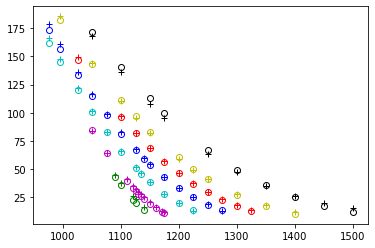

In [33]:
p0=(0.0278, 0.0027, 2.1177, 0.7880)
model_value=CGMY_calculate_model_values((0.0211,0.01,9.2949,1.3622))
model_value=CGMY_calculate_model_values(p0)
model_value=model_value.reshape([len(model_value),1])
model_value=pd.DataFrame(model_value)
model_value

plt.plot(options1['strike'], options1['price'], 'go', fillstyle='none', label='cena rynkowa')
plt.plot(options1['strike'], model_value.iloc[0:5], 'g+', fillstyle='none', label='cena rynkowa')

plt.plot(options2['strike'], options2['price'], 'mo', fillstyle='none', label='cena rynkowa')
plt.plot(options2['strike'], model_value.iloc[5:17], 'm+', fillstyle='none', label='cena rynkowa')

plt.plot(options3['strike'], options3['price'], 'co', fillstyle='none', label='cena rynkowa')
plt.plot(options3['strike'], model_value.iloc[17:29], 'c+', fillstyle='none', label='cena rynkowa')


plt.plot(options4['strike'], options4['price'], 'bo', fillstyle='none', label='cena rynkowa')
plt.plot(options4['strike'], model_value.iloc[29:43], 'b+', fillstyle='none', label='cena rynkowa')

plt.plot(options5['strike'], options5['price'], 'ro', fillstyle='none', label='cena rynkowa')
plt.plot(options5['strike'], model_value.iloc[43:54], 'r+', fillstyle='none', label='cena rynkowa')

plt.plot(options6['strike'], options6['price'], 'yo', fillstyle='none', label='cena rynkowa')
plt.plot(options6['strike'], model_value.iloc[54:65], 'y+', fillstyle='none', label='cena rynkowa')

plt.plot(options7['strike'], options7['price'], 'ko', fillstyle='none', label='cena rynkowa')
plt.plot(options7['strike'], model_value.iloc[65:], 'k+', fillstyle='none', label='cena rynkowa')

plt.savefig("CGMY_calibration",dpi=400)